In [0]:
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
        .appName("Transactions")\
        .getOrCreate()
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum, split, expr, udf, when, min, max, substring, regexp_replace
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import DoubleType, StructType, StructField, StringType, BooleanType, IntegerType, FloatType, ArrayType
from pyspark.ml.feature import StringIndexer, VectorAssembler, FeatureHasher, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import numpy as np
import pandas as pd
import seaborn as sns
import pyspark.pandas as ps
from scipy.stats import skew
from pyspark.ml.classification import RandomForestClassifier, LogisticRegressionModel, GBTClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassificationModel, GBTClassificationModel, DecisionTreeClassificationModel, LinearSVCModel, LinearSVC
from sklearn.metrics import precision_recall_curve
import pyspark.ml.linalg
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.evaluation import MulticlassMetrics
import math



| **Data/informação**| **Link/QRCode**| **Data/informação**| **Link/QRCode**|**Data/informação**| **Link/QRCode**|
|----|--------|----|--------|----|--------|
|**Dataset original** - *synthetic_fraud_data.csv*  | [<img src="https://dl.dropboxusercontent.com/scl/fi/j3tkdd9dzijhd3e00rt0z/Dataset_original.png?rlkey=3vmcxa4815hjy9c2joe2cvxfq&st=i6sjbokm&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1xUhvvQefx-WUNKjwuikdoAz3hpUoPJqU/view?usp=drive_link)|**Dataset tratado** - *datasetlimpo.csv*  | [<img src="https://dl.dropboxusercontent.com/scl/fi/seis4ey0ib91eb6kjfra4/Dataset_limpo.png?rlkey=8zo3abgjhzyfv2jd3n46c389q&st=115cuhj9&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1KKQFq_t4BYbu7GzjZgSVJrg9ZFz1bTOL/view?usp=drive_link)|**Dataset tratado** - *datasetlimpo.parquet*  | [<img src="https://dl.dropboxusercontent.com/scl/fi/xexb0v4tmb3vxeus1pm7p/Dataset_limpo_parquet.png?rlkey=23hs3u28sgq7xn07npw20m7m0&st=8mb94ynf&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1nd3PRdONSalWeO4pBkl1gEq5LGgh3RHK/view?usp=drive_link)|
|**Script CSV to Parquet** - *convert_csv_to_parquet.py*  | [<img src="https://dl.dropboxusercontent.com/scl/fi/jzb2wymo4fwimbsjjk3y3/csvtoparquet.png?rlkey=1wr7gughjbt2ih46adyg5vciv&st=lca1f1oi&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1XRntK424tsWxu2hzR3kbMOf2UV5bFWMQ/view?usp=drive_link)|**HeatMap Data Cleaning** - *heatmap.py*  | [<img src="https://dl.dropboxusercontent.com/scl/fi/9dzlsjl6rymjm2ve0tocn/heatmap.png?rlkey=p33rdaoi3k1tpcvx2vk8hml19&st=o0lc1big&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1-aXjO6wUEmQNWrTnunJyCY_j2VkNBdkc/view?usp=drive_link)|**Script Consumer** - *Read_stream_consumer_2.ipynb*  | [<img src="https://dl.dropboxusercontent.com/scl/fi/2x493tmsy72r8yb9w0sbm/Consumer.png?rlkey=y4k6ft3vgmq76uu3obbfv4wu5&st=7t937jli&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1gSv4oUkp19Tg-tRr_LX60hy90u3tWQqc/view?usp=drive_link)|
|**Script Producer** - *Send_stream_producer_2.ipynb*  | [<img src="https://dl.dropboxusercontent.com/scl/fi/iqqcgx1fkfqlikiayh4dq/Producer.png?rlkey=hm5917mc96ejbf0pqzla6fxny&st=ja76xkwy&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1PcgVAgnoTQs5pXxyQTLx_FjKUcFfL-pL/view?usp=drive_link)|**Apresentação** - *Apresentação.pbix*  |[<img src="https://dl.dropboxusercontent.com/scl/fi/0zb86haimhh23euh80wrm/Apresentacao.png?rlkey=26tbzhuyeq6shj80g4vo0mmkp&st=n0wcga2w&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1xedbuaBrejOpnaVS6dizJcywNlx9sQal/view?usp=drive_link) |**Modelos Treinados** - *ML Streaming.zip*  |[<img src="https://dl.dropboxusercontent.com/scl/fi/0wu3jyb2izqutfn43atxm/MLstreaming.png?rlkey=pr528g4isqh1x4dflulltck98&st=tvv4rzu2&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1NQsZJpgRPDJShosyMatryZ-LbQdMRl9B/view?usp=drive_link) |
|**Pipelines** - *Project_fraud.zip*  | [<img src="https://dl.dropboxusercontent.com/scl/fi/6rdmfnesazboicn4z6504/pipe.png?rlkey=jtey98vq13uwujps57koncbmf&st=zc1thix4&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1SxX13YiFeXiWH3ctrh8FcQsers-eXgnF/view?usp=drive_link)|**CNN script** - *CNN.py*  |[<img src="https://dl.dropboxusercontent.com/scl/fi/xt3acvbz5szsqt96a7hgd/CNN.png?rlkey=vwvwlte3jahmudd37ps3xqcxg&st=gv2s8k5x&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1Sw25XkdeG8Knq7nMGhsj-E0_wCW76tfQ/view?usp=drive_link) |**CNN Model** - *CNNbigdata.h5*  |[<img src="https://dl.dropboxusercontent.com/scl/fi/2mfd13by45fsp35nrw7sa/cnnmodel.png?rlkey=rzbfdsi1m46a15q2zz14zkaiv&st=2d5991l2&dl=0" alt="Texto Alternativo" width="150">](https://drive.google.com/file/d/1Sw25XkdeG8Knq7nMGhsj-E0_wCW76tfQ/view?usp=drive_link) |

Our functions

In [0]:
def converttoeuro(amount, currency):
    exchangerates = {"USD": 1.05,"GBP": 0.83,"EUR": 1.0,"JPY": 161.36, 'CAD':0.83,'RUB':109.67, 'BRL': 6.34,'AUD': 1.64,'MXN': 21.13,'NGN':1625.22, 'SGD':1.41 }
    return amount * exchangerates.get(currency, 1.0)

In [0]:
def streamfich (parquetpath):
    dfclean = spark.read.parquet(parquetpath, header=True, inferSchema=True)
    dfclean = df.withColumn("time", split(col("timestamp"), " ")[1].substr(0, 15))
    dfclean =df.drop('transaction_id','customer_id', 'card_number', 'merchant_category', 'merchant_type', 'merchant', 'card_type', 'device', 'device_fingerprint', 'high_risk_merchant', 'weekend_transaction', 'num_transactions', 'unique_merchants','unique_countries','country', "timestamp", "transaction_hour", "city", "ip_address", "velocity_last_hour", "total_amount", "max_single_amount", "amount")
    return dfclean


In [0]:
def calculardispersao(df, coluna):
    variancia = round(df.select(F.variance(coluna).alias("var")).collect()[0]["var"], 2)
    mean = df.select(F.mean(coluna).alias("mean")).collect()[0]["mean"]
    std = df.select(F.stddev(coluna).alias("std")).collect()[0]["std"]
    cv = round((std / mean) * 100, 2)
    stats = df.select(F.min(coluna).alias("min_value"), F.max(coluna).alias("max_value")).collect()[0]
    amplitude = round(stats["max_value"] - stats["min_value"], 2)
    Q1 = df.approxQuantile(coluna, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(coluna, [0.75], 0.01)[0]
    iqr = round(Q3 - Q1, 2)
    lower = Q1 - 1.5 * iqr
    upper = Q3 + 1.5 * iqr
    resultados = spark.sparkContext.parallelize([("Variance", variancia),("Coefficient of Variation (CV)", cv),("Range", amplitude),("IQR", iqr),]) 
    resultadodf = spark.createDataFrame(resultados,["Medidas", "Valores"]) 
    return resultadodf

In [0]:
def calcularmedidastendencia(df, coluna):
    media = round(df.select(F.mean(coluna).alias("media")).collect()[0]["media"], 2)
    std = round(df.select(F.stddev(coluna).alias("desvio_padrao")).collect()[0]["desvio_padrao"], 2)
    stats = df.select(F.min(coluna).alias("min_value"), F.max(coluna).alias("max_value")).collect()[0]
    minimo = round(stats["min_value"], 2)
    maximo = round(stats["max_value"], 2)
    skew = round(df.select(F.skewness(coluna).alias("skew_value")).collect()[0]["skew_value"], 2)
    moda_row = df.groupBy(coluna).count().orderBy(F.desc("count")).limit(1).collect()
    moda = round(moda_row[0][coluna], 2) if moda_row else None
    mediana = df.approxQuantile(coluna, [0.5], 0.01)[0]
    primeiroquantil = df.approxQuantile(coluna, [0.25], 0.01)[0]
    terceiroquantil = df.approxQuantile(coluna, [0.75], 0.01)[0]
    resultadordd = spark.sparkContext.parallelize([("Média", media),("Desvio Padrão", std),("Mínimo", minimo),("Máximo", maximo),("Assimetria", skew),("Moda", moda),("Mediana", mediana),("1º Quantil", primeiroquantil),("3º Quantil", terceiroquantil)])   
    resultadodf = spark.createDataFrame(resultadordd, ["Estatísticas", "Valores"])  
    return resultadodf

In [0]:
def extract_probability(probability):
    if probability is not None and isinstance(probability, DenseVector) and len(probability) > 1:
        return float(probability[1])
    else:
        return None

In [0]:
def calculate_pr_curve(predictions, label_col="label", prob_col="probability"):
    pdf = predictions.select(label_col, prob_col).toPandas()
    pdf["prob"] = pdf[prob_col].apply(lambda x: x[1]) 
    precision, recall, thresholds = precision_recall_curve(pdf[label_col], pdf["prob"])
    return precision, recall

In [0]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))


In [0]:

def sigmoid_vector(raw_prediction):
    return [sigmoid(v) for v in raw_prediction]




This [dataset](https://www.kaggle.com/datasets/ismetsemedov/transactions?resource=download), available on Kaggle, provides a simulated environment for developing and testing fraud detection models. It mimics realistic financial transaction patterns across various categories, such as retail, grocery, dining, travel, and more. By including diverse and detailed features, it enables an in-depth exploration of the patterns that differentiate legitimate transactions from fraudulent ones.

The first problem that we have, was our csv it was to big to be worked from databricks giving a error mensagem bellow:

<img src="https://dl.dropboxusercontent.com/scl/fi/0qt3i6ic8p3zisto7vg7s/Erro-databricks.png?rlkey=nlhv8nyfakjp7l4fofyfo6ilh&st=5leeore0&dl=0" alt="Texto Alternativo" width="300">

So we decided to convert the csv on to parquet 

In [0]:
df = spark.read.parquet("dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/transactions.parquet", header=True, inferSchema=True)
df.printSchema()
df.show(5, truncate=False)

root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- card_number: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- merchant_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_size: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_present: boolean (nullable = true)
 |-- device: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- device_fingerprint: string (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- distance_from_home: long (nullable = true)
 |-- high_risk_merchant: boolean (nullable = true)
 |-- transaction_hour: long (nullable = true)
 |-- weekend_transaction: boolean (nullable = true)
 |-- velocity_last_hour: string (nullable = 


Our dataset consists of 24 variables, which are described in the following table.

|**Variable**| **Description**|
|----|--------|
| **Transaction_id**| Unique identifier for each transaction.|
| **customer_id**| Unique identifier for each customer in the dataset.|
| **card_number**| Masked card number associated with the transaction.|
| **timestamp**| Date and time of the transaction.|
| **merchant_category**| General category of the merchant (e.g., Retail, Grocery, Travel).|
| **merchant_type**| Specific type within the merchant category (e.g., "online" for Retail).|
| **merchant** | Name of the merchant where the transaction took place.|
| **amount**| Transaction amount (currency based on the country).|
| **currency**| Currency used for the transaction (e.g., USD, EUR, JPY).|
| **country**| Country where the transaction occurred.|
| **city**| City where the transaction took place.|
| **city_size**| Size of the city (e.g., medium, large).|
| **card_type**| Type of card used (e.g., Basic Credit, Gold Credit).|
| **card_present**| Indicates if the card was physically present during the transaction (used in POS transactions).|
| **device**| Device used for the transaction (e.g., Chrome, iOS App, NFC Payment).|
| **channel**| Type of channel used for the transaction (web, mobile, POS). |
| **device_fingerprint**| Unique fingerprint for the device used in the transaction.|
| **ip_address**| IP address associated with the transaction.|
| **distance_from_home**| Binary indicator showing if the transaction occurred outside the customer's home country.|
| **high_risk_merchant**| Indicates if the merchant category is known for higher fraud risk (e.g., True, False).|
| **transaction_hour**| Hour of the day when the transaction was made.|
| **weekend_transaction**| Boolean indicating if the transaction took place on a weekend.|
| **velocity_last_hour**| Metrics on the transaction velocity, including:|
|                       | - **num_transactions**: Number of transactions in the last hour for this customer.|
|                       | - **total_amount**: Total amount spent in the last hour.|
|                       | - **unique_merchants**: Count of unique merchants in the last hour.|
|                       | - **unique_countries**: Count of unique countries in the last hour.|
|                       | - **max_single_amount**: Maximum single transaction amount in the last hour.|
| **is_fraud**| Binary indicator showing if the transaction is fraudulent (True for fraudulent transactions, False for legitimate ones).|



With 7,483,766 entries and 24 variables, ranging from qualitative to quantitative, our dataset is well-suited for a Big Data problem.

In [0]:
print("Número de linhas:", df.count(),"\nNúmero de colunas:",len(df.columns))

Número de linhas: 7483766 
Número de colunas: 24


In [0]:
df.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- card_number: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- merchant_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_size: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_present: boolean (nullable = true)
 |-- device: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- device_fingerprint: string (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- distance_from_home: long (nullable = true)
 |-- high_risk_merchant: boolean (nullable = true)
 |-- transaction_hour: long (nullable = true)
 |-- weekend_transaction: boolean (nullable = true)
 |-- velocity_last_hour: string (nullable = 

In [0]:
dtypes = df.dtypes
dtype_counts = {}
for dtype in dtypes:
    dtype_name = dtype[1]
    if dtype_name in dtype_counts:
        dtype_counts[dtype_name] += 1
    else:
        dtype_counts[dtype_name] = 1
for dtype, count in dtype_counts.items():
    print(f"{dtype}: {count}")

string: 16
bigint: 3
double: 1
boolean: 4


We used the circular graph or [pie chart](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.plot.pie.html), to better visualize the variables in our dataset. The majority of our variables are strings, in other words, qualitative variables, while the rest are integers, doubles, or booleans, which are quantitative.



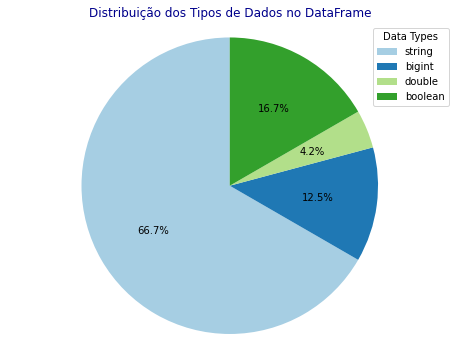

In [0]:
plt.figure(figsize=(8, 6))
plt.pie(list(dtype_counts.values()), autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.legend(list(dtype_counts.keys()), title="Data Types", loc="best")
plt.axis('equal')
plt.title('Distribuição dos Tipos de Dados no DataFrame', color="Darkblue")
plt.show()

Since Spark does not have a built-in function to count the number of nulls by default, we need to create a command to count them. The command returns a boolean value if the value is null, which is then converted to 1 (true) or 0 (false). After that, it sums the values in the column. The .show() command is used to display the results.

In [0]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+--------------+-----------+-----------+---------+-----------------+-------------+--------+------+--------+-------+----+---------+---------+------------+------+-------+------------------+----------+------------------+------------------+----------------+-------------------+------------------+--------+
|transaction_id|customer_id|card_number|timestamp|merchant_category|merchant_type|merchant|amount|currency|country|city|city_size|card_type|card_present|device|channel|device_fingerprint|ip_address|distance_from_home|high_risk_merchant|transaction_hour|weekend_transaction|velocity_last_hour|is_fraud|
+--------------+-----------+-----------+---------+-----------------+-------------+--------+------+--------+-------+----+---------+---------+------------+------+-------+------------------+----------+------------------+------------------+----------------+-------------------+------------------+--------+
|             0|          0|          0|        0|                0|            0|       0|   

In [0]:
duplicatescount = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicatescount}")

Number of duplicate rows: 0


So, we can summarize our dataset as a transactions dataset with 24 variables: 16 qualitative variables and 8 quantitative variables. Our target variable is *'is_fraud'*, a boolean variable that takes two values: 1 for *'True'* (fraudulent transaction) and 0 for *'False'* (normal transaction). Our dataset doesn't have any null or duplicate values in our variables.
|**Variable**|**Dtype**|**Variable Type**|  
|------------|---------|-----------------|  
|**Transaction_id**|object|Qualitative|  
|**customer_id**|object|Qualitative|  
|**card_number**|int64|Quantitative|  
|**timestamp**|object|Qualitative|  
|**merchant_category**|object|Qualitative|  
|**merchant_type**|object|Qualitative|  
|**merchant**|object|Qualitative|  
|**amount**|float64|Quantitative|  
|**currency**|object|Qualitative|  
|**country**|object|Qualitative|  
|**city**|object|Qualitative|  
|**city_size**|object|Qualitative|  
|**card_type**|object|Qualitative|  
|**card_present**|bool|Quantitative|  
|**device**|object|Qualitative|  
|**channel**|object|Qualitative|  
|**device_fingerprint**|object|Qualitative|  
|**ip_address**|object|Qualitative|  
|**distance_from_home**|int64|Quantitative|  
|**high_risk_merchant**|bool|Quantitative|  
|**transaction_hour**|int64|Quantitative|  
|**weekend_transaction**|bool|Quantitative|  
|**velocity_last_hour**|object|Qualitative|  
|**is_fraud**|bool|Quantitative|  

Posting the last, we are now able to continue our descriptive statistical analysis of our variables, we are dividing the analysis into two parts: quantitative and qualitative variables.

##Quantitative variables

  - card_number
  - amount 
  - card_present
  - distance_from_home
  - high_risk_merchant
  - transaction_hour
  - weekend_transaction
  - is_fraud

##Qualitative variables

  - Transaction_id
  - customer_id
  - timestamp
  - merchant_category
  - merchant_type
  - merchant
  - currency
  - country
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour

Looking at the last two divided lists, we realize that some variables are likely misclassified. For example, *currency* and *velocity_last_hour* are usually numeric; however, they should be classified as qualitative because they likely contain characters as well ("**€/$**" our "**km/h our miles/h**").

We will use the [CRISP methodology](https://www.datascience-pm.com/crisp-dm-2/) to analyze our dataset, but for the purpose of EDA, we will focus only on steps 2.2 (Data Understanding) and 2.3 (Data Preparation) to provide us with a clear direction to follow.

- 2.2. Data Understanding
  - 2.2.1. [Initial Data Collection](#initial-data-collection)
  - 2.2.2. Data Description
  - 2.2.3. Data Exploration
  - 2.2.4. Data Quality Verification

- 2.3. Data Preparation
  - 2.3.1. Data Selection
  - 2.3.2. Data Cleaning
  - 2.3.3. Deriving New Data
  - 2.3.4. Data Integration
  - 2.3.5. Data Formatting
  - 2.3.6. Dataset Creation

#Data Understanding

###Initial Data Collection


As we have seen previously, our dataset is available on Kaggle. Initially, the file was in CSV format, which was too large to be uploaded to the community version of Databricks. This is why it was necessary to convert the file to a lighter version that could be uploaded. To do this, we used VSCode to run the script below:

```python
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
df = pd.read_csv("C:\\Users\\garci\\OneDrive\\Área de Trabalho\\Ambiente de trabalho unbunto\\Cienciadedados\\IPL\\BigData\\Trabalho\\synthetic_fraud_data.csv")
table = pa.Table.from_pandas(df)
pq.write_table(table, 'C:\\Users\\garci\\OneDrive\\Área de Trabalho\\Ambiente de trabalho unbunto\\Cienciadedados\\IPL\\BigData\\Trabalho\\transactions.parquet')
```

The process used was initially described in our work. We will now move on to the next part of the CRISP process.



###Data Description

At this point, the process we have completed has shown the following: our dataset consists of 7,483,766 observations and 24 variables, of which 16 are qualitative (strings) and 8 are quantitative (3 integers, 1 double, and 4 boolean). We have classified the boolean variable as quantitative, even though in practice it contains characters in our dataset. However, based on the logic of the variable (0 or 1), we consider it as quantitative. There are no null (or empty) values, and there are no duplicate records. We have identified our target variable as "*is_fraud*".

By default, the dataset visualization in Spark is a bit inadequate, as the values come in raw form. However, there are functions that allow for better data visualization. Functions like [.toPandas()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html) enable the creation of a more user-friendly graphical interface.

In [0]:
df.limit(5).toPandas()


,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820+00:00,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,0,False,0,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464+00:00,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,1,True,0,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762+00:00,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,0,False,0,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466+00:00,Gas,major,Exxon,630.60,AUD,Australia,...,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,0,False,0,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063+00:00,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,1,False,0,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In a summary analysis, we can already identify some data treatments to be performed based on what has been presented, especially regarding the timestamp column, where both a date and time appear to be in the same cell. It might be appropriate to separate the analysis into date and time components for better clarity and analysis.

##Data Exploration

Now let's move into a part of CRISP that has not yet been addressed, which refers to Data Exploration. In this step, we will divide the exploration into as many sections as there are variables, starting with the quantitative variables, followed by the qualitative ones.

- Quantitative variables
  - is_fraud (Target variable)
  - card_number
  - amount
  - card_present
  - distance_from_home
  - high_risk_merchant
  - transaction_hour
  - weekend_transaction
- Qualitative variables
  - Transaction_id
  - customer_id
  - timestamp
  - merchant_category
  - merchant_type
  - merchant
  - currency
  - country
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour




### Data Exploration - Quantitative variable - is_fraud

Our target variable, is_fraud, is a boolean variable, as we have already identified, with a value that can be either

In [0]:
fraudcounts = df.groupBy("is_fraud").count().toPandas()
fraudcounts['relativevalue'] = round((fraudcounts['count'] / fraudcounts['count'].sum())*100,2)
fraudcounts

,is_fraud,count,relativevalue
0,True,1494719,19.97
1,False,5989047,80.03


<command-4315126035878462>:3: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([0, 1], labels=["Is Fraud", "Is Not Fraud"], title="Distance from home", loc="best")


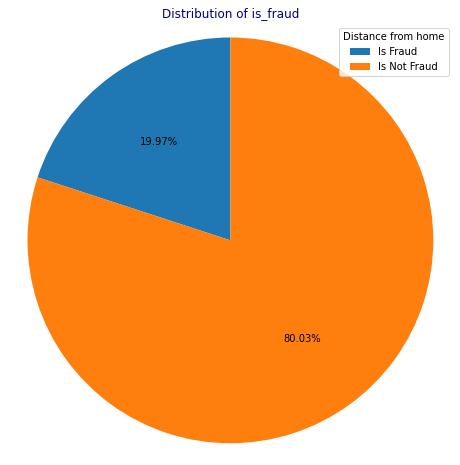

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(fraudcounts['count'], autopct='%0.2f%%', startangle=90)
plt.legend([0, 1], labels=["Is Fraud", "Is Not Fraud"], title="Distance from home", loc="best")
plt.title("Distribution of is_fraud", color="Darkblue")
plt.axis('equal')
plt.show()

Looking at the previous information, we can see that our target variable is imbalanced, which actually makes sense, as there are likely more non-fraud observations than fraudulent ones. Therefore, this value is logical and acceptable.



###Data Exploration - Quantitative variable - card_number

By the command below, we can identify that the dataset contains information related to 5000 ATM cards. In a variable like *card_number*, where the information from the quantitative variable does not provide significant insights in terms of dispersion or trend measures per se, it is more relevant to analyze, for instance, the frequencies—in this case, how often the debit/credit cards are used. This includes metrics like the maximum or minimum usage, as well as the average number of transactions.

In [0]:
cardnbrcounts= df.groupBy("card_number").count().toPandas()
cardnbrcounts

,card_number,count
0,5930465985280568,1568
1,6915946555024251,1706
2,5392351642652913,1708
3,6875574290402158,1555
4,6130092536634006,1917
...,...,...
4995,5543382724295915,1262
4996,6236728368175112,1137
4997,376806344316688,1217
4998,5750530878561049,1419


In [0]:
maisobservacoes= cardnbrcounts.loc[cardnbrcounts["count"].idxmax()]
menorobservacoes=cardnbrcounts.loc[cardnbrcounts["count"].idxmin()]
media = cardnbrcounts["count"].mean()
summary = pd.DataFrame({"Metric": ["Max Observations", "Min Observations", "Mean Observations"], "Count": [maisobservacoes["count"], menorobservacoes["count"], round(media, 2)]
})

summary 

,Metric,Count
0,Max Observations,2000.00
1,Min Observations,1000.00
2,Mean Observations,1496.75


In a variable with 5000 observations, it is challenging to analyze the data directly. Therefore, we need to divide our observation intervals by the total number of observations and identify how many accounts fall within each interval. At this stage, we are not concerned with which accounts specifically but rather with how many fall within a given range. For example, in the interval [1000-1099], there are 523 accounts. Knowing that the smallest observed number was 1000 and the largest observed number is 2000, we can create intervals to check the frequencies. To make it easier to read, let's divide them into intervals of 100 observations, for that, we will use the pandas library, more specifically the [pd.cut](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) function.

In [0]:
cardnbrcounts['interval'] = pd.cut(cardnbrcounts['count'], bins=range(900, 2100, 100),labels=["[900-1000]", "]1000-1100]", "]1100-1200]", "]1200-1300]", "]1300-1400]", "]1400-1500]", "]1500-1600]", "]1600-1700]", "]1700-1800]", "]1800-1900]", "]1900-2000]"], include_lowest=True)
intervalcounts = cardnbrcounts.groupby('interval').size().reset_index(name='card_number_count')
intervalcounts['relativefrequency'] = (intervalcounts['card_number_count'] / intervalcounts['card_number_count'].sum()) * 100
intervalcounts

,interval,card_number_count,relativefrequency
0,[900-1000],5,0.10
1,]1000-1100],518,10.36
2,]1100-1200],468,9.36
3,]1200-1300],511,10.22
4,]1300-1400],517,10.34
5,]1400-1500],512,10.24
6,]1500-1600],506,10.12
7,]1600-1700],501,10.02
8,]1700-1800],512,10.24
9,]1800-1900],476,9.52



So, for our AED, we decided to visualize our bins using a [bar plot](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.plot.bar.html) and a [pie chart](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.plot.pie.html).

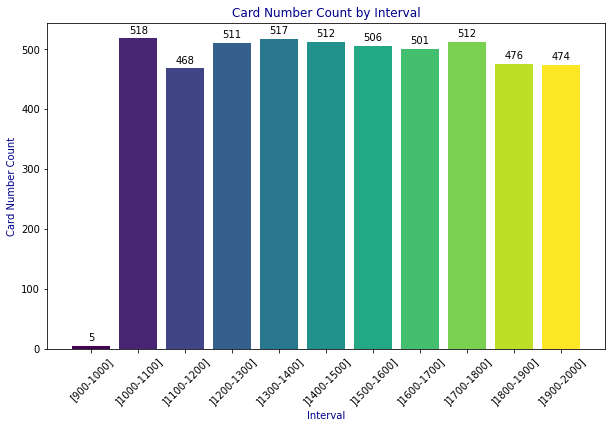

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(intervalcounts)))
plt.figure(figsize=(10, 6))
bars = plt.bar(intervalcounts['interval'], intervalcounts['card_number_count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=10)
plt.title('Card Number Count by Interval', color='darkblue')
plt.xlabel('Interval', color='darkblue')
plt.ylabel('Card Number Count', color='darkblue')
plt.xticks(rotation=45)
plt.show()

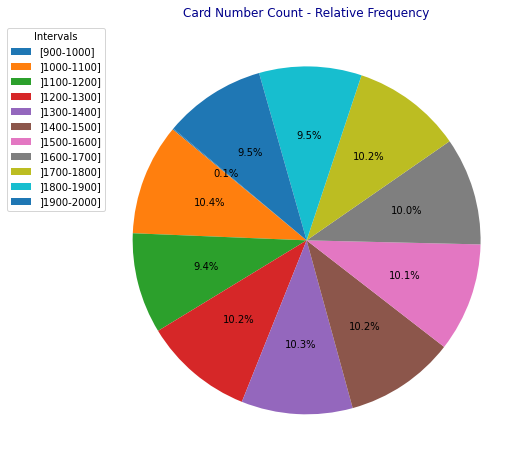

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(intervalcounts['relativefrequency'], autopct='%1.1f%%', startangle=140)
plt.title('Card Number Count - Relative Frequency', color='darkblue')
plt.legend(intervalcounts['interval'], title='Intervals', loc='upper left', bbox_to_anchor=(-0.2, 1))
plt.show()

So, regarding our variable *card_number*, we can state the following: there are 5000 different values, meaning there are 5000 bank cards that performed a total of 7,483,766 transactions. On average, each card performed approximately 1497 transactions, with the maximum number of transactions for a card being 2000 and the minimum being 1000.



###Data Exploration - Quantitative variable - amount

Regarding our variable amount, we know that it describes the transaction amount, but there was no information about the units of measurement. This leaves the information in the dataset to be interpreted as the amount of money according to the country. By analyzing this variable superficially, we can conclude that it is not useful, as it can have several value interpretations. That is, I cannot have one observation that corresponds to euros and another observation that corresponds to dollars. The analysis of this variable would be meaningless, as it would not be possible to extract true information from it

In [0]:
cardamount= df.groupBy("amount").count().toPandas()
cardamount

,amount,count
0,548.64,26
1,1100.15,12
2,8401.96,1
3,6410.87,1
4,9062.58,3
...,...,...
2831162,136032.10,1
2831163,14435.90,1
2831164,4306.20,1
2831165,1161142.78,1


The solution, looking at our dataset, would be to convert all the values to a single unit of measurement. Now, we need to identify the observations of the units of measurement of the transactions (i.e., the currency). To simplify the process, we will work with the currency that has the highest number of observations and convert the others to that unit. For this, we will need to temporarily suspend the analysis of our *amount* variable and move on to our qualitative variable *currency*.

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - **amount**
(...)
- Qualitative variables
(...)
  - **currency**
(...)





###Data Exploration - Quanlitative variable - currency

"Let's now take a look at our qualitative variable, currency. As we have seen, this variable refers to the type of currency corresponding to the monetary transaction made. It is divided into 11 distinct observations ([currency font](https://pt.wikipedia.org/wiki/Lista_de_moedas)):

- GBP - British Pounds Sterling
- RUB - Russian Ruble
- BRL - Brazilian real
- CAD - Canadian dollar
- EUR - EURO
- AUD - Australian dollar
- JPY - Japanese yen
- MXN - Mexican peso
- USD - United States dollar
- NGN - Nigerian naira
- SGD - Singapore dollar

In [0]:
cardcurrency= df.groupBy("currency").count().toPandas()
cardcurrency['relativevalue'] = round((cardcurrency['count'] / cardcurrency['count'].sum())*100,2)
cardcurrency

,currency,count,relativevalue
0,GBP,538493,7.20
1,RUB,793730,10.61
2,BRL,804800,10.75
3,CAD,532632,7.12
4,EUR,1065751,14.24
5,AUD,496695,6.64
6,JPY,527393,7.05
7,MXN,785704,10.50
8,USD,500060,6.68
9,NGN,849840,11.36


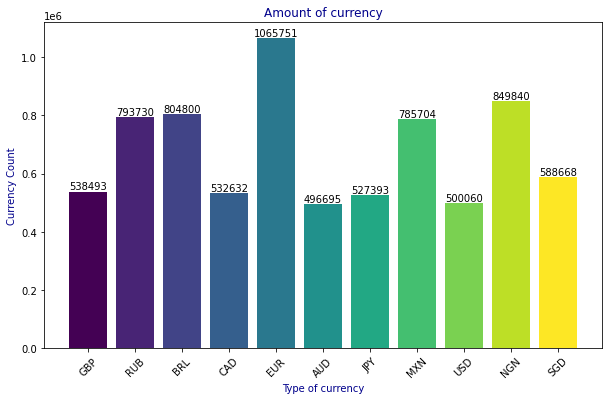

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(intervalcounts)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardcurrency['currency'], cardcurrency['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=10)
plt.title('Amount of currency', color='darkblue')
plt.xlabel('Type of currency', color='darkblue')
plt.ylabel('Currency Count', color='darkblue')
plt.xticks(rotation=45)
plt.show()

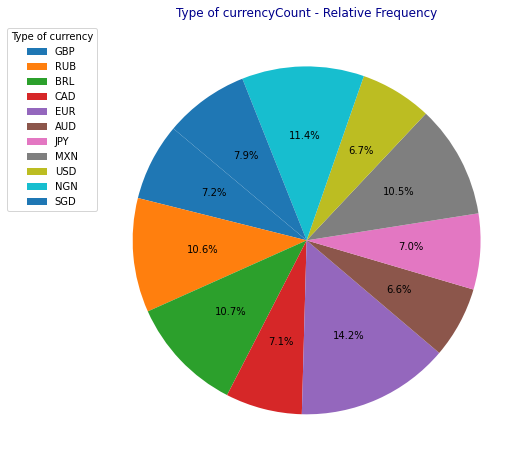

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardcurrency['relativevalue'], autopct='%1.1f%%', startangle=140)
plt.title('Type of currencyCount - Relative Frequency', color='darkblue')
plt.legend(cardcurrency['currency'], title='Type of currency', loc='upper left', bbox_to_anchor=(-0.2, 1))
plt.show()

We have found that the most observed currency is the Euro, which means that we will convert all other currencies to Euro in order to have a single unit of measurement in our amount variable. Considering the above, we will use the exchange rates available on December 15th, 2024, as this value is calculated daily, and we will use the provided date as the [reference](https://www.xe.com/currencyconverter/convert/?Amount=1&From=EUR&To=SGD).
To avoid modifying the values of the variables in our dataset, we create a new column with the necessary information. Initially, we define a function called *converttoeuro* to facilitate the conversion process of our variable.

In [0]:
converttoeuroudf = udf(converttoeuro, FloatType())
df = df.withColumn("amounteuro", converttoeuroudf(df['amount'], df['currency']))

Having created our variable *amounteuro*, the variable *amount* no longer makes sense. Therefore, we have replaced our quantitative variable *amount* with *amounteuro* since the information they represent is the same.

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - **amount** replace by amounteuro
(...)
- Qualitative variables
(...)
  - **currency**
(...)

In [0]:
cardamounteuro= df.groupBy("amounteuro").count().toPandas()
cardamounteuro.sort_values(by="count", ascending=False)


,amounteuro,count
3446807,6.340000e-01,212
1494148,1.268000e+00,191
547107,1.585000e+00,182
2966261,9.510000e-01,172
979632,1.902000e+00,143
...,...,...
1495000,1.002812e+08,1
1495001,5.331499e+08,1
1495005,1.364441e+09,1
1495006,3.720913e+06,1


In [0]:
df = df.drop("amount")

If our variable *amounteuro* now has its metric value associated with a single currency, the euro, then theoretically our *currency* variable would no longer make sense to keep in the dataset. However, this variable could still provide relevant information for our classification problem, specifically regarding its relationship with our target variable. That is, in practice, there might be a strong relationship between the *currency* variable and our target variable (e.g., *is_fraud*, such as associating that most frauds are conducted using USD). Therefore, it becomes necessary to analyze the correlation between the *is_fraud* variable and the *currency* variable before deciding whether to delete or retain it. Let's leave the correlation analysis for the end of the statistical analysis.





###Data Exploration - Quantitative variable - amounteuro (NEW)

Let's proceed with the statistical analysis of the created variable *amounteuro*, examining the measures of central tendency and non-central tendency, as well as the measures of dispersion. We will start with measures of central and non-central tendency, using a custom-defined function to simplify the calculations (mean, standard deviation, mode, median, 1st IQR, 3rd IQR, skew, min, max).

###**Mean**
The mean is the sum of all values divided by the total number of values.

$$
\mu = \frac{1}{N} \sum_{i=1}^{N} x_i
$$


### **Standard Deviation**

The standard deviation measures the dispersion of data from the mean.

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
$$

---

### **Mode**

The mode is the value that occurs most frequently in the dataset.

$$
\text{Mode} = \text{value that occurs most frequently}
$$

---

### **Median**

The median is the value that separates the data into two groups such that 50% of the data is below it and 50% is above it.

if odd
$$
\text{Median} = x_{(n+1)/2} 
$$

iff even
$$
\text{Median} =\frac{x_{N/2} + x_{(N/2)+1}}{2} 
$$

---

### **1st Quartile (Q1) and 3rd Quartile (Q3)**

Quartiles divide the ordered data into four equal parts.

$$
Q1 = \text{median of the first half of the data}
$$
$$
Q3 = \text{median of the second half of the data}
$$

---

### **Skewness**

Skewness measures the degree of asymmetry of the distribution with respect to the mean. For a symmetric distribution, the skewness is 0.

$$
\gamma_1 = \frac{N}{(N-1)(N-2)} \sum_{i=1}^{N} \left( \frac{x_i - \mu}{\sigma} \right)^3
$$

---

### **Minimum (Min) and Maximum (Max)**

The minimum value is the smallest value in the dataset, and the maximum value is the largest.

$$
\text{Minimum} = \min(x_1, x_2, ..., x_N)
$$
$$
\text{Maximum} = \max(x_1, x_2, ..., x_N)
$$

In [0]:
calcularmedidastendencia(df,"amounteuro").toPandas()

,Estatísticas,Valores
0,Média,5.833420e+07
1,Desvio Padrão,2.851326e+08
2,Mínimo,1.000000e-02
3,Máximo,1.016275e+10
4,Assimetria,1.255000e+01
5,Moda,6.300000e-01
6,Mediana,2.215070e+03
7,1º Quantil,4.095486e+02
8,3º Quantil,1.652096e+06


From the analysis of the previous values, we observe the following:

- **Minimum Value:** The minimum value corresponds to **€0.01**, or 1 cent.  
- **Maximum Value:** The maximum value is **€10,162,750,000** (ten billion, one hundred sixty-two million, seven hundred fifty thousand euros).  
- **Skewness Coefficient:** The skewness coefficient is **12.55**, indicating a **positive skewness**, with most of the values concentrated near the lower end (low values), and a long tail of very high values (extreme values).  
- **Mode:** The most frequently observed value in the dataset is **€0.63**, or 63 cents.  
- **Mean:** The average value of the observations is **€58,334,200** (fifty-eight million, three hundred thirty-four thousand, and two hundred euros).  
- **First Quartile (Q1):** 25% of the observations have values equal to or less than **€409.54**.  
- **Third Quartile (Q3):** 75% of the observations have values equal to or less than **€1,652,096** (one million, six hundred fifty-two thousand, and ninety-six euros).  
- **Median:** The median value, representing the 50th percentile, is **€2,215.7**, which means that **50% of the sample has a value of `amounteuro` equal to or less/more than €2,215.7**.
- The standard deviation (std) is **€285,132,600**. This extremely high value indicates that the data has **very high variability** relative to the mean (**€58,334,200**). It suggests that there are extreme values (outliers) in the dataset that are significantly distant from the mean, causing this large dispersion.

Given the measures of central and non-central tendency, let's now look at our dispersion measures (variance, coefficient of variation, DMA, range, IQR, outliers)

## **Variance**
Variance measures the average squared deviation of each number from the mean.

$$
\sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2
$$

---

### **Coefficient of Variation (CV)**
The coefficient of variation is the ratio of the standard deviation to the mean, expressed as a percentage.

$$
\text{CV} = \frac{\sigma}{\mu} \times 100
$$
---

### **DMA (Mean Absolute Deviation)**
The DMA is the average of the absolute deviations from the mean.

$$
\text{DMA} = \frac{1}{N} \sum_{i=1}^{N} |x_i - \mu|
$$
---

### **Range**
The range is the difference between the maximum and minimum values in the dataset.

$$
\text{Range} = \text{Max} - \text{Min}
$$

---

### **Interquartile Range (IQR) and Outliers**
The interquartile range is the difference between the first and third quartiles (Q1 and Q3).

$$
\text{IQR} = Q3 - Q1
$$

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/0*XG2sFucPoFMg6NeV.png" alt="Texto Alternativo" width="300">





In [0]:
calculardispersao(df,"amounteuro").toPandas()

,Medidas,Valores
0,Variance,8.130061e+16
1,Coefficient of Variation (CV),4.887900e+02
2,Range,1.016275e+10
3,IQR,1.651687e+06



From the analysis of the previous values, we observe the following:

- A higher **variance** (8.130061e+16) indicates that the suggests that the data has a significant spread, with some data points being far from the mean.
- This high **Coefficient of Variation (CV)** (488.79%) indicates that the data has a large relative variability compared to the mean.
- **Range**: 1.016275e+10 This large range suggests that the data spans a very wide interval, from the smallest to the largest value.
- The relatively large IQR value (**IQR**: 1.651687e+06) suggests that the middle 50% of the data has a significant spread,  but not as extreme as the overall range.



In [0]:
#ps.DataFrame(cardamounteuro)
#df['count'].plot.box()  


Using Sturges' formula 

$$
\( k = 1 + \log_2(N) \)
$$ 
We determined that the number of intervals to create would be 24. However, visually, this does not allow us to draw significant conclusions. Therefore, we decided not to create graphs for this variable, keeping only the statistical analysis performed so far, namely the table of central and non-central tendency measures and the table of dispersion measures. Let's take to the next variable.


- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~
  - card_present
  - distance_from_home
  - high_risk_merchant
  - transaction_hour
  - weekend_transaction
- Qualitative variables
  - Transaction_id
  - customer_id
  - timestamp
  - merchant_category
  - merchant_type
  - merchant
  - ~~currency~~
  - country
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour




### Data Exploration - Quantitative variable - card_present


Let's now work with the quantitative variable *card_present*, which, according to its description, indicates if the card was physically present during the transaction (used in POS transactions).

In [0]:
cardpresent= df.groupBy("card_present").count().toPandas()
cardpresent['relativevalue'] = round((cardpresent['count'] / cardpresent['count'].sum())*100,2)
cardpresent

,card_present,count,relativevalue
0,True,651047,8.7
1,False,6832719,91.3


The analysis of the graphs for this variable does not provide added value, as the distribution of the sample is heavily concentrated around the positive value with 91,3% of observations, comparing with the negative one it only the rest 8,7% of the observations, making the variable's value relative. However, we will keep it until it is correlated with our target variable.

<command-1361310689052366>:3: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([0, 1], labels=["Card present", "Card not present"], title="Distance from home", loc="best")


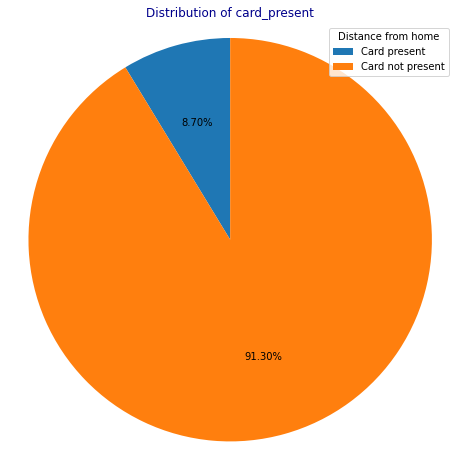

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardpresent['count'], autopct='%0.2f%%', startangle=90)
plt.legend([0, 1], labels=["Card present", "Card not present"], title="Distance from home", loc="best")
plt.title("Distribution of card_present", color="Darkblue")
plt.axis('equal')
plt.show()

### Data Exploration - Quantitative variable - distance_from_home

Let's now work with the quantitative variable card_present, which, according to its description, indicates if the transaction occurred outside the customer's home country.
If card_present = 0, then the transaction occurred within the customer's home country; otherwise, the transaction occurred outside the customer's country

In [0]:
carddistance= df.groupBy("distance_from_home").count().toPandas()
carddistance['relativevalue'] = round((carddistance['count'] / carddistance['count'].sum())*100,2)
carddistance

,distance_from_home,count,relativevalue
0,0,5073605,67.79
1,1,2410161,32.21


The variable appears to have some potential for correlation with our target variable, as its observations are approximately divided into 1/3 of values corresponding to 1, meaning *"Outside the customer's home country"*, accounting for about 32,1%, and 2/3 for the value of 0, meaning *"Within the customer's home country,"* which corresponds to about 67,79%.

<command-1361310689052370>:3: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([0, 1], labels=["Within the customer's home country", "Outside the customer's home country"], title="Distance from home", loc="best")


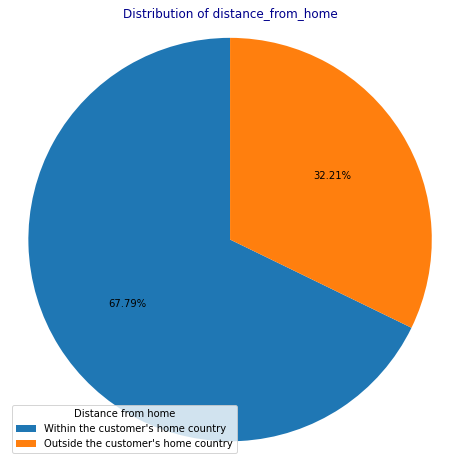

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(carddistance['count'], autopct='%0.2f%%', startangle=90)
plt.legend([0, 1], labels=["Within the customer's home country", "Outside the customer's home country"], title="Distance from home", loc="best")
plt.title("Distribution of distance_from_home", color="Darkblue")
plt.axis('equal')
plt.show()

### Data Exploration - Quantitative variable - high_risk_merchante

Now, let's examine another qualitative variable, high_risk_merchant. According to its definition, this variable indicates whether the merchant category is associated with a higher risk of fraud (e.g., True, False).
The variable high_risk_merchant is a binary qualitative variable that can take on two values: 0 or 1, corresponding to True or False, respectively. It is important to note that True indicates the merchant is categorized as high risk, while False indicates otherwise.

In [0]:
cardhrm= df.groupBy("high_risk_merchant").count().toPandas()
cardhrm['relativevalue'] = round((cardhrm['count'] / cardhrm['count'].sum())*100,2)
cardhrm

,high_risk_merchant,count,relativevalue
0,True,1871963,25.01
1,False,5611803,74.99


Based on the analysis, we observed that approximately 25% of the transactions are classified as High Risk Merchant, while the remaining 75% are classified as Not High Risk Merchant

<command-4350573021961013>:3: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([0, 1], labels=["High Risk Merchant", "Not High Risk Merchant"], title="High risk merchante", loc="best")


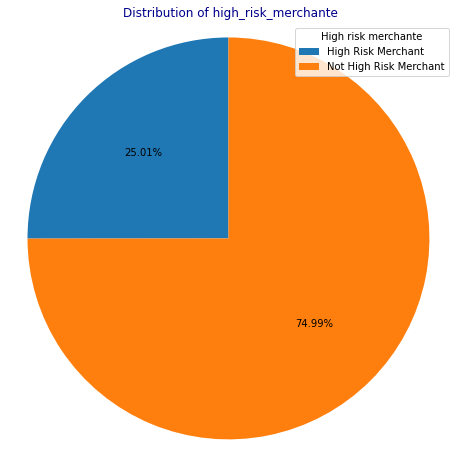

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardhrm['count'], autopct='%0.2f%%', startangle=90)
plt.legend([0, 1], labels=["High Risk Merchant", "Not High Risk Merchant"], title="High risk merchante", loc="best")
plt.title("Distribution of high_risk_merchante", color="Darkblue")
plt.axis('equal')
plt.show()

Let's provide an update on the variables analyzed so far.

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - transaction_hour
  - weekend_transaction
- Qualitative variables
  - Transaction_id
  - customer_id
  - timestamp
  - merchant_category
  - merchant_type
  - merchant
  - ~~currency~~
  - country
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour

If we look closely, there are three qualitative variables that may be associated with the one analyzed previously. These are:

- merchant_category
- merchant_type
- merchant

Let's proceed with their analysis for now, and we will return to the analysis of quantitative variables shortly.




### Data Exploration - Quanlitative variable - merchant_category

The qualitative variable merchant_category represents the general category of the merchant, as described in its definition its general category of the merchant (e.g., Retail, Grocery, Travel).

In [0]:
cardmc= df.groupBy("merchant_category").count().toPandas()
cardmc['relativevalue'] = round((cardmc['count'] / cardmc['count'].sum())*100,2)
cardmc

,merchant_category,count,relativevalue
0,Education,933542,12.47
1,Entertainment,936173,12.51
2,Healthcare,936770,12.52
3,Travel,935790,12.50
4,Grocery,934029,12.48
5,Restaurant,936178,12.51
6,Gas,935401,12.50
7,Retail,935883,12.51


The **merchant_category** variable can assume one of 8 categories:  
- **Education**  
- **Entertainment**  
- **Healthcare**  
- **Travel**  
- **Grocery**  
- **Restaurant**  
- **Gas**  
- **Retail**  

These categories are relatively evenly distributed, with each category representing approximately **12.5%** of the observations.


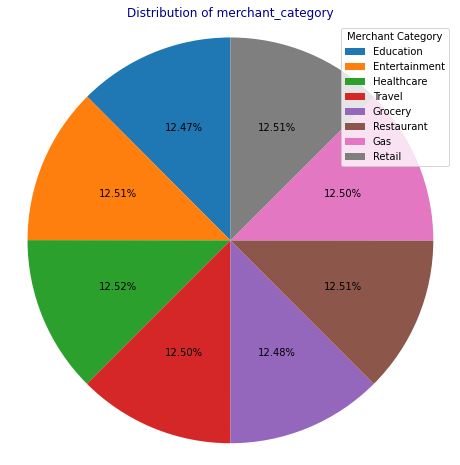

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardmc['count'], autopct='%0.2f%%', startangle=90)
plt.legend(cardmc['merchant_category'], title="Merchant Category", loc="best")
plt.title("Distribution of merchant_category", color="Darkblue")
plt.axis('equal')
plt.show()

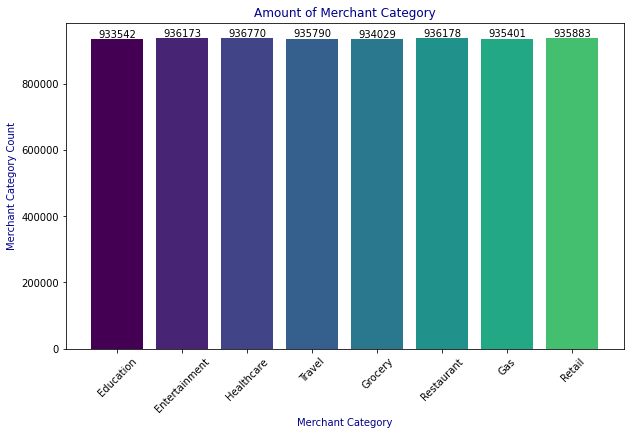

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(intervalcounts)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardmc['merchant_category'], cardmc['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=10)
plt.title('Amount of Merchant Category', color='darkblue')
plt.xlabel('Merchant Category', color='darkblue')
plt.ylabel('Merchant Category Count', color='darkblue')
plt.xticks(rotation=45)
plt.show()

Looking at the previous data, both the table of absolute and relative values as well as the graphs, we notice that due to the homogeneity within the category, this variable may not add significant value in terms of determining or classifying our target variable. That is, the correlation between the **is_fraud** variable and **merchant_category** is expected to be low. If this is the case, the most likely scenario will be not to consider this variable for the categorization of our target variable.



### Data Exploration - Quanlitative variable - merchant_type

Now, analyzing the other qualitative variable that appears to be related to the *high_risk_merchant* variable, let's proceed with the analysis of the *merchant_type* variable. This variable is described as the specific type within the merchant category (e.g., "online" for Retail).

In [0]:
cardmt= df.groupBy("merchant_type").count().toPandas()
cardmt['relativevalue'] = round((cardmt['count'] / cardmt['count'].sum())*100,2)
cardmt

,merchant_type,count,relativevalue
0,online,1401650,18.73
1,local,467902,6.25
2,hotels,234311,3.13
3,physical,935039,12.49
4,major,467499,6.25
5,casual,311678,4.16
6,events,312598,4.18
7,streaming,312091,4.17
8,pharmacy,468377,6.26
9,transport,233977,3.13


Looking at the previous command, we observe that the *merchant_type* variable has approximately 17 possible values, which are:

- online
- local
- hotels
- physical
- major
- casual
- events
- streaming
- pharmacy
- transport
- booking
- airlines
- gaming
- premium
- medical
- supplies
- fast_food

The category with the highest number of observations is *online* with 18,73% of the observations, while the category with the lowest incidence is *airlines* with 3,12% of the observations.


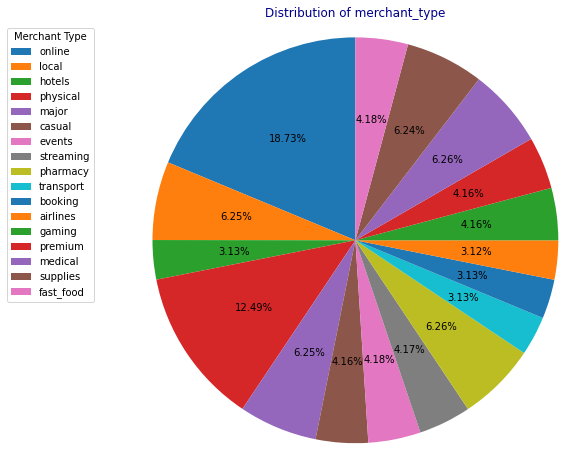

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardmt['count'], autopct='%0.2f%%', startangle=90)
plt.legend(cardmt['merchant_type'], title="Merchant Type", bbox_to_anchor=(-0.075, 1))
plt.title("Distribution of merchant_type", color="Darkblue")
plt.axis('equal')
plt.show()

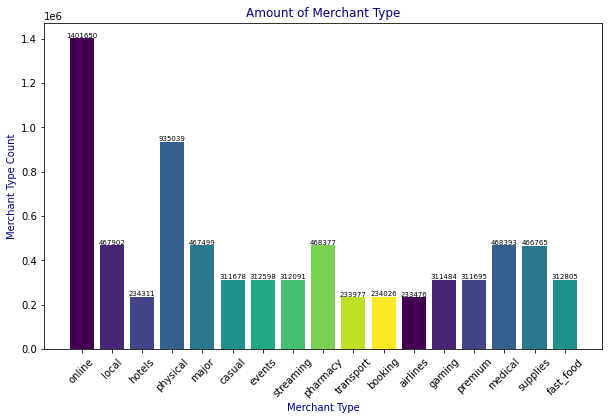

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(intervalcounts)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardmt['merchant_type'], cardmt['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=7)
plt.title('Amount of Merchant Type', color='darkblue')
plt.xlabel('Merchant Type', color='darkblue')
plt.ylabel('Merchant Type Count', color='darkblue')
plt.xticks(rotation=45)
plt.show()

Let's now analyze our last qualitative variable that may be associated with the *high_risk_merchant* variable, which is the *merchant* variable.

### Data Exploration - Quanlitative variable - merchant_category

According to its definition, this variable can be described as the *Name of the merchant* where the transaction took place.

In [0]:
cardm= df.groupBy("merchant").count().toPandas()
cardm['relativevalue'] = round((cardm['count'] / cardm['count'].sum())*100,2)
cardm

,merchant,count,relativevalue
0,Applebee's,62478,0.83
1,Red Lobster,62322,0.83
2,Chegg,156105,2.09
3,Delta,38935,0.52
4,Hertz,46801,0.63
...,...,...,...
100,Amazon Fresh,116774,1.56
101,Wendy's,52057,0.70
102,IKEA,58302,0.78
103,Local Hospital,116981,1.56


Given that there are 104 unique observations for the variable *merchant*, creating a graph would not be useful due to the difficulty of interpreting it. However, we will check for the largest and smallest observations.


In [0]:
maxmerchant = cardm.loc[cardm['count'].idxmax()]
minmerchant = cardm.loc[cardm['count'].idxmin()]
print("The value with the lowest observation is", minmerchant[0],", and the value with the highest observation is",maxmerchant[0],".With ", minmerchant[1],"and",maxmerchant[1],", respectively. Representing", minmerchant[2],"% and",maxmerchant[2],"%, respectively, of our observations.")

The value with the lowest observation is Emirates , and the value with the highest observation is Chegg .With  38623 and 156105 , respectively. Representing 0.52 % and 2.09 %, respectively, of our observations.


Let's provide an update on the variables analyzed so far.

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - transaction_hour
  - weekend_transaction
- Qualitative variables
  - Transaction_id
  - customer_id
  - timestamp
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - country
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour

Lets go back to oour quantitive variables



### Data Exploration - Quantitative variable - transaction_hour

According to the definition, our quantitative variable *transaction_hour* can be defined by the hour of the day when the transaction was made. It is represented by the hour only, and the variable is defined as a value like 10, meaning that it occurred at 10:00 AM. 
It is supposed to have values that can range between 0 and 23 or between 1 and 24.
In this case, our quantitative variable *transaction_hour* is one where the order matters. This is to ensure a logical interpretation of the presented data.

In [0]:
cardhour= df.groupBy("transaction_hour").count().toPandas()
cardhour['relativevalue'] = round((cardhour['count'] / cardhour['count'].sum())*100,2)
cardhour = cardhour.sort_values(by="transaction_hour", ascending=True)
cardhour


,transaction_hour,count,relativevalue
1,0,155759,2.08
8,1,280136,3.74
14,2,280472,3.75
10,3,280031,3.74
15,4,281466,3.76
7,5,208529,2.79
4,6,196875,2.63
3,7,301176,4.02
12,8,405312,5.42
5,9,352451,4.71


Looking at the last command, we realize that our variable is limited between 0 and 23. The hour with the most transactions is 18:00, accounting for 6.1% of the observations, while the hour with the fewest transactions is 00:00 (midnight), accounting for 2.08% of the observations.

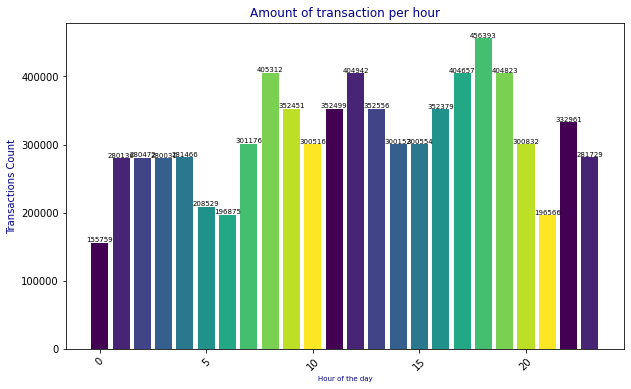

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(intervalcounts)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardhour['transaction_hour'], cardhour['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=7)
plt.title('Amount of transaction per hour', color='darkblue')
plt.xlabel('Hour of the day', color='darkblue', fontsize=7)
plt.ylabel('Transactions Count', color='darkblue')
plt.xticks(rotation=45)
plt.show()

Analyzing the previous graph, we can state that the graph exhibits a negative skewness, indicating that the majority of observations are concentrated in the afternoon, up until 23:00 of the day.



### Data Exploration - Quantitative variable - weekend_transaction

Let's now analyze our variable weekend_transaction, which is a binary variable defined as a Boolean indicating if the transaction took place on a weekend. The variable can take two values, 0 or 1, representing false or true. In practice, this means that if the value is false, the transaction occurred during the weekdays (Monday to Friday), and if the value is true, the transaction occurred during the weekend (Saturday or Sunday).

In [0]:
cardweekend= df.groupBy("weekend_transaction").count().toPandas()
cardweekend['relativevalue'] = round((cardweekend['count'] / cardweekend['count'].sum())*100,2)
cardweekend

,weekend_transaction,count,relativevalue
0,False,5554103,74.22
1,True,1929663,25.78


We can analyze that 74.22% of the transactions occur during the week, while only 25.78% occur during the weekend.

<command-4350573021961036>:3: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([0, 1], labels=["Weekday", "Weekend"], title="Day of the week", loc="best")


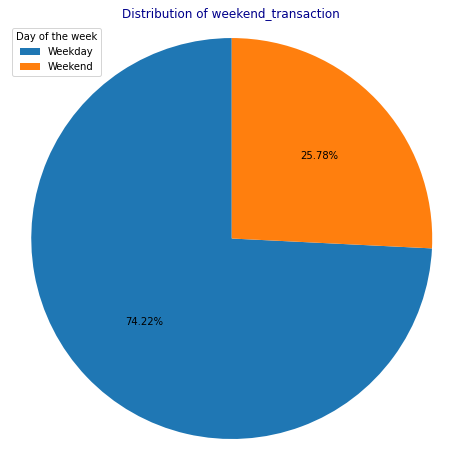

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardweekend['count'], autopct='%0.2f%%', startangle=90)
plt.legend([0, 1], labels=["Weekday", "Weekend"], title="Day of the week", loc="best")
plt.title("Distribution of weekend_transaction", color="Darkblue")
plt.axis('equal')
plt.show()

We have now completed the analysis of our quantitative variables, from which we removed one variable (amount) and created a new one (amount_euro) to ensure consistency in the units of measurement when analyzing our dataset. Many of our quantitative variables were binary variables, and performing statistical analysis, such as measures of dispersion and measures of central and non-central tendency, did not make much sense.

Looking at our qualitative variables, it's important to remember that the variables merchant_category, merchant_type, merchant, and currency have already been analyzed, and conclusions have already been drawn from them. These conclusions will be revisited at the end of the statistical analysis and dataset preparation for our classification task, with further analysis on the same.

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~
  - ~~weekend_transaction~~
- Qualitative variables
  - Transaction_id
  - customer_id
  - timestamp
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - country
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour





### Data Exploration - Quanlitative variable - Transaction_id

Looking at our variable Transaction_id, which is described as a unique identifier for each transaction, theoretically, the number of observations of this variable should correspond to the number of rows in our dataset (7483766). However, as we can observe in the command below, this is not the case.

In [0]:
cardTranid= df.groupBy("Transaction_id").count().toPandas()
cardTranid['relativevalue'] = round((cardTranid['count'] / cardTranid['count'].sum())*100,2)
cardTranid

,Transaction_id,count,relativevalue
0,TX_b9aa0845,1,0.0
1,TX_02ce11cd,1,0.0
2,TX_bfb752a1,1,0.0
3,TX_036e665b,1,0.0
4,TX_11dd29d3,1,0.0
...,...,...,...
7477301,TX_8f30ebbd,1,0.0
7477302,TX_9b48b94c,1,0.0
7477303,TX_ee99f95c,1,0.0
7477304,TX_09d87b13,1,0.0


As we can see, there are 7,477,306 observations instead of the expected 7,483,766, resulting in a difference of 6,460 values. These values are duplicated, thus losing the unique characteristic. However, upon analyzing the dataset, it appears that these values are not erratic, and there may be a justification for these discrepancies. It is necessary to isolate these values and analyze them separately to understand the cause.

In [0]:
cardTranidspark = df.groupBy("Transaction_id").count()
totalcount = cardTranidspark.agg(F.sum('count').alias('total_count')).collect()[0]['total_count']
totalcount

Out[49]: 7483766

In [0]:
df.count()

Out[50]: 7483766

In [0]:
cardTranid = cardTranid.sort_values(by="count", ascending=False).reset_index(drop=True)
cardTranid


,Transaction_id,count,relativevalue
0,TX_4e6f041a,3,0.0
1,TX_9c2d174f,3,0.0
2,TX_891636c5,3,0.0
3,TX_eef2ac1b,3,0.0
4,TX_706baadf,3,0.0
...,...,...,...
7477301,TX_fc192d42,1,0.0
7477302,TX_3a5b578f,1,0.0
7477303,TX_4288bc08,1,0.0
7477304,TX_92ea7167,1,0.0


In [0]:
cardTranid['count'].sum()

Out[52]: 7483766

Let's look at the values of the variable that are not unique. To do this, we will create a variable and apply a condition to our variable.

In [0]:
isolatedtransactions = cardTranid[cardTranid['count'] != 1]
isolatedtransactions

,Transaction_id,count,relativevalue
0,TX_4e6f041a,3,0.0
1,TX_9c2d174f,3,0.0
2,TX_891636c5,3,0.0
3,TX_eef2ac1b,3,0.0
4,TX_706baadf,3,0.0
...,...,...,...
6448,TX_d4dffe70,2,0.0
6449,TX_c468511f,2,0.0
6450,TX_b9500565,2,0.0
6451,TX_bf27da24,2,0.0


In [0]:
isolatedtransactions['count'].sum()

Out[54]: 12913

In [0]:
isolatedtransactions2 = cardTranid[cardTranid['count'] == 1]
isolatedtransactions2

,Transaction_id,count,relativevalue
6453,TX_b9132ae7,1,0.0
6454,TX_545835b1,1,0.0
6455,TX_34406b1c,1,0.0
6456,TX_aea9f8ea,1,0.0
6457,TX_31e58020,1,0.0
...,...,...,...
7477301,TX_fc192d42,1,0.0
7477302,TX_3a5b578f,1,0.0
7477303,TX_4288bc08,1,0.0
7477304,TX_92ea7167,1,0.0


In [0]:
isolatedtransactions2['count'].sum()

Out[56]: 7470853

In [0]:
isolatedtransactions['count'].sum()+isolatedtransactions2['count'].sum()

Out[57]: 7483766

Let's see the relationship of these duplicated values with our variable is_fraud, as one of the hypotheses raised (H1) is that these duplications could represent bank frauds.

In [0]:
cardTranidspark = spark.createDataFrame(cardTranid)
cardTranidwithfraud = cardTranidspark.join(df.select("Transaction_id", "is_fraud").distinct(), on="Transaction_id", how="left")
cardTranidwithfraudpd = cardTranidwithfraud.toPandas()
cardTranidwithfraudpd

,Transaction_id,count,relativevalue,is_fraud
0,TX_0000089b,1,0.0,False
1,TX_00000c29,1,0.0,False
2,TX_000011bf,1,0.0,False
3,TX_000014c9,1,0.0,True
4,TX_00003d9b,1,0.0,False
...,...,...,...,...
7479313,TX_fffda70a,1,0.0,False
7479314,TX_fffe1dfd,1,0.0,False
7479315,TX_fffeda6c,1,0.0,False
7479316,TX_ffff62d4,1,0.0,False


In [0]:
isolatedtransactionsfraud = cardTranidwithfraudpd[cardTranidwithfraudpd['count'] != 1]
isolatedtransactionsfraud

,Transaction_id,count,relativevalue,is_fraud
2877,TX_00d2002e,2,0.0,False
3104,TX_00e462d9,2,0.0,True
3224,TX_00ef4da7,2,0.0,False
6993,TX_0207138f,2,0.0,True
6994,TX_0207138f,2,0.0,False
...,...,...,...,...
7473876,TX_f3c723ad,2,0.0,False
7477763,TX_fc70817d,2,0.0,False
7477808,TX_fc8e7ada,2,0.0,False
7479223,TX_ffc7fc2b,2,0.0,False


Isolating our variable with the target variable, we will identify within the values of Transaction_id that are not unique, which ones correspond to fraud, in order to understand if there is a direct relationship with our hypothesis 1.

In [0]:
isolatedtransactionsfraud['is_fraud'].value_counts()

Out[60]: False    6207
True     2258
Name: is_fraud, dtype: int64

<command-4350573021961064>:3: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([0, 1], labels=["Is not Fraud", "Is Fraud"], loc="best")


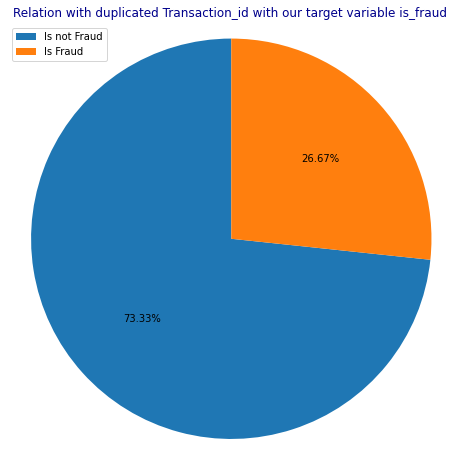

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(isolatedtransactionsfraud['is_fraud'].value_counts(), autopct='%0.2f%%', startangle=90)
plt.legend([0, 1], labels=["Is not Fraud", "Is Fraud"], loc="best")
plt.title("Relation with duplicated Transaction_id with our target variable is_fraud", color="Darkblue")
plt.axis('equal')
plt.show()

There are indeed some repeated transactions that represent fraud, for example, in the previous table, the transaction ID TX_ffc7fc2b has two observations, one of which is fraud and the other is not. However, there is no direct relationship with our hypothesis, meaning that there is no direct link between repeated transactions and fraud.
Another hypothesis raised was that a transaction could be associated with two different customer IDs. For example, when purchasing a complete trip with both a hotel and a flight, in practice, it is a single transaction that could be associated with two different services. we gonna call it H2 (hypotses 2)

In [0]:
cardTranidspark2 = spark.createDataFrame(cardTranid)
cardTranidwithfraud2 = cardTranidspark2.join(df.select("Transaction_id", "customer_id" ).distinct(), on="Transaction_id", how="left")
cardTranidwithfraudpd2 = cardTranidwithfraud2.toPandas()
cardTranidwithfraudpd2

,Transaction_id,count,relativevalue,customer_id
0,TX_0000089b,1,0.0,CUST_80380
1,TX_00000c29,1,0.0,CUST_36225
2,TX_000011bf,1,0.0,CUST_35918
3,TX_000014c9,1,0.0,CUST_49417
4,TX_00003d9b,1,0.0,CUST_76680
...,...,...,...,...
7483760,TX_fffda70a,1,0.0,CUST_70982
7483761,TX_fffe1dfd,1,0.0,CUST_36311
7483762,TX_fffeda6c,1,0.0,CUST_99865
7483763,TX_ffff62d4,1,0.0,CUST_36442


In [0]:
isolatedtransactionsfraud2 = cardTranidwithfraudpd2[cardTranidwithfraudpd2['count'] != 1]
isolatedtransactionsfraud2

,Transaction_id,count,relativevalue,customer_id
3004,TX_00d2002e,2,0.0,CUST_80426
3005,TX_00d2002e,2,0.0,CUST_16909
3245,TX_00e462d9,2,0.0,CUST_94391
3246,TX_00e462d9,2,0.0,CUST_33212
3375,TX_00ef4da7,2,0.0,CUST_55313
...,...,...,...,...
7481751,TX_fc8e7ada,2,0.0,CUST_99944
7482894,TX_fe84dde3,2,0.0,CUST_72533
7482895,TX_fe84dde3,2,0.0,CUST_39721
7483646,TX_ffc7fc2b,2,0.0,CUST_97553



The previous analysis allowed us to confirm that the transaction is indeed unique, but it can correspond to different customer IDs. In other words, our hypothesis 2 is valid.
Looking at the large dispersion of values, it is most likely that this variable does not influence the classification of our target variable. The best approach would be to eliminate it from our dataset.

### Data Exploration - Quanlitative variable - customer_id

Looking at the qualitative variable customer_id, which is defined as a unique identifier for each customer in the dataset, we would expect this value to be unique. However, as we saw with the last variable, there could be cases of duplicated values. Let's explore this further to understand the distribution and any potential implications for our analysis.

In [0]:
cardCustid= df.groupBy("customer_id").count().toPandas()
cardCustid['relativevalue'] = round((cardCustid['count'] / cardCustid['count'].sum())*100,2)
cardCustid = cardCustid.sort_values(by="count", ascending=False).reset_index(drop=True)
cardCustid

,customer_id,count,relativevalue
0,CUST_91730,4015,0.05
1,CUST_24836,3767,0.05
2,CUST_87928,3756,0.05
3,CUST_81009,3744,0.05
4,CUST_77434,3728,0.05
...,...,...,...
4864,CUST_41011,1000,0.01
4865,CUST_87130,1000,0.01
4866,CUST_81207,1000,0.01
4867,CUST_70135,1000,0.01



Looking at the two variables analyzed earlier, customer_id and transaction_id, we can conclude that there are 4,869 customers across the 7,483,765 transactions. Some transactions may have more than one customer, and notably, our customers appear in multiple transactions. This implies that both customer_id and transaction_id can be unique variables in the sense of identifying individual transactions and customers, but they are not unique within the dataset.

In [0]:
cardCustidspark = spark.createDataFrame(cardCustid)
cardCustidsparkwithmc = cardCustidspark.join(df.select("customer_id", "merchant_type", "merchant_category", "merchant").distinct(), on="customer_id", how="left")
cardCustidsparkwithmcpd = cardCustidsparkwithmc.toPandas()
cardCustidsparkwithmcpd.sort_values(by="count", ascending=False).reset_index(drop=True)

,customer_id,count,relativevalue,merchant_type,merchant_category,merchant
0,CUST_91730,4015,0.05,medical,Healthcare,Medical Center
1,CUST_91730,4015,0.05,premium,Restaurant,Capital Grille
2,CUST_91730,4015,0.05,pharmacy,Healthcare,Walgreens
3,CUST_91730,4015,0.05,online,Education,Skillshare
4,CUST_91730,4015,0.05,airlines,Travel,Southwest
...,...,...,...,...,...,...
511142,CUST_65274,1000,0.01,online,Education,edX
511143,CUST_65274,1000,0.01,fast_food,Restaurant,Wendy's
511144,CUST_65274,1000,0.01,premium,Restaurant,Ruth's Chris
511145,CUST_65274,1000,0.01,physical,Grocery,Safeway


The most observed value is CUST_91730, with around 4,015 occurrences across various transactions in multiple purchase categories. It is also interesting to see if this customer is related to our target variable (fraud). For instance, there could be a customer who only makes fraudulent transactions, and if that's the case, eliminating this value could be a consideration in our analysis.

In [0]:
customerfraudstatus = df.groupBy("customer_id").agg(F.sum(F.when(F.col("is_fraud") == True, 1).otherwise(0)).alias("count_true"), F.sum(F.when(F.col("is_fraud") == False, 1).otherwise(0)).alias("count_false"))
customersonlytruefraud = customerfraudstatus.filter(F.col("count_false") == 0)
customersonlytruefraudpd = customersonlytruefraud.toPandas()
customersonlytruefraudpd.sort_values(by="count_true", ascending=False).reset_index(drop=True)


,customer_id,count_true,count_false


To check for customers who only have non-fraudulent transactions (is_fraud equals False), you can modify the approach we used previously. Instead of filtering for customers with only True values, we will filter for customers with only False values in the is_fraud column.

In [0]:
customerfraudstatus = df.groupBy("customer_id").agg(F.sum(F.when(F.col("is_fraud") == True, 1).otherwise(0)).alias("count_true"), F.sum(F.when(F.col("is_fraud") == False, 1).otherwise(0)).alias("count_false"))
customersonlynonfraud = customerfraudstatus.filter(F.col("count_true") == 0)
customersonlynonfraudpd = customersonlynonfraud.toPandas()
customersonlynonfraudpd.sort_values(by="count_false", ascending=False).reset_index(drop=True)


,customer_id,count_true,count_false


Our output was also empty, which means that there is no customer who has all their transactions classified as non-fraudulent.

Let's take an update on our variables

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~
  - ~~weekend_transaction~~
- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - timestamp
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - country
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour

### Data Exploration - Quanlitative variable - timestamp

According to the definition, our timestamp variable can be described as the date and time of the transaction

In [0]:
cardtimestamp= df.groupBy("timestamp").count().toPandas()
cardtimestamp['relativevalue'] = round((cardtimestamp['count'] / cardtimestamp['count'].sum())*100,2)
cardtimestamp = cardtimestamp.sort_values(by="count", ascending=False).reset_index(drop=True)
cardtimestamp

,timestamp,count,relativevalue
0,2024-10-28 10:33:34.182954+00:00,2,0.0
1,2024-10-26 12:42:49.546446+00:00,2,0.0
2,2024-10-23 07:29:30.447871+00:00,2,0.0
3,2024-10-12 16:09:49.108205+00:00,2,0.0
4,2024-10-18 13:48:43.356574+00:00,2,0.0
...,...,...,...
7483749,2024-10-20 13:56:31.779875+00:00,1,0.0
7483750,2024-10-20 13:56:28.940645+00:00,1,0.0
7483751,2024-10-20 13:55:42.084903+00:00,1,0.0
7483752,2024-10-20 13:55:28.246912+00:00,1,0.0


If we verify, there are operations that occur within the same time window, which are 12 in number. This is because our table has 7,483,754 entries, while it should have 7,483,766. The difference corresponds to duplicated values.

In [0]:
isolatedtransactionstimestamp = cardtimestamp[cardtimestamp['count'] != 1]
isolatedtransactionstimestamp

,timestamp,count,relativevalue
0,2024-10-28 10:33:34.182954+00:00,2,0.0
1,2024-10-26 12:42:49.546446+00:00,2,0.0
2,2024-10-23 07:29:30.447871+00:00,2,0.0
3,2024-10-12 16:09:49.108205+00:00,2,0.0
4,2024-10-18 13:48:43.356574+00:00,2,0.0
5,2024-10-05 13:00:41.198222+00:00,2,0.0
6,2024-10-02 01:21:49.529750+00:00,2,0.0
7,2024-09-30 07:52:58.184296+00:00,2,0.0
8,2024-09-30 14:06:15.602978+00:00,2,0.0
9,2024-10-11 19:49:43.509165+00:00,2,0.0


Let's see how these duplicated values behave according to our target variable, is_fraud.

In [0]:
duplicatedtimestamps = df.groupBy("timestamp").count().filter("count > 1")
duplicatedentries = df.join(duplicatedtimestamps, on="timestamp", how="inner")
duplicatedfraudanalysis = duplicatedentries.groupBy("is_fraud").count().show()


+--------+-----+
|is_fraud|count|
+--------+-----+
|    true|    4|
|   false|   20|
+--------+-----+



As we can see, only 4 of the duplicated values correspond to fraudulent values, while the remaining 20 correspond to non-fraudulent values. 
This variable is rich in information compacted into a single column, containing details such as year, month, day, hours, minutes, seconds, and timezone.
Before continuing the analysis of our qualitative variable timestamp, let's check its relationship with another variable already analyzed, transaction_hour. In fact, it seems that the information should be the same.
Looking at the previous analysis, it is possible that there is a direct connection between the variable `transaction_hour` and the hour present in our `timestamp` variable. We will analyze this further when we consider the statistical analysis of the hour.


In [0]:
cardtimestampspark = spark.createDataFrame(cardtimestamp)
cardtimestampsparkwithth = cardtimestampspark.join(df.select("timestamp", "transaction_hour").distinct(), on="timestamp", how="left")
cardtimestampsparkwiththpd = cardtimestampsparkwithth.toPandas()
cardtimestampsparkwiththpd

,timestamp,count,relativevalue,transaction_hour
0,2024-09-30 00:00:07.780617+00:00,1,0.0,0
1,2024-09-30 00:00:13.469333+00:00,1,0.0,0
2,2024-09-30 00:00:21.300404+00:00,1,0.0,0
3,2024-09-30 00:00:38.969788+00:00,1,0.0,0
4,2024-09-30 00:00:39.640275+00:00,1,0.0,0
...,...,...,...,...
7483749,2024-10-30 23:57:20.692466+00:00,1,0.0,23
7483750,2024-10-30 23:58:00.624808+00:00,1,0.0,23
7483751,2024-10-30 23:58:25.471889+00:00,1,0.0,23
7483752,2024-10-30 23:58:45.167783+00:00,1,0.0,23


From this variable, we can derive three variables: date, timezone, and time.

Within the date variable, we can further observe year, month, and day.

- Quantitative variables
(...)
- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - timestamp
    - year
    - Mounth
    - Day
    - Time
    - Timezone
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
(...)

Since we only want to analyze the information within the variable, we will create a copy of our dataframe and name it `df2`, where we will present the values referring to the variables we previously defined.

In [0]:
df2 = df.withColumn("year", split(col("timestamp"), "-")[0]) \
       .withColumn("month", split(col("timestamp"), "-")[1]) \
       .withColumn("day", split(split(col("timestamp"), " ")[0], "-")[2]) \
       .withColumn("time", split(col("timestamp"), " ")[1].substr(0, 15)) \
       .withColumn("timezone", split(col("timestamp"), "\\+")[1])

In [0]:
df2.select("timestamp", "year", "month", "day", "time", "timezone").show(truncate=False)

+--------------------------------+----+-----+---+---------------+--------+
|timestamp                       |year|month|day|time           |timezone|
+--------------------------------+----+-----+---+---------------+--------+
|2024-09-30 00:00:01.034820+00:00|2024|09   |30 |00:00:01.034820|00:00   |
|2024-09-30 00:00:01.764464+00:00|2024|09   |30 |00:00:01.764464|00:00   |
|2024-09-30 00:00:02.273762+00:00|2024|09   |30 |00:00:02.273762|00:00   |
|2024-09-30 00:00:02.297466+00:00|2024|09   |30 |00:00:02.297466|00:00   |
|2024-09-30 00:00:02.544063+00:00|2024|09   |30 |00:00:02.544063|00:00   |
|2024-09-30 00:00:03.050458+00:00|2024|09   |30 |00:00:03.050458|00:00   |
|2024-09-30 00:00:03.149440+00:00|2024|09   |30 |00:00:03.149440|00:00   |
|2024-09-30 00:00:06.295911+00:00|2024|09   |30 |00:00:06.295911|00:00   |
|2024-09-30 00:00:06.813965+00:00|2024|09   |30 |00:00:06.813965|00:00   |
|2024-09-30 00:00:07.105592+00:00|2024|09   |30 |00:00:07.105592|00:00   |
|2024-09-30 00:00:07.5833

Let's start by analyzing our created variable `timezone`. As we can see from the following code, its value is always `+00:00`, which means that all transactions occurred in the same timezone. Therefore, it is a variable that can be removed or not even created.


In [0]:
distincttimezones = df2.select("timezone").distinct()
distincttimezones.show()

+--------+
|timezone|
+--------+
|   00:00|
+--------+



Let's now analyze the variable `year`, which only presents one value, 2024. This means that, like the `timezone`, it is a variable that does not add value to our classification problem in the dataset.


In [0]:
distinctyear = df2.select("year").distinct()
distinctyear.show()

+----+
|year|
+----+
|2024|
+----+



Looking at our `month` variable, we can see that our dataset only contains information related to the months 09 and 10, meaning September and October.


In [0]:
distinctmonth = df2.select("month").distinct()
distinctmonth.show()

+-----+
|month|
+-----+
|   09|
|   10|
+-----+



Regarding the days, we have observations for all days of the month except for the 31st. This, combined with the previous observation, allows us to infer that the dataset only includes transactions from the 1st of September 2024 to the 30th of October 2024.

In [0]:
distinctday = df2.select("day").distinct()
distinctday = distinctday.orderBy("day")
distinctday.show(32)


+---+
|day|
+---+
| 01|
| 02|
| 03|
| 04|
| 05|
| 06|
| 07|
| 08|
| 09|
| 10|
| 11|
| 12|
| 13|
| 14|
| 15|
| 16|
| 17|
| 18|
| 19|
| 20|
| 21|
| 22|
| 23|
| 24|
| 25|
| 26|
| 27|
| 28|
| 29|
| 30|
+---+



The time variable is described through hours, minutes, seconds, and microseconds, following the logic HH:MM:SS.(microseconds).


In [0]:
distincttime = df2.select("time").distinct()
distincttime.show()

+---------------+
|           time|
+---------------+
|00:04:26.407686|
|00:05:01.881438|
|00:09:43.938757|
|00:10:32.466974|
|00:11:21.954621|
|00:14:32.025080|
|00:17:20.889377|
|00:18:26.757381|
|00:20:10.419249|
|00:21:06.705206|
|00:21:57.237311|
|00:22:19.012529|
|00:24:09.085712|
|00:24:39.685408|
|00:25:35.117591|
|00:32:31.776419|
|00:33:03.036065|
|00:36:06.047766|
|00:36:55.258367|
|00:37:46.127663|
+---------------+
only showing top 20 rows



Let's now analyze if the time in my `time` variable is directly related to the value of the previously analyzed quantitative variable `transaction_hour`. Logically, everything points to this being true, but before eliminating the variable, we want to be mathematically sure that this is the case.
The logic is to extract the hour value from the `time` variable in our dataset and compare it with the `transaction_hour` variable, displaying the values that are different. In other words, if there are any different values, they will be shown; if there are no differences, the table will be empty.



In [0]:
df2 = df2.withColumn("hour", substring(col("time"), 1, 2))
df2dif = df2.filter(col("hour") != col("transaction_hour"))
df2dif.select("hour", "transaction_hour").show()


+----+----------------+
|hour|transaction_hour|
+----+----------------+
+----+----------------+



In summary, the `timestamp` variable as it stands does not provide additional value in terms of reading and understanding our dataset. Therefore, we will split it into useful information. We observed that with respect to the timezone and year, the values are always the same (00:00 and 2024, respectively). Thus, we are only interested in the day, month, and year from this variable.

Additionally, we can conclude that the `transaction_hour` variable becomes redundant because it can be derived from the `time` variable, which we will create. As such, it will be eliminated.

So que can refresh our variables list

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~ (Changed)
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~ (eliminated)
  - ~~weekend_transaction~~
  - day
  - month
  - time (its classified as qualitative but we will treat that as quantitaive)
- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - ~~timestamp~~(Changed)
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - country
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour

In [0]:
df = df.withColumn("month", split(col("timestamp"), "-")[1]) \
       .withColumn("day", split(split(col("timestamp"), " ")[0], "-")[2]) \
       .withColumn("time", split(col("timestamp"), " ")[1].substr(0, 15))
df = df.drop("timestamp")
df = df.drop("transaction_hour")

If we look below, when we see the schema of our dataset, the variables created (month, day, and time) are still classified as strings (i.e., they should be classified as qualitative and not quantitative). However, in practice, they are actually quantitative. Looking at the logic of the described values, they are considered strings because, for example, in the "day" variable, the 9th day appears as 09.

We will convert the created variables to integers, except for the "time" variable, which we will address later.

In [0]:
df.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- card_number: long (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- merchant_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_size: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_present: boolean (nullable = true)
 |-- device: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- device_fingerprint: string (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- distance_from_home: long (nullable = true)
 |-- high_risk_merchant: boolean (nullable = true)
 |-- weekend_transaction: boolean (nullable = true)
 |-- velocity_last_hour: string (nullable = true)
 |-- is_fraud: boolean (nullable = true)
 |-- amounteuro: float (nullable = true)
 |-- month: string (nullable = true)


In [0]:
df=df.withColumn("month", col("month").cast("int")) \
    .withColumn("day", col("day").cast("int"))

By creating these new variables, we now have a dataset with 25 variables instead of the initial 24, while clearly maintaining the original number of rows. Currently, we have 16 qualitative variables and 9 quantitative variables.

In [0]:
dtypes = df.dtypes
dtype_counts = {}
for dtype in dtypes:
    dtype_name = dtype[1]
    if dtype_name in dtype_counts:
        dtype_counts[dtype_name] += 1
    else:
        dtype_counts[dtype_name] = 1
for dtype, count in dtype_counts.items():
    print(f"{dtype}: {count}")

string: 16
bigint: 2
boolean: 4
float: 1
int: 2


So let's get going with our variables analises

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~ (Changed)
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~ (eliminated)
  - ~~weekend_transaction~~
  - **day**
  - month
  - time (its classified as qualitative but we will treat that as quantitaive)
- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - ~~timestamp~~(Changed)
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - country
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour

Let's take the quantitative variable day and perform its statistical analysis.

### Data Exploration - Quantitative variable - day (NEW)

The day variable represents the day on which the transaction was made. As previously mentioned, it was created from an existing variable in the dataset called timestamp.

In [0]:
cardday= df.groupBy("day").count().toPandas()
cardday['relativevalue'] = round((cardday['count'] / cardday['count'].sum())*100,2)
cardday.sort_values(by="day", ascending=True).reset_index(drop=True)

,day,count,relativevalue
0,1,241813,3.23
1,2,242718,3.24
2,3,241204,3.22
3,4,241328,3.22
4,5,241086,3.22
5,6,241880,3.23
6,7,241345,3.22
7,8,240890,3.22
8,9,241514,3.23
9,10,241228,3.22


After analyzing the table of absolute and relative values, we noticed that the 30th day of September and November 2024 was the day with the most transactions, representing about 6.45%. On the other hand, the 19th day of these same months had the fewest observations, around 3.21%. Overall, the transactions are distributed quite equitably across the days of the months. Due to the large number of days, it is not worth performing a graphical analysis of this variable. However, based on the interpretation so far, we can associate that since the last day of the month (the 30th) has the highest number of observations, if we analyze the "day" variable without considering the month in which it occurred, we can say that the distribution is negatively skewed, as the values will be higher on the 30th.

### Data Exploration - Quantitative variable - month (NEW)

The mont variable represents the Setember or November month, represented by 9 or 10 respectly, on which the transaction was made. As previously mentioned, it was created from an existing variable in the dataset called timestamp.

In [0]:
cardmonth= df.groupBy("month").count().toPandas()
cardmonth['relativevalue'] = round((cardmonth['count'] / cardmonth['count'].sum())*100,2)
cardmonth

,month,count,relativevalue
0,9,240937,3.22
1,10,7242829,96.78


As we can see from the previous analysis, the majority of the observations were made in the month of November, accounting for approximately 96.78% of the observations, while the month of September only registers the remaining 3.22%.
Given the low number of observations recorded in September, it makes sense to analyze this variable along with our target variable. This could help determine if the September records should be eliminated, especially if they do not provide significant value for the classification task.



In [0]:
cardmonth9 = df[df['month'] == 9]
filter9m=cardmonth9.select('is_fraud', 'month')
filter9m = filter9m.groupBy('is_fraud').count()
filter9m.toPandas()

,is_fraud,count
0,True,47880
1,False,193057


Given that there are still 47,880 fraud observations, it doesn't make sense to remove the observations from September, as we would be eliminating values that are relevant for classifying our target variable.



### Data Exploration - Quantitative variable - time (NEW)

The time variable represents the hour,minutes,seconds and microseconds on which the transaction was made. As previously mentioned, it was created from an existing variable in the dataset called timestamp.

In [0]:
cardtime= df.groupBy("time").count().toPandas()
cardtime['relativevalue'] = round((cardtime['count'] / cardtime['count'].sum())*100,2)
cardtime

,time,count,relativevalue
0,00:04:26.407686,1,0.0
1,00:05:01.881438,1,0.0
2,00:09:43.938757,1,0.0
3,00:10:32.466974,1,0.0
4,00:11:21.954621,1,0.0
...,...,...,...
7483444,23:52:07.517286,1,0.0
7483445,23:54:16.152734,1,0.0
7483446,23:55:33.309589,1,0.0
7483447,23:55:51.975951,1,0.0



Looking at the previous point, the time variable in the described format is not useful for analysis as it is. However, this variable might contain relevant information, so we will need to categorize it into time intervals, for example, [00:00 - 02:00], and count the number of transactions that occurred within each interval.

To do this, we will create a new dataframe
 so that we don't directly modify our dataset, and we will apply REGEX, specifically a Spark function [regexp_replace](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.regexp_replace.html), to convert the format from HH:MM:SS to HHMMSS.

 tambem olhando ainda para a nossa variável apenas nos interessa as horas minutos e segundos para fazermos os intervalos assim iremos utiizar uma função designada de [substr](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.substr.html) (substring) para filtrar apenas pelos 6 nprimeiros digitos

In [0]:
df2 = df2.withColumn("timeonly", substring(regexp_replace(col("time"), "[:.]", ""), 1, 4))
df2.select("time", "timeonly").show()

+---------------+--------+
|           time|timeonly|
+---------------+--------+
|00:00:01.034820|    0000|
|00:00:01.764464|    0000|
|00:00:02.273762|    0000|
|00:00:02.297466|    0000|
|00:00:02.544063|    0000|
|00:00:03.050458|    0000|
|00:00:03.149440|    0000|
|00:00:06.295911|    0000|
|00:00:06.813965|    0000|
|00:00:07.105592|    0000|
|00:00:07.583345|    0000|
|00:00:07.780617|    0000|
|00:00:10.429065|    0000|
|00:00:10.953172|    0000|
|00:00:12.862261|    0000|
|00:00:13.469333|    0000|
|00:00:13.519027|    0000|
|00:00:14.494264|    0000|
|00:00:16.465739|    0000|
|00:00:18.957278|    0000|
+---------------+--------+
only showing top 20 rows



In [0]:
df2 = df2.withColumn("timeonly", col("timeonly").cast(IntegerType()))
df2 = df2.withColumn('interval', 
                     when((col('timeonly') >= 0) & (col('timeonly') <= 300), "[0000-0300]")
                     .when((col('timeonly') > 300) & (col('timeonly') <= 600), "]0300-0600]")
                     .when((col('timeonly') > 600) & (col('timeonly') <= 900), "]0600-0900]")
                     .when((col('timeonly') > 900) & (col('timeonly') <= 1200), "]0900-1200]")
                     .when((col('timeonly') > 1200) & (col('timeonly') <= 1500), "]1200-1500]")
                     .when((col('timeonly') > 1500) & (col('timeonly') <= 1800), "]1500-1800]")
                     .when((col('timeonly') > 1800) & (col('timeonly') <= 2100), "]1800-2100]")
                     .when((col('timeonly') > 2100) & (col('timeonly') <= 2400), "]2100-2400]"))


In [0]:
cardtimeinterval= df2.groupBy("interval").count().toPandas()
cardtimeinterval['relativevalue'] = round((cardtimeinterval['count'] / cardtimeinterval['count'].sum())*100,2)
cardtimeinterval = cardtimeinterval.sort_values(by="interval", ascending=True).reset_index(drop=True)
cardtimeinterval

,interval,count,relativevalue
0,[0000-0300],721070,9.64
1,]0300-0600],768591,10.27
2,]0600-0900],906020,12.11
3,]0900-1200],1006422,13.45
4,]1200-1500],1055712,14.11
5,]1500-1800],1060066,14.16
6,]1800-2100],1157982,15.47
7,]2100-2400],807903,10.80


Having created our dataset with the interval variable, we are now ready to create our charts to analyze them. From the previous table, we can note that the mode, meaning the most observed value, is the interval between 18:00 and 21:00, with about 15.53% of the transactions.

On the other hand, the least observed value is the interval between 00:00 and 03:00, with 9.57% of the observations.

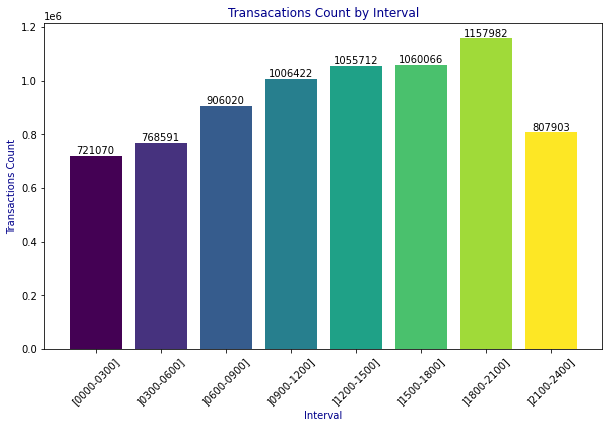

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(cardtimeinterval)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardtimeinterval['interval'], cardtimeinterval['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=10)
plt.title('Transacations Count by Interval', color='darkblue')
plt.xlabel('Interval', color='darkblue')
plt.ylabel('Transactions Count', color='darkblue')
plt.xticks(rotation=45)
plt.show()

Analyzing the previous chart, we can state that the skewness of the variable is negative, indicating that transactions are more frequently carried out during the late afternoon and evening periods.

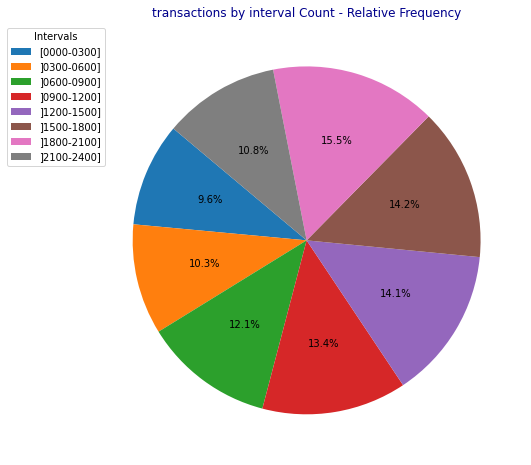

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardtimeinterval['relativevalue'], autopct='%1.1f%%', startangle=140)
plt.title('transactions by interval Count - Relative Frequency', color='darkblue')
plt.legend(cardtimeinterval['interval'], title='Intervals', loc='upper left', bbox_to_anchor=(-0.2, 1))
plt.show()

We can also state that, to some extent, the transactions are almost identical across the periods of the day in terms of relative value, with a margin of 4.9% between the least observed and the most observed values.
Let's make a status update of the work done so far.

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~ (Changed)
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~ (eliminated)
  - ~~weekend_transaction~~
  - ~~day~~
  - ~~month~~
  - ~~time~~ (its classified as qualitative but we will treat that as quantitaive)
- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - ~~timestamp~~(Changed)
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - **country**
  - city
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour

So let's continue with our variables analises




### Data Exploration - Quanlitative variable - country

In the analysis of the qualitative variable "country," we can describe it as the country where the transaction occurred.

Using the command below, we were able to identify 12 countries that would correspond to the "currency" variable (which we eliminated). These countries are as follows:

- Russia
- Singapore
- Germany
- France
- Nigeria
- USA
- Mexico
- UK
- Canada
- Brazil
- Japan
- Australia

In [0]:
cardcountry= df.groupBy("country").count().toPandas()
cardcountry['relativevalue'] = round((cardcountry['count'] / cardcountry['count'].sum())*100,2)
cardcountry

,country,count,relativevalue
0,Russia,793730,10.61
1,Singapore,588668,7.87
2,Germany,524464,7.01
3,France,541287,7.23
4,Nigeria,849840,11.36
5,USA,500060,6.68
6,Mexico,785704,10.50
7,UK,538493,7.20
8,Canada,532632,7.12
9,Brazil,804800,10.75


Through the analysis of the previous data, we can observe that the country with the highest number of transactions is Nigeria, accounting for approximately 11.36% of the observations. On the other hand, Australia registers the lowest number of transaction observations, with only 6.64%.


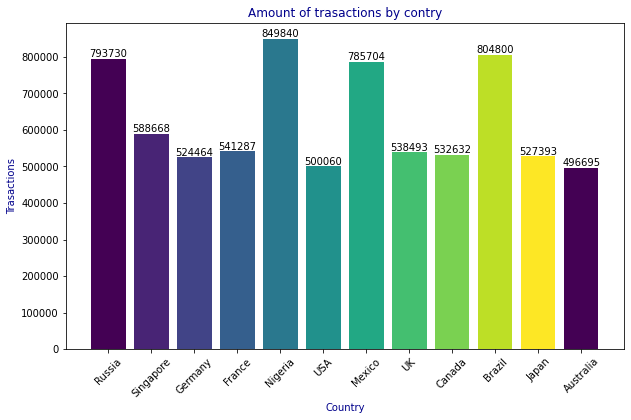

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(intervalcounts)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardcountry['country'], cardcountry['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=10)
plt.title('Amount of trasactions by contry', color='darkblue')
plt.xlabel('Country', color='darkblue')
plt.ylabel('Trasactions', color='darkblue')
plt.xticks(rotation=45)
plt.show()

Analyzing the previous graph, we can further note that the countries with the highest number of transactions are **Nigeria**, **Brazil**, **Russia**, and **Mexico**, standing out from the other countries, which maintain a closer relationship among themselves in terms of transaction numbers.

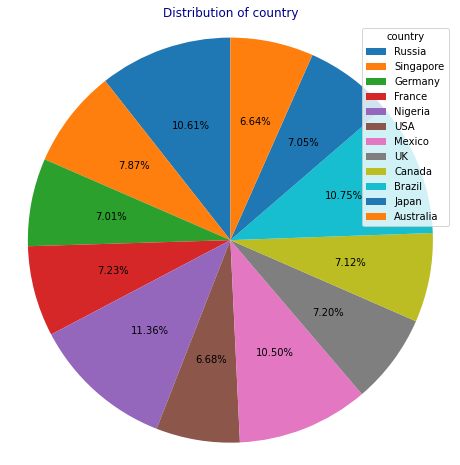

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardcountry['count'], autopct='%0.2f%%', startangle=90)
plt.legend(cardcountry['country'], title="country", loc="best")
plt.title("Distribution of country", color="Darkblue")
plt.axis('equal')
plt.show()

We will now proceed to the analysis of our next quantitative variable.




### Data Exploration - Quanlitative variable - city

The next variable to be analyzed is the **city** variable, defined as *where the transaction took place*. Observing the following table of absolute and relative frequencies, we notice that it only describes American cities. The vast majority, approximately 93.32% of the observations, are classified as **Unknown City**, while all remaining observations correspond to American cities. The sum of these observations matches the number of transactions recorded for the country **USA**.

In [0]:
cardcity= df.groupBy("city").count().toPandas()
cardcity['relativevalue'] = round((cardcity['count'] / cardcity['count'].sum())*100,2)
cardcity

,city,count,relativevalue
0,Phoenix,50333,0.67
1,Dallas,50126,0.67
2,San Antonio,50079,0.67
3,Philadelphia,49914,0.67
4,Los Angeles,49494,0.66
5,San Diego,50425,0.67
6,Unknown City,6983706,93.32
7,Chicago,49912,0.67
8,San Jose,50015,0.67
9,Houston,49957,0.67


In [0]:
countardcity = cardcity[cardcity['city'] != "Unknown City"]
countardcity['count'].sum()

Out[97]: 500060

Given that this variable does not add significant value regarding the classification of our target variable—since it only contains information related to a single country, and this information is statistically minor (6.68%)—the decision will be to eliminate the **city** variable.

In [0]:
df = df.drop("city")

So let's refresh our variable list with the lasts updates

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~ (Changed)
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~ (eliminated)
  - ~~weekend_transaction~~
  - ~~day~~
  - ~~month~~
  - ~~time~~ (its classified as qualitative but we will treat that as quantitaive)
- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - ~~timestamp~~(Changed)
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - ~~country~~
  - ~~city~~(eliminated)
  - city_size
  - card_type
  - device
  - channel
  - device_fingerprint
  - ip_address
  - velocity_last_hour




### Data Exploration - Quanlitative variable - city_size

The variable `city_size` is described as the size of the city (e.g., medium, large). Observing the table below, which shows absolute and relative frequencies, we note that this variable has only two distinct values: `large` and `medium`.

- The most frequent observation, accounting for approximately **97.34%** of the total transactions, corresponds to the value `medium`.  
- On the other hand, the value `large` has only **199,168 observations**, representing **2.66%** of the transactions.

In [0]:
cardcitysize= df.groupBy("city_size").count().toPandas()
cardcitysize['relativevalue'] = round((cardcitysize['count'] / cardcitysize['count'].sum())*100,2)
cardcitysize

,city_size,count,relativevalue
0,medium,7284598,97.34
1,large,199168,2.66


With the low frequency of the value `large`, the tendency is to disregard this variable concerning its capacity to classify our target variable. However, we will still examine how this variable behaves in relation to our target variable.


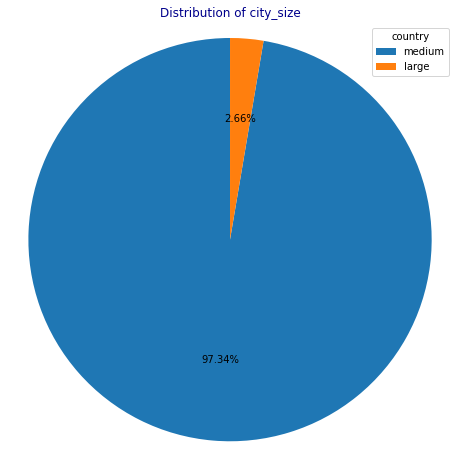

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardcitysize['count'], autopct='%0.2f%%', startangle=90)
plt.legend(cardcitysize['city_size'], title="country", loc="best")
plt.title("Distribution of city_size", color="Darkblue")
plt.axis('equal')
plt.show()

In [0]:
cardcitysizeL = df[df['city_size'] == 'large']
filterL=cardcitysizeL.select('is_fraud', 'city_size')
filterL = filterL.groupBy('is_fraud').count()
filterL.toPandas()

,is_fraud,count
0,True,14855
1,False,184313


Analyzing the previous charts and tables, this variable is a candidate for elimination, as the true `is_fraud` values within cities classified as `large` barely reach 10%. This may indicate that this variable has a very low correlation factor with our target variable. Therefore, we will retain it until the correlation analysis between the dataset variables is performed.



### Data Exploration - Quanlitative variable - card_type

By definition, the variable `card_type` can be described as the type of card used (e.g., Basic Credit, Gold Credit). As we can see in the table below, this variable presents 5 values:

- Gold Credit
- Platinum Credit
- Premium Debit
- Basic Credit
- Basic Debit

These values exhibit an almost homogeneous distribution among the observations, with the most observed being `Basic Debit` with 20.69% of the observations and the least observed being `Basic Credit` with 18.91% of the observations.

In [0]:
cardcardtype= df.groupBy("card_type").count().toPandas()
cardcardtype['relativevalue'] = round((cardcardtype['count'] / cardcardtype['count'].sum())*100,2)
cardcardtype

,card_type,count,relativevalue
0,Gold Credit,1447260,19.34
1,Platinum Credit,1533013,20.48
2,Premium Debit,1539661,20.57
3,Basic Credit,1415469,18.91
4,Basic Debit,1548363,20.69


In [0]:
cardcardtype['count'].sum()

Out[103]: 7483766

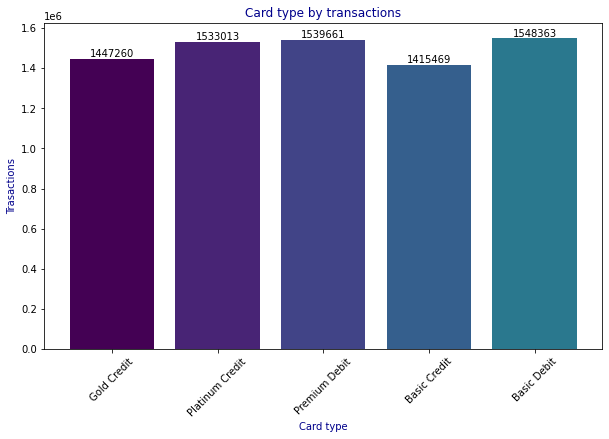

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(intervalcounts)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardcardtype['card_type'], cardcardtype['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=10)
plt.title('Card type by transactions', color='darkblue')
plt.xlabel('Card type', color='darkblue')
plt.ylabel('Trasactions', color='darkblue')
plt.xticks(rotation=45)
plt.show()

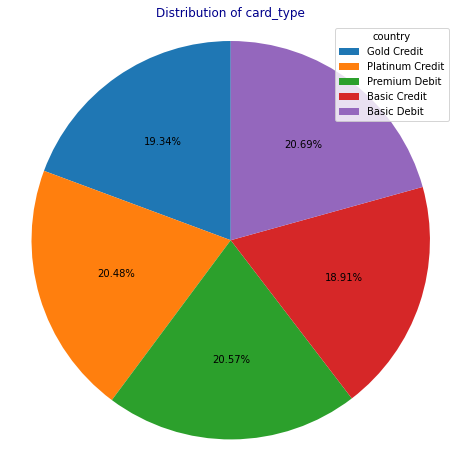

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardcardtype['count'], autopct='%0.2f%%', startangle=90)
plt.legend(cardcardtype['card_type'], title="country", loc="best")
plt.title("Distribution of card_type", color="Darkblue")
plt.axis('equal')
plt.show()

### Data Exploration - Quanlitative variable - device

According to the definition of the `device` variable, it can be described as the device used for the transaction (e.g., Chrome, iOS App, NFC Payment). The devices observed are:

- iOS App
- Firefox
- NFC Payment
- Safari
- Magnetic Stripe
- Android App
- Chip Reader
- Chrome
- Edge

The most observed value is `Edge` with 15.90% of the observations, while the least observed is `NFC Payment` with 2.89% of the observations.


In [0]:
carddevice= df.groupBy("device").count().toPandas()
carddevice['relativevalue'] = round((carddevice['count'] / carddevice['count'].sum())*100,2)
carddevice

,device,count,relativevalue
0,iOS App,1143461,15.28
1,Firefox,1120952,14.98
2,NFC Payment,216519,2.89
3,Safari,1120245,14.97
4,Magnetic Stripe,217204,2.90
5,Android App,1126117,15.05
6,Chip Reader,217324,2.90
7,Chrome,1132384,15.13
8,Edge,1189560,15.90


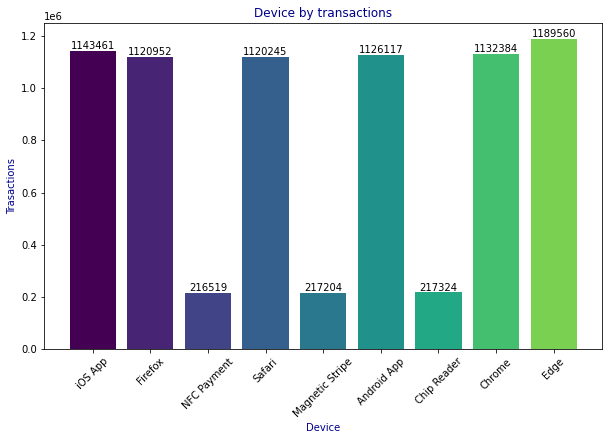

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(intervalcounts)))
plt.figure(figsize=(10, 6))
bars = plt.bar(carddevice['device'], carddevice['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=10)
plt.title('Device by transactions', color='darkblue')
plt.xlabel('Device', color='darkblue')
plt.ylabel('Trasactions', color='darkblue')
plt.xticks(rotation=45)
plt.show()

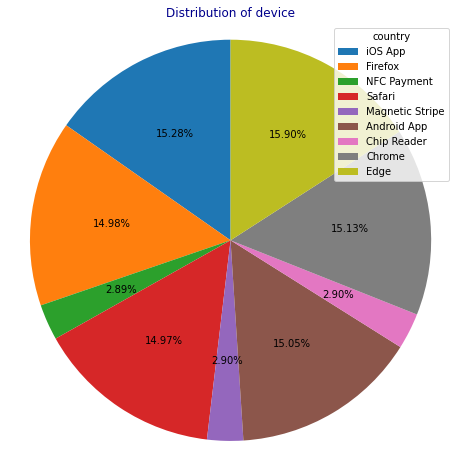

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(carddevice['count'], autopct='%0.2f%%', startangle=90)
plt.legend(carddevice['device'], title="country", loc="best")
plt.title("Distribution of device", color="Darkblue")
plt.axis('equal')
plt.show()

By analyzing the previous charts, we can detect that almost all devices have approximately the same value, with the exception of three: NFC Payment, Magnetic Stripe, and Chip Reader.



### Data Exploration - Quanlitative variable - channel

The next qualitative variable we will analyze is **channel**, which is described as the type of channel used for the transaction (web, mobile, POS). It has three possible values, as stated in its definition:
- **web**
- **POS**
- **mobile**

The most observed value for the **channel** variable is **web**, with 60.97% of the observations, while the least observed value is **POS**, with only 8.70% of the observations.

In [0]:
cardchannel= df.groupBy("channel").count().toPandas()
cardchannel['relativevalue'] = round((cardchannel['count'] / cardchannel['count'].sum())*100,2)
cardchannel

,channel,count,relativevalue
0,pos,651047,8.70
1,mobile,2269578,30.33
2,web,4563141,60.97


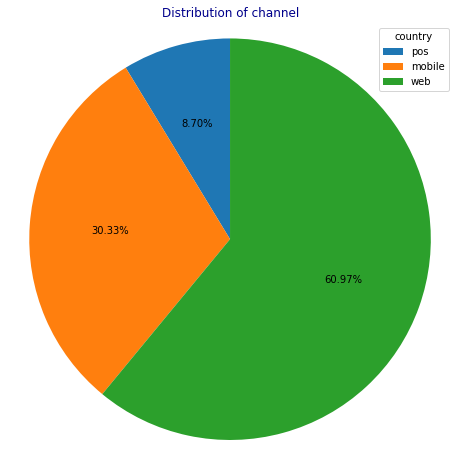

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardchannel['count'], autopct='%0.2f%%', startangle=90)
plt.legend(cardchannel['channel'], title="country", loc="best")
plt.title("Distribution of channel", color="Darkblue")
plt.axis('equal')
plt.show()

Before we move on to the next variable, let's take stock of the situation with our variables.

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~ (Changed)
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~ (eliminated)
  - ~~weekend_transaction~~
  - ~~day~~
  - ~~month~~
  - ~~time~~ (its classified as qualitative but we will treat that as quantitaive)
- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - ~~timestamp~~(Changed)
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - ~~country~~
  - ~~city~~(eliminated)
  - ~~city_size~~
  - ~~card_type~~
  - ~~device~~
  - ~~channel~~
  - device_fingerprint
  - ip_address
  - velocity_last_hour

### Data Exploration - Quanlitative variable - device_fingerprint

Our qualitative variable device_fingerprint can be defined as the unique fingerprint for the device used in the transaction. However, as the description suggests, this should be unique, which is not the case, as we can see in the following table.

In [0]:
carddf= df.groupBy("device_fingerprint").count().toPandas()
carddf['relativevalue'] = round((carddf['count'] / carddf['count'].sum())*100,2)
carddf

,device_fingerprint,count,relativevalue
0,36aa9a690e0e1905eca3595e5b2f3f56,622,0.01
1,b695228a79acd77906b0c870cbf6313f,1512,0.02
2,5544d1f00dbcb1a9ddb60e33a9028d7d,1570,0.02
3,8dfe5e4e442d4bd7a446be887802cc81,1506,0.02
4,f0dd8bb9d87e475e547fe97016309cf4,3,0.00
...,...,...,...
785457,0c5395559cf3f5e4545e7203afe38ee4,1,0.00
785458,985060fcc1eee1aa54a46c189f765fb1,1,0.00
785459,4b79edd356a1fcb0ee4d5173ac9d8d6f,1,0.00
785460,deff006a18f31fa17f22549ee0eefa73,1,0.00


In [0]:
carddff=carddf[carddf['count'] > 1]
carddff

,device_fingerprint,count,relativevalue
0,36aa9a690e0e1905eca3595e5b2f3f56,622,0.01
1,b695228a79acd77906b0c870cbf6313f,1512,0.02
2,5544d1f00dbcb1a9ddb60e33a9028d7d,1570,0.02
3,8dfe5e4e442d4bd7a446be887802cc81,1506,0.02
4,f0dd8bb9d87e475e547fe97016309cf4,3,0.00
...,...,...,...
785367,0aff7eb9394d187f8ca3a21050830ec3,2,0.00
785385,050bad81f21db71bdcd45b79bb308bc0,2,0.00
785390,a309d38db83fa0b90b923a3f38a3eb30,2,0.00
785407,ecc745900000136738f3bc574ae233c6,2,0.00


In [0]:
carddff['count'].sum()

Out[113]: 7148775

Since there are several non-unique values, statistical analysis of them is impossible to represent in graphs or extract other values of interest for the analysis of the variable.




### Data Exploration - Quanlitative variable - ip_address

According to the definition, "IP address associated with the transaction" which describes our qualitative variable **IP**, it seems that after analyzing the table below, there are repeated IP addresses. As with other variables presented, the values are very dispersed and unique, with about 7,477,187 different values, making it difficult to define an appropriate statistical analysis.

In [0]:
cardip= df.groupBy("ip_address").count().toPandas()
cardip['relativevalue'] = round((cardip['count'] / cardip['count'].sum())*100,2)
cardip

,ip_address,count,relativevalue
0,169.93.28.6,1,0.0
1,224.36.3.140,1,0.0
2,31.122.13.66,1,0.0
3,139.30.187.9,1,0.0
4,105.191.224.228,1,0.0
...,...,...,...
7477182,80.106.246.248,1,0.0
7477183,71.32.211.13,1,0.0
7477184,140.150.32.4,1,0.0
7477185,15.86.228.224,1,0.0


Let's eliminate our variavble ip_adress

In [0]:
df = df.drop("ip_address")

There are functional APIs like [ipstack](https://ipstack.com/signup/free) that could be used to create a function and, from the IP, gather information such as the city, country, and even the service provider. However, since these resources have limited usage and require paid features to bypass those restrictions, we decided not to extract the IP information. Nevertheless, I believe it could be a valuable addition, potentially allowing the dataset to be significantly restructured in that case.

We decided not to consider the variable for our classification problem.



### Data Exploration - Quanlitative variable - velocity_last_hour

The qualitative variable `velocity_last_hour` can be defined as a string containing the following information separated by a colon, describing the transaction metrics for the customer in the last hour:

- **num_transactions**: Number of transactions made by the customer in the last hour.
- **total_amount**: Total amount spent in the last hour.
- **unique_merchants**: Count of unique merchants in the last hour.
- **unique_countries**: Count of unique countries in the last hour.
- **max_single_amount**: Maximum amount of a single transaction in the last hour.



This information is too relevant based on its description to be analyzed as a single variable. Therefore, the variable has been divided into 5 separate variables:

In [0]:
cardvlh= df.groupBy("velocity_last_hour").count().toPandas()
cardvlh['relativevalue'] = round((cardvlh['count'] / cardvlh['count'].sum())*100,2)
cardvlh

,velocity_last_hour,count,relativevalue
0,"{'num_transactions': 628, 'total_amount': 1708...",1,0.0
1,"{'num_transactions': 576, 'total_amount': 5629...",1,0.0
2,"{'num_transactions': 1433, 'total_amount': 423...",1,0.0
3,"{'num_transactions': 1987, 'total_amount': 501...",1,0.0
4,"{'num_transactions': 872, 'total_amount': 2360...",1,0.0
...,...,...,...
7483735,"{'num_transactions': 0, 'total_amount': 1230.6...",1,0.0
7483736,"{'num_transactions': 1, 'total_amount': 105633...",1,0.0
7483737,"{'num_transactions': 0, 'total_amount': 199492...",1,0.0
7483738,"{'num_transactions': 1, 'total_amount': 27085....",1,0.0


Then, let's add these variables to our dataset.

- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~ (Changed)
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~ (eliminated)
  - ~~weekend_transaction~~
  - ~~day~~
  - ~~month~~
  - ~~time~~ (its classified as qualitative but we will treat that as quantitaive)
  - **num_transactions**
  - total_amount 
  - unique_merchants
  - unique_countries
  - max_single_amount

- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - ~~timestamp~~(Changed)
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - ~~country~~
  - ~~city~~(eliminated)
  - ~~city_size~~
  - ~~card_type~~
  - ~~device~~
  - ~~channel~~
  - ~~device_fingerprint~~
  - ~~ip_address~~(eliminated)
  - ~~velocity_last_hour~~(Changed)

In [0]:
df = df.withColumn('num_transactions', F.split(F.split(df['velocity_last_hour'], ':').getItem(1), ',').getItem(0)) \
       .withColumn('total_amount', F.split(F.split(df['velocity_last_hour'], ':').getItem(2), ',').getItem(0)) \
       .withColumn('unique_merchants', F.split(F.split(df['velocity_last_hour'], ':').getItem(3), ',').getItem(0)) \
       .withColumn('unique_countries', F.split(F.split(df['velocity_last_hour'], ':').getItem(4), ',').getItem(0)) \
       .withColumn('max_single_amount', F.split(F.split(df['velocity_last_hour'], ':').getItem(5), ',').getItem(0))

Let's eliminate our variable velocity_last_hour

In [0]:
df = df.drop("velocity_last_hour")

In [0]:
df.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- card_number: long (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- merchant_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city_size: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_present: boolean (nullable = true)
 |-- device: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- device_fingerprint: string (nullable = true)
 |-- distance_from_home: long (nullable = true)
 |-- high_risk_merchant: boolean (nullable = true)
 |-- weekend_transaction: boolean (nullable = true)
 |-- is_fraud: boolean (nullable = true)
 |-- amounteuro: float (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- num_transactions: string (nullable = true)
 |-- to

### Data Exploration - Quantitative variable - num_transactions (NEW)

As the definition says, num_transactions is described as the "Number of transactions made by the customer in the last hour

We will perform the statistical analysis of the variable, but for that, we need to convert our variable `num_transactions` to int.

In [0]:
df=df.withColumn("num_transactions", col("num_transactions").cast(DoubleType()))
cardvnt= df.groupBy("num_transactions").count().toPandas()
cardvnt['relativevalue'] = round((cardvnt['count'] / cardvnt['count'].sum())*100,2)
cardvnt.sort_values(by="num_transactions", ascending=True).reset_index(drop=True)

,num_transactions,count,relativevalue
0,0.0,32051,0.43
1,1.0,30998,0.41
2,2.0,30211,0.40
3,3.0,28955,0.39
4,4.0,27854,0.37
...,...,...,...
3533,3851.0,1,0.00
3534,3854.0,1,0.00
3535,3914.0,1,0.00
3536,3935.0,1,0.00


Now, let's use our functions to determine the measures of dispersion and the measures of central and non-central tendency.

In [0]:
calculardispersao(df,"num_transactions").toPandas()

,Medidas,Valores
0,Variance,152956.43
1,Coefficient of Variation (CV),95.59
2,Range,3962.00
3,IQR,494.00


Regarding our dispersion measures, we can say that the total range is 3962, which corresponds to the distance between the minimum observed value of 0 and the maximum observed value of 3962.

Our interquartile range (IQR) is 494. The high variance presented, as well as the elevated coefficient of variation indicates that the concentration of observations is concentrated around one extreme.


In [0]:
calcularmedidastendencia(df,"num_transactions").toPandas()

,Estatísticas,Valores
0,Média,409.14
1,Desvio Padrão,391.10
2,Mínimo,0.00
3,Máximo,3962.00
4,Assimetria,1.54
5,Moda,0.00
6,Mediana,292.00
7,1º Quantil,106.00
8,3º Quantil,600.00


As observed earlier, our mean tends to be on the lower end, with an average value of 409.14. The most frequent value, corresponding to the mode, is 0. Based on our quartiles, we can affirm the following:

- 25% of the observations have a value less than or equal to 106.
- 50% of the observations have a value less than or equal to 292.
- Finally, 75% of the observations have a value less than or equal to 600.

To facilitate graphical analysis of the variable, we will create observation intervals of 500. This will allow us to better visualize the distribution of the data and understand the concentration of values across different ranges.



In [0]:
df2 = df.withColumn('interval',when((col('num_transactions') >= 0) & (col('num_transactions') < 500), "[0000-0500[")\
                     .when((col('num_transactions') >= 500) & (col('num_transactions') < 1000), "[0500-1000[")\
                     .when((col('num_transactions') >= 1000) & (col('num_transactions') < 1500), "[1000-1500[")\
                     .when((col('num_transactions') >= 1500) & (col('num_transactions') < 2000), "[1500-2000[")\
                     .when((col('num_transactions') >= 2000) & (col('num_transactions') < 2500), "[2000-2500[")\
                     .when((col('num_transactions') >= 2500) & (col('num_transactions') < 3000), "[2500-3000[")\
                     .when((col('num_transactions') >= 3000) & (col('num_transactions') < 3500), "[3000-3500[")\
                     .when((col('num_transactions') >= 3500) & (col('num_transactions') < 4000), "[3500-4000["))

In [0]:
cardvntinterval= df2.groupBy("interval").count().toPandas()
cardvntinterval['relativevalue'] = round((cardvntinterval['count'] / cardvntinterval['count'].sum())*100,2)
cardvntinterval = cardvntinterval.sort_values(by="interval", ascending=True).reset_index(drop=True)
cardvntinterval

,interval,count,relativevalue
0,[0000-0500[,5093842,68.07
1,[0500-1000[,1730986,23.13
2,[1000-1500[,537417,7.18
3,[1500-2000[,92045,1.23
4,[2000-2500[,19574,0.26
5,[2500-3000[,8083,0.11
6,[3000-3500[,1714,0.02
7,[3500-4000[,105,0.00


As previously defined, the concentration of values is in the first interval [0000-0500[, with 68.07% of the observations. The interval [3500-4000[ is the least observed, with approximately 0% relative frequency, corresponding to 105 absolute observations.

This is visually confirmed with the graph below, which shows the positive skewness, supported by the previous table. According to our central and non-central tendency measures, the skewness value is 1.54.


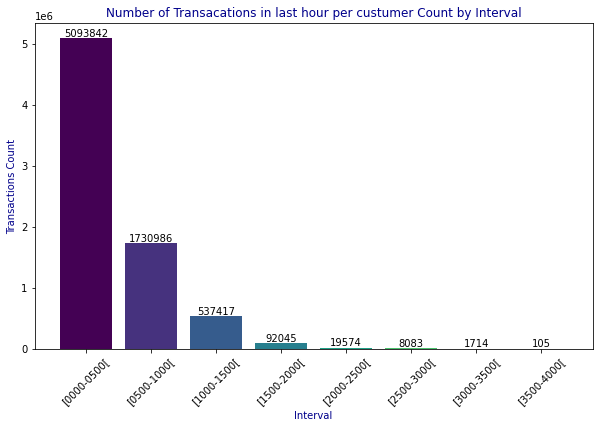

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(cardvntinterval)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardvntinterval['interval'], cardvntinterval['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=10)
plt.title('Number of Transacations in last hour per custumer Count by Interval', color='darkblue')
plt.xlabel('Interval', color='darkblue')
plt.ylabel('Transactions Count', color='darkblue')
plt.xticks(rotation=45)
plt.show()


The following pie chart supports our observation that the values for this variable are concentrated in values below 1000 transactions per customer in the last hour, with 91.2% of the observations falling into this category.


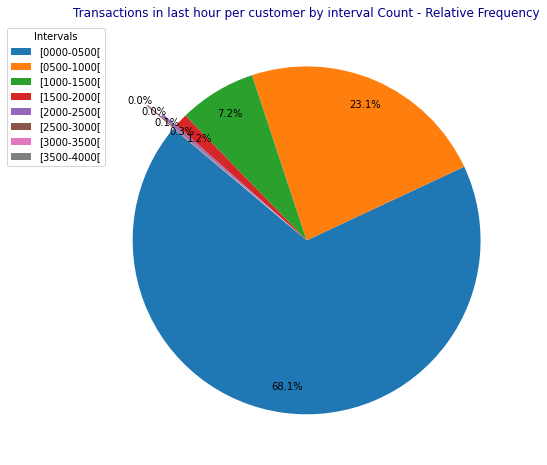

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardvntinterval['relativevalue'], autopct='%1.1f%%', startangle=140, pctdistance=0.85, explode=(0,0,0,0,0.1,0.2,0.3,0.4))
plt.title('Transactions in last hour per customer by interval Count - Relative Frequency', color='darkblue')
plt.legend(cardvntinterval['interval'], title='Intervals', loc='upper left', bbox_to_anchor=(-0.2, 1))
plt.show()

### Data Exploration - Quantitative variable - total_amount (NEW)

Regarding our variable `total_amount`, and since we have converted our `amount` variable to euros, we will choose to eliminate and not analyze this variable. This is because the `total_amount` variable may contain information with different units of measurement (e.g., USD), which could affect the accuracy of our classification.


- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~ (Changed)
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~ (eliminated)
  - ~~weekend_transaction~~
  - ~~day~~
  - ~~month~~
  - ~~time~~ (its classified as qualitative but we will treat that as quantitaive)
  - ~~num_transactions~~
  - ~~total_amount~~(eliminated)
  - **unique_merchants**
  - unique_countries
  - max_single_amount

- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - ~~timestamp~~(Changed)
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - ~~country~~
  - ~~city~~(eliminated)
  - ~~city_size~~
  - ~~card_type~~
  - ~~device~~
  - ~~channel~~
  - ~~device_fingerprint~~
  - ~~ip_address~~(eliminated)
  - ~~velocity_last_hour~~(Changed)





In [0]:
df = df.drop("total_amount")

### Data Exploration - Quantitative variable - unique_merchants (NEW)

The definition of our variable `unique_merchants` is described as the "Count of unique merchants in the last hour."
We were able to identify 106 different values representing the count of unique customers in the last hour.

In [0]:
df=df.withColumn("unique_merchants", col("unique_merchants").cast(DoubleType()))
cardvum = df.groupBy("unique_merchants").count().toPandas()
cardvum['relativevalue'] = round((cardvum['count'] / cardvum['count'].sum())*100,2)
cardvum.sort_values(by="unique_merchants", ascending=True).reset_index(drop=True)

,unique_merchants,count,relativevalue
0,0.0,32051,0.43
1,1.0,31277,0.42
2,2.0,30897,0.41
3,3.0,29908,0.40
4,4.0,29106,0.39
...,...,...,...
101,101.0,223533,2.99
102,102.0,275983,3.69
103,103.0,365133,4.88
104,104.0,583626,7.80


As we can see in the table below, the range of the variable is 105, corresponding to the difference between the observed minimum of 0 and the observed maximum of 105. With an interquartile range of 40, this indicates that the values might be highly concentrated.

In [0]:
calculardispersao(df,"unique_merchants").toPandas()

,Medidas,Valores
0,Variance,928.60
1,Coefficient of Variation (CV),38.08
2,Range,105.00
3,IQR,40.00


The average value of the data is 80.02, which indicates the central tendency of the distribution, with the standard deviation getting the value of 30.47, that indicates a moderate spread of the data around the mean.
The skewness value of -1.17 suggests a negatively skewed distribution, meaning that the data has a tail on the left side, with more values concentrated towards the higher end (negative assimetry).
The mode is 105.00, indicating that the most frequent value in the dataset is 105 unique merchants.
The median is 95.00, which is the middle value of the distribution when sorted, indicating that half of the observations fall below 95.00.
The first quartile (Q1) is 64.00, meaning that 25% of the values are less than or equal to 64.
The third quartile (Q3) is 104.00, meaning that 75% of the values are less than or equal to 104.


In [0]:
calcularmedidastendencia(df,"unique_merchants").toPandas()

,Estatísticas,Valores
0,Média,80.02
1,Desvio Padrão,30.47
2,Mínimo,0.00
3,Máximo,105.00
4,Assimetria,-1.17
5,Moda,105.00
6,Mediana,95.00
7,1º Quantil,64.00
8,3º Quantil,104.00


To facilitate graphical analysis of the variable, we will create observation intervals of 15. This will allow us to better visualize the distribution of the data and understand the concentration of values across different ranges.

In [0]:
df2 = df.withColumn('interval', 
                    when((col('unique_merchants') >= 0) & (col('unique_merchants') < 15), "[0-15[")\
                    .when((col('unique_merchants') >= 15) & (col('unique_merchants') < 30), "[15-30[")\
                    .when((col('unique_merchants') >= 30) & (col('unique_merchants') < 45), "[30-45[")\
                    .when((col('unique_merchants') >= 45) & (col('unique_merchants') < 60), "[45-60[")\
                    .when((col('unique_merchants') >= 60) & (col('unique_merchants') < 75), "[60-75[")\
                    .when((col('unique_merchants') >= 75) & (col('unique_merchants') < 90), "[75-90[")\
                    .when((col('unique_merchants') >= 90) & (col('unique_merchants') <= 105), "[90-105]"))


As we can see in the following table, the values are concentrated in the higher intervals, which justifies the previously mentioned negative skewness. The most observed interval, with 56.74% of the observations, is [90-105], while the least observed interval, [15-30[, accounts for only 5.27% of the observations.


In [0]:
cardvuminterval= df2.groupBy("interval").count().toPandas()
cardvuminterval['relativevalue'] = round((cardvuminterval['count'] / cardvuminterval['count'].sum())*100,2)
cardvuminterval = cardvuminterval.sort_values(by="interval", ascending=True).reset_index(drop=True)
cardvuminterval

,interval,count,relativevalue
0,[0-15[,424905,5.68
1,[15-30[,394570,5.27
2,[30-45[,420454,5.62
3,[45-60[,485558,6.49
4,[60-75[,611096,8.17
5,[75-90[,900695,12.04
6,[90-105],4246488,56.74


As we can see in the following table, the values are concentrated in the higher intervals, which justifies the previously mentioned negative skewness. The most observed interval, with 56.74% of the observations, is [90-105], while the least observed interval, [15-30[, accounts for only 5.27% of the observations.


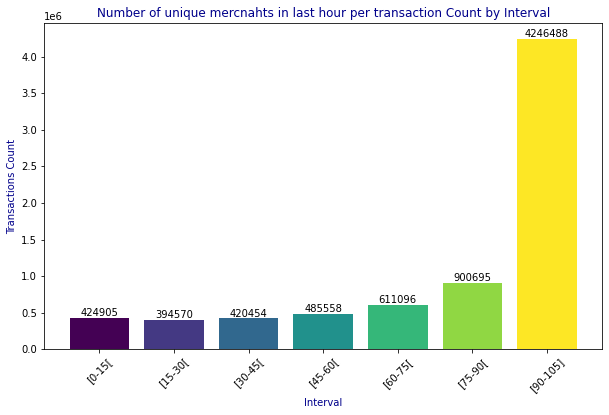

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(cardvuminterval)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardvuminterval['interval'], cardvuminterval['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=10)
plt.title('Number of unique mercnahts in last hour per transaction Count by Interval', color='darkblue')
plt.xlabel('Interval', color='darkblue')
plt.ylabel('Transactions Count', color='darkblue')
plt.xticks(rotation=45)
plt.show()

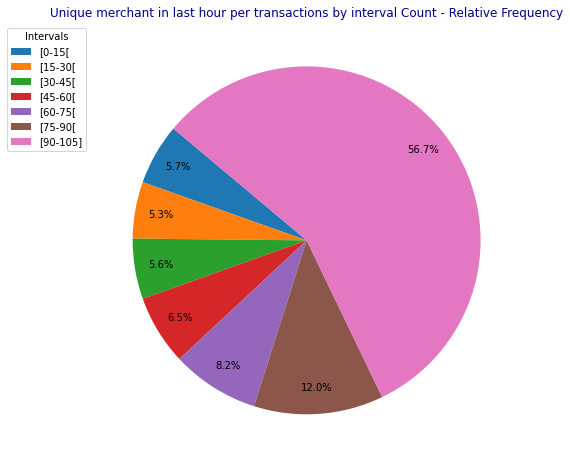

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardvuminterval['relativevalue'], autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.title('Unique merchant in last hour per transactions by interval Count - Relative Frequency', color='darkblue')
plt.legend(cardvuminterval['interval'], title='Intervals', loc='upper left', bbox_to_anchor=(-0.2, 1))
plt.show()

### Data Exploration - Quantitative variable - unique_countries (NEW)

We will analyze our qualitative variable `unique_countries`, which is defined as the **Count of unique countries in the last hour**. It consists of 13 observations ranging from 0 to 12, representing the count of unique countries in the last hour for the customer. 

- The most frequent observation is **12 countries**, with **67.20%** of the records.  
- The least frequent observation is **0 countries**, with only **0.43%** of the records.


In [0]:
df=df.withColumn("unique_countries", col("unique_countries").cast(DoubleType()))
cardvuc = df.groupBy("unique_countries").count().toPandas()
cardvuc['relativevalue'] = round((cardvuc['count'] / cardvuc['count'].sum())*100,2)
cardvuc.sort_values(by="unique_countries", ascending=True).reset_index(drop=True)

,unique_countries,count,relativevalue
0,0.0,32051,0.43
1,1.0,81372,1.09
2,2.0,96650,1.29
3,3.0,106118,1.42
4,4.0,116073,1.55
5,5.0,129812,1.73
6,6.0,150079,2.01
7,7.0,179020,2.39
8,8.0,221102,2.95
9,9.0,278632,3.72


According to the previously defined maximum and minimum values, we have an amplitude of 12, with the IQR (Interquartile Range) being 1. This indicates a concentration of values within a narrow range in the dataset.

- With a Variance of 6.85 meaning a moderate level of dispersion around the mean.
- The relatively high CV (24.55) indicates a higher level of dispersion relative to the mean, suggesting more variability in the data.


In [0]:
calculardispersao(df,"unique_countries").toPandas()

,Medidas,Valores
0,Variance,6.85
1,Coefficient of Variation (CV),24.55
2,Range,12.00
3,IQR,1.00



As observed in the table below, the data shows the following characteristics:
- The average value is 10.66, indicating that the data is relatively skewed towards higher values due to the mode (12.00) and median(12.00) being close to the maximum. that justifies the relatively low standard deviation, because that the most of the data points are clustered around the mean.
- The negative skewness suggests a significant concentration of values at the higher end, with the distribution having a long tail on the lower side (negative assimetry).
- The first quartile being 11.00 shows that 25% of the data points fall below this value, suggesting that a large portion of the dataset lies within the higher range of values.
- The third quartile being 12.00 further supports the concentration of values near the maximum, with 75% of the data points falling below or at the maximum value of 12.


In [0]:
calcularmedidastendencia(df,"unique_countries").toPandas()

,Estatísticas,Valores
0,Média,10.66
1,Desvio Padrão,2.62
2,Mínimo,0.00
3,Máximo,12.00
4,Assimetria,-2.22
5,Moda,12.00
6,Mediana,12.00
7,1º Quantil,11.00
8,3º Quantil,12.00


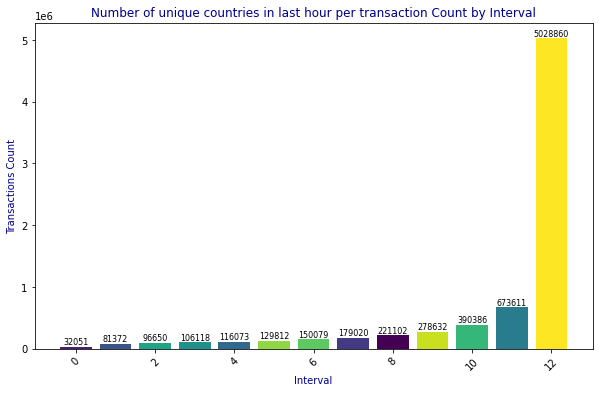

In [0]:
colors = plt.cm.viridis(np.linspace(0, 1, len(cardvuc)))
plt.figure(figsize=(10, 6))
bars = plt.bar(cardvuc['unique_countries'], cardvuc['count'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,str(height), ha='center', va='bottom', fontsize=8)
plt.title('Number of unique countries in last hour per transaction Count by Interval', color='darkblue')
plt.xlabel('Interval', color='darkblue')
plt.ylabel('Transactions Count', color='darkblue')
plt.xticks(rotation=45)
plt.show()

With the graphs above and below, we can confirm the predominance of observations related to 12 countries with transactions in the last hour. This indicates a strong preponderance of these observations, as they account for a significant portion of the dataset. The concentration of values towards the higher end further emphasizes this dominance.


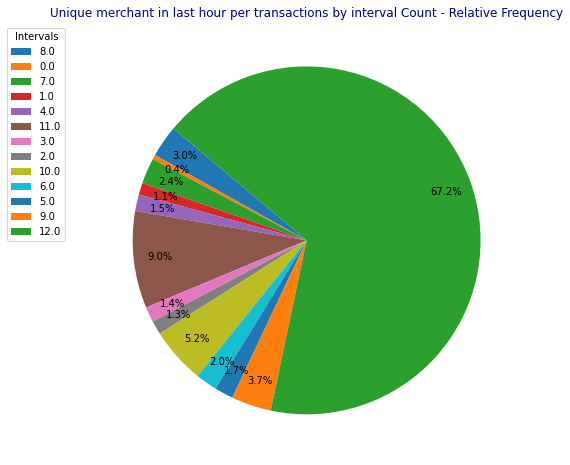

In [0]:
plt.figure(figsize=(8, 8))
plt.pie(cardvuc['relativevalue'], autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.title('Unique merchant in last hour per transactions by interval Count - Relative Frequency', color='darkblue')
plt.legend(cardvuc['unique_countries'], title='Intervals', loc='upper left', bbox_to_anchor=(-0.2, 1))
plt.show()

### Data Exploration - Quantitative variable - max_single_amount (NEW)

Our quantitative variable `max_single_amount` is described as the maximum amount of a single transaction in the last hour. It has 150,633 unique values, and like the `total_amount` variable, its unit of measurement can vary (e.g., Euro, US Dollar, Canadian Dollar, etc.). Therefore, we have decided not to consider it.

Nevertheless, a correction was applied to the initial regex as it was the last part of the string, which included a closing curly brace "}". A REGEX function was used to remove it.


In [0]:
df = df.withColumn('max_single_amount', F.regexp_replace(df['max_single_amount'], r'\}$', ''))
cardvmsc = df.groupBy("max_single_amount").count().toPandas()
cardvmsc['relativevalue'] = round((cardvmsc['count'] /cardvmsc['count'].sum())*100,2)
cardvmsc

,max_single_amount,count,relativevalue
0,3177113.643560527,603,0.01
1,3455513.1108747055,922,0.01
2,866848.4765626626,9,0.00
3,1693558.7849513395,142,0.00
4,1864144.27785299,685,0.01
...,...,...,...
150627,19.277900920963194,1,0.00
150628,518.6882627764079,1,0.00
150629,76018.35863721321,1,0.00
150630,5378.666588155085,1,0.00


In [0]:
df = df.drop("max_single_amount")

##Data Quality Verification

Our dataset was an enriched dataset with both quantitative and qualitative variables. Initially, we had a dataset composed of twenty-four variables distributed across our dataset collection.
Since we carried out our statistical analysis on our dataset, we created some variables, resulting from the analysis of both quantitative and qualitative variables present in our dataset. This creation was done according to some rules that were explained earlier.



- Quantitative variables
  - ~~is_fraud (Target variable)~~
  - ~~card_number~~
  - ~~amounteuro~~ (Changed)
  - ~~card_present~~
  - ~~distance_from_home~~
  - ~~high_risk_merchant~~
  - ~~transaction_hour~~ (eliminated)
  - ~~weekend_transaction~~
  - ~~day~~
  - ~~month~~
  - ~~time~~ (its classified as qualitative but we will treat that as quantitaive)
  - ~~num_transactions~~
  - ~~total_amount~~(eliminated)
  - ~~unique_merchants~~
  - ~~unique_countries~~
  - ~~max_single_amount~~(eliminated)

- Qualitative variables
  - ~~Transaction_id~~
  - ~~customer_id~~
  - ~~timestamp~~(Changed)
  - ~~merchant_category~~
  - ~~merchant_type~~
  - ~~merchant~~
  - ~~currency~~
  - ~~country~~
  - ~~city~~(eliminated)
  - ~~city_size~~
  - ~~card_type~~
  - ~~device~~
  - ~~channel~~
  - ~~device_fingerprint~~
  - ~~ip_address~~(eliminated)
  - ~~velocity_last_hour~~(Changed)

With the conclusion of our exploratory data analysis, our current status can be summarized in the following table:

| **Variable**            |*Action taken or future action*                                                                 |
|--------------------------|-----------------------------------------------------------------|
| **Transaction_id**|Depending of the correlation with our target variable this one can be Eliminated as the variable holds no statistical value for determining our target variable |
| **customer_id**|Depending of the correlation with our target variable this one can be Eliminated as the variable holds no statistical value for determining our target variable |
| **card_number**          |                                                                 |
| **timestamp**            |Replace by **day**, **month**, **year**, **time** and **timezone**|
| **merchant_category**    |                                                                 |
| **merchant_type**        |                                                                 |
| **merchant**             |                                                                 |
| ~~**amount**~~|Replace by **amounteuro**                                                                 |
| **currency**             |Depending of the correlation with our target variable this one can be Eliminated as the variable holds no statistical value for determining our target variable|
| **country**              |                                                                 |
| ~~**city**~~                |Eliminated as the variable holds no statistical value for determining our target variable.|
| **city_size**            |Depending of the correlation with our target variable this one can be Eliminated as the variable holds no statistical value for determining our target variable|
| **card_type**            |                                                                 |
| **card_present**         |Depending of the correlation with our target variable this one can be Eliminated as the variable holds no statistical value for determining our target variable|
| **device**               |                                                                 |
| **channel**|                                                                 |
| **device_fingerprint**   |                                                                 |
| ~~**ip_address**~~|Eliminated as the variable holds no statistical value for determining our target variable.|
| **distance_from_home**   |                                                                 |
| **high_risk_merchant**   |                                                                 |
| ~~**transaction_hour**~~     | Eliminated as it can be derived from the variable 'time'.    |
| **weekend_transaction**  |                                                                 |
| **day**  |                                                                 |
| **month**  |                                                                 |
| ~~**year**~~  |Eliminated as the variable holds no statistical value for determining our target variable.|
| ~~**timezone**~~  |Eliminated as the variable holds no statistical value for determining our target variable.  |
| **time**  |                                                                 |
| ~~**velocity_last_hour**~~|Replace by **total_amount**, **unique_merchants**, **unique_countries**, **max_single_amount** and **num_transactions**|
| **num_transactions**     |                                       |
| ~~**total_amount**~~        |Eliminated because we converted our financial data to euros, which does not align with this information.|
| **unique_merchants**     |                                     |
| **unique_countries**                         |                                   |
| ~~**max_single_amount**~~ |Eliminated because we converted our financial data to euros, which does not align with this information.|
| **is_fraud**             |Target Variable     |


In [0]:
df.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- card_number: long (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- merchant_type: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city_size: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_present: boolean (nullable = true)
 |-- device: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- device_fingerprint: string (nullable = true)
 |-- distance_from_home: long (nullable = true)
 |-- high_risk_merchant: boolean (nullable = true)
 |-- weekend_transaction: boolean (nullable = true)
 |-- is_fraud: boolean (nullable = true)
 |-- amounteuro: float (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- num_transactions: double (nullable = true)
 |-- un

#Data Preparation

Data that was repeated or rows that were duplicated also didn’t exist. Therefore, we considered the preparation of our initial dataset complete and continued with it as is.




##Data Selection

In terms of data selection, we initially used our dataset as we conducted the statistical analysis throughout the work. There were variables we eliminated, and there were variables we considered as candidates for elimination at the end of our dataset. Later on, we will assess whether, based on their correlation with our target variable, it makes sense to eliminate these variables or not.
After all the statistical work performed on our initial dataset, here is the code that shows the number of variables of each type remaining in our dataset.

In [0]:
dtypes = df.dtypes
dtype_counts = {}
for dtype in dtypes:
    dtype_name = dtype[1]
    if dtype_name in dtype_counts:
        dtype_counts[dtype_name] += 1
    else:
        dtype_counts[dtype_name] = 1
for dtype, count in dtype_counts.items():
    print(f"{dtype}: {count}")

string: 13
bigint: 2
boolean: 4
float: 1
int: 2
double: 3


Currently, we have 25 variables, of which 13 are qualitative variables and 12 are quantitative variables, as described in the following graph.

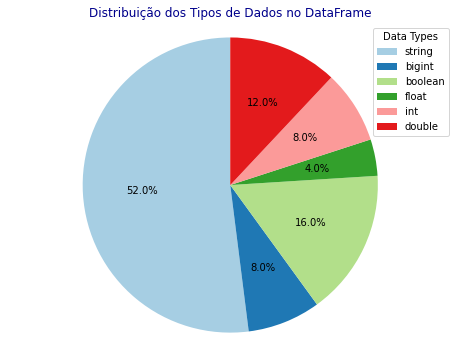

In [0]:
plt.figure(figsize=(8, 6))
plt.pie(list(dtype_counts.values()), autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.legend(list(dtype_counts.keys()), title="Data Types", loc="best")
plt.axis('equal')
plt.title('Distribuição dos Tipos de Dados no DataFrame', color="Darkblue")
plt.show()

### Studying the Correlation with the Target Variable

Now, let's study the correlation between the variables and our target variable. To do so, we need to ensure that all the variables are in proper condition to be processed.

We gonna start to transform the categorical variables into numeric values using PySpark's [StringIndexer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html).

After that we will transformed the categorical variables into numbers, we will combine all the numeric and indexed variables into a single feature vector. This vector will be used to calculate the correlation.



In [0]:
df = df.withColumn("card_present", col("card_present").cast("int")) \
       .withColumn("high_risk_merchant", col("high_risk_merchant").cast("int")) \
       .withColumn("weekend_transaction", col("weekend_transaction").cast("int")) \
       .withColumn("is_fraud", col("is_fraud").cast("int"))
categoricalcolumns = ['merchant_category', 'merchant_type', 'currency', 'country', 'city_size','card_type', 'device', 'channel', 'device_fingerprint']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categoricalcolumns]
numericalcolumns = ['num_transactions', 'unique_merchants', 'unique_countries', 'distance_from_home','amounteuro', 'month', 'day'] + [col + "_index" for col in categoricalcolumns]
numericalcolumns += ['card_present', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']                    
pipeline = Pipeline(stages=indexers)
dfindexed = pipeline.fit(df).transform(df)
assembler = VectorAssembler(inputCols=numericalcolumns, outputCol="features")
dfassembled = assembler.transform(dfindexed)

Now we will calculate the correlation matrix using the [Correlation.corr](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.stat.Correlation.html) function from PySpark and transform it in a [heatmap](https://stackoverflow.com/questions/55546467/how-to-plot-correlation-heatmap-when-using-pysparkdatabricks). Since the following command takes a long time to execute, we will comment it out.

In [0]:
#dfassembled.unpersist()
#sampledf = dfassembled.sample(fraction=0.1, seed=123)
#correlationmatrix = Correlation.corr(dfassembled, "features").head()[0]
#corrmatrix = correlationmatrix.toArray()

In [0]:
#corrdf = pd.DataFrame(corrmatrix, columns=numericalcolumns, index=numericalcolumns)

In [0]:
#mask = np.triu(np.ones_like(corrdf, dtype=bool))
#plt.figure(figsize=(10, 8))
#sns.heatmap(corrdf, annot=True, cmap="coolwarm", fmt=".2f", mask=mask, cbar_kws={'shrink': .8})
#plt.title("Correlation Matrix (Lower Part)")
#plt.show()


The previous code was very time-consuming. It took too long to process and create our correlation matrix, i.e., the heatmap. Therefore, we chose to accomplish the same using Python code, which generated the following chart.

```python

def converttoeuro(amount, currency):
    exchangerates = {"USD": 1.05,"GBP": 0.83,"EUR": 1.0,"JPY": 161.36,'CAD': 0.83,'RUB': 109.67,'BRL': 6.34,'AUD': 1.64,'MXN': 21.13,'NGN': 1625.22,'SGD': 1.41}
    return amount * exchangerates.get(currency, 1.0)

df = pd.read_csv("C:\\Users\\garci\\OneDrive\\Área de Trabalho\\Ambiente de trabalho unbunto\\Cienciadedados\\IPL\\BigData\\Trabalho\\synthetic_fraud_data.csv", on_bad_lines='skip', sep=',')
df['amounteuro'] = df.apply(lambda row: converttoeuro(row['amount'], row['currency']), axis=1)
df['month'] = df['timestamp'].str.split("-").str[1]
df['day'] = df['timestamp'].str.split(" ").str[0].str.split("-").str[2]
df['time'] = df['timestamp'].str.split(" ").str[1].str[:15]
df['num_transactions'] = df['velocity_last_hour'].str.split(":").str[1].str.split(",").str[0]
df['unique_merchants'] = df['velocity_last_hour'].str.split(":").str[3].str.split(",").str[0]
df['unique_countries'] = df['velocity_last_hour'].str.split(":").str[4].str.split(",").str[0]
df = df.drop(["transaction_hour", "city", "ip_address", "amount",'timestamp','velocity_last_hour'], axis=1)
df['merchant_category']=df['merchant_category'].astype('category').cat.codes
df['merchant']=df['merchant'].astype('category').cat.codes
df['merchant_type']=df['merchant_type'].astype('category').cat.codes
df['currency']=df['currency'].astype('category').cat.codes
df['country']=df['country'].astype('category').cat.codes
df['city_size']=df['city_size'].astype('category').cat.codes
df['card_type']=df['card_type'].astype('category').cat.codes
df['device']=df['device'].astype('category').cat.codes
df['channel']=df['channel'].astype('category').cat.codes
df['device_fingerprint']=df['device_fingerprint'].astype('category').cat.codes
df['transaction_id']=df['transaction_id'].astype('category').cat.codes
df['customer_id']=df['customer_id'].astype('category').cat.codes
df['time']=df['time'].astype('category').cat.codes
cols_to_move=['is_fraud']
columns = [col for col in df.columns if col not in cols_to_move] + cols_to_move
df = df[columns]

plt.figure(figsize=(10,10))
sns.heatmap(df.corr().round(2),annot=True,mask=np.triu(np.ones_like(df.corr(), dtype=bool)) 
,cmap=sns.diverging_palette(230, 20, as_cmap=True), vmax=1, vmin=-1, 
center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Gráfico de correlação das variáveis com o nosso dataset', color='Darkblue')

```

<img src="https://dl.dropboxusercontent.com/scl/fi/https://www.dropbox.com/scl/fi/a1i5dsnaouxryhf1fdj7e/dasdasdfasfaf.png?rlkey=k13syxlmbhrantvlcbsxl121f&st=5ihy9mp0&dl=0" alt="Texto Alternativo" width="900">

Looking at the previous chart, there are variables that show values of 0 regarding their correlation with our target variable, namely: 

- `transaction_id`  
- `customer_id`  
- `card_number`  
- `merchant:category`  
- `merchant_type`  
- `merchant`  
- `card_type`  
- `device`  
- `device_fingerprint`  
- `high_risk_merchant`  
- `weekend_transaction`  
- `month`  
- `day`  
- `num_transactions`  

## Data Cleaning
Throughout the data exploration process, we eliminated some variables and justified the reasons for each decision during the entire Exploratory Data Analysis (EDA). Below is a summary of the variables that were removed:: `amount`, `city`, `ip_address`, `transaction_hour`, `year`, `timezone`, `velocity_last_hour`, `total_amount`, and `max_single_amount`.

According to the previous heatmap and the statistical analysis conducted, we are now in a position to state that the variables: `card_present`, `city_size`, and `currency` can be eliminated, as their correlation coefficient with our target variable is very low, indicating that these variables have minimal influence on the classification of our target variable.

Since the correlation factor between our target variable and the following variables is 0 or close to very 0, we will remove them from our dataset:

- `card_number`  
- `merchant:category`  
- `merchant_type`  
- `merchant`  
- `card_type`  
- `device`  
- `device_fingerprint`  
- `high_risk_merchant`  
- `weekend_transaction`  
- `month`  
- `day`  
- `num_transactions`   
- `transaction_id`  
- `customer_id` 

After removing the previously mentioned variables, our heatmap looks like this:

<img src="https://dl.dropboxusercontent.com/scl/fi/rpjee9cbct3actu97wo4q/dasdasdsac.png?rlkey=t162q9l9h73tao9p2x6dllnp5&st=4vzlquls&dl=0" alt="Texto Alternativo" width="900">



In [0]:
df=df.drop('transaction_id','customer_id', 'card_number', 'merchant_category', 'merchant_type', 'merchant', 'card_type', 'device', 'device_fingerprint', 'high_risk_merchant', 'weekend_transaction', 'month', 'day', 'num_transactions')

We can see that the most relevant variables, in terms of correlation with our target variable, are `card_present` and `distance_from_home`. The variables `amounteuro` and `time` still show considerable correlation with our target variable, while the variables `currency`, `city_size`, and `channel` have little relevance when it comes to their correlation factor with the target variable. Finally, the remaining variables such as `unique_merchants`, `unique_countries`, and `country` have a near-zero correlation factor with the target variable. Considering this, we will eliminate these three variables as well.


In [0]:
df=df.drop('unique_merchants','unique_countries','country')

##Deriving New Data

Regarding the derivation of new data, we have been doing this throughout the work, but here is a summary:

- The `amount` variable was transformed into the `amount_euro` variable using a custom function called `converttoeuro`, where we fetched conversion rates from a currency source.
- The `timestamp` variable resulted in five new variables: `day`, `month`, `year`, `time`, and `timezone`. By using regex, we were able to create these five new variables.
- The `velocity_last_hour` variable resulted in five new variables: **total_amount**, **unique_merchants**, **unique_countries**, **max_single_amount**, and **num_transactions**. Using techniques like regex, we were able to create these new variables from the already existing `velocity_last_hour`.





##Data Integration

One of the possibilities that would bring significant value to the work would be the implementation of a functional API that translates the IP address into relevant information, such as region, Internet Service Provider (ISP), and other related details. However, as mentioned earlier, due to the fact that this API comes with associated monetary costs for ensuring full utilization, we chose not to implement it.




##Data Formatting

The placement of several quantitative variables into intervals is considered a form of data formatting in terms of statistical interpretation. In fact, this process does not involve adding new data to the dataset. Instead, it creates subsets of the existing data, allowing for a more appropriate reading and analysis of the already available values.

##Dataset Creation

Then, our cleaned dataset presents the following correlation graph:

<img src="https://dl.dropboxusercontent.com/scl/fi/752ft22a77z6v86t5vzzf/adsdasdasdas.jpg?rlkey=10003giegpiuij0vs4mg55o0a&st=3ip8wmf1&dl=0" alt="Texto Alternativo" width="900">

We can summarize our dataset into 8 variables: one target variable `is_fraud` and 7 variables with classification potential for our target variable: 
- `currency`
- `city_size`
- `card_present`
- `channel`
- `distance_from_home`
- `amounteuro`
- `time`

In [0]:
df.write.option("header", "true").parquet("dbfs:/FileStore/tables/your_dataset.parquet")

Load Data

In [0]:
df = spark.read.parquet("dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/datasetlimpo2-3.parquet")
df.toPandas()

,currency,city_size,card_present,channel,distance_from_home,amounteuro,time,is_fraud
0,4,1,false,0,0,2.447421e+02,46,false
1,1,1,false,2,1,2.135927e+04,80,true
2,5,1,false,2,0,1.655269e+07,105,false
3,0,1,false,0,0,1.034184e+03,106,false
4,7,1,false,2,1,1.178202e+09,121,true
...,...,...,...,...,...,...,...,...
7144856,2,1,false,2,0,6.233964e+02,4464078,false
7144857,9,1,false,2,0,1.685937e+03,4464079,false
7144858,8,1,false,2,1,1.262526e+07,4464091,true
7144859,6,1,false,2,0,1.435414e+05,4464115,false


In [0]:
df.printSchema()

root
 |-- currency: integer (nullable = true)
 |-- city_size: integer (nullable = true)
 |-- card_present: boolean (nullable = true)
 |-- channel: integer (nullable = true)
 |-- distance_from_home: integer (nullable = true)
 |-- amounteuro: double (nullable = true)
 |-- time: integer (nullable = true)
 |-- is_fraud: boolean (nullable = true)



# Data Modelling
The from the previous dataset that was cleaned and transformed, has the following features: 
- "currency"
- "city_size"
- "card_present"
- "channel"
- "distance_from_home"
- "amounteuro"
- "time"

And label:
- "is_fraud"

Since the dataset has 7 144 861 rows, it can be hard to work with it in the csv format.
That is why we convert it to parquet. 
By doing that, we seek to optimize the performance of storage, querying, and processing. 

## **Models**
The dataset we are woking with is imbalanced. This is because only 20% of the instances are classified as frauds, compared to the remaining 80% that are classified as non-frauds. 
Having this in mind we choose the models Logistic Regression, Decision Trees, Random Forest, GBTClassifier and Linear SVM because they offer several advantages in handling this kind of dataset. 


- **Logistic Regression**: Chosen as a baseline model due to its simplicity and interpretability.

- **Decision Trees**: Capable of capturing complex relationships within the data, an due to his interpretablility, allowing for clear visualization of decision paths. 

- **Random Forest**: This model combines multiple decision trees to enhance predictive performance and robustness, especially in high-dimensional datasets.

- **Gradient Boosted Trees (GBTClassifier)**: Focuses on capturing non-linear relationships by sequentially building trees that correct the errors of previous ones. 

- **Linear SVM (Support Vector Machine)**: Linear SVM is especially prone to deal well with high-dimensional spaces and for datasets where the relationships between features and labels are linear. Also allow class which improves its sensitivity.

All these models also allow class weighting which is a technique to address the imbalance of the label.


### Load trained models
The models mentioned above were frist fitted and saved. To optimize the notebook we load the saved models from the following paths. 

In [0]:
are_models_saved = True #If true it will fit the models, else it will load them
path_best_SVC_model = "dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/best_svc_model2/"
dataset_limit = 10000
path_parquet_file = "dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/datasetlimpo2-3.parquet"
path_pipelineModel_DT_RF_GB = "dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/pipeline_model_DT_RF_GB/"
path_pipelineModel_LR = "dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/pipeline_model_LR/"
path_best_LR_model = "dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/best_lr_model"
path_best_RF_model = "dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/ML Streaming/best_rf_model/"
path_best_GB_model = "dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/best_gb_model"
path_best_DT_model = "dbfs:/FileStore/shared_uploads/garcia.jasp@gmail.com/best_dt_model"
path_model_metrics_comparison = "dbfs:/FileStore/Trabalho/Projeto_Fraud/model_metrics_comparison.csv"

## Load Dataset

In [0]:
df = spark.read.parquet(path_parquet_file)
df = df.withColumn("is_fraud", col("is_fraud").cast(StringType())) #Transform the boolean into a string data type.
df = df.withColumn("card_present", col("card_present").cast(StringType())) #Transform the boolean into a string data type.

#Validation 
df.printSchema()
df.show(1)
print(f"df count: {df.count()}")

#We can verify that the schema and the dataset size remain has intended. 

root
 |-- currency: long (nullable = true)
 |-- city_size: long (nullable = true)
 |-- card_present: string (nullable = true)
 |-- channel: long (nullable = true)
 |-- distance_from_home: long (nullable = true)
 |-- amounteuro: double (nullable = true)
 |-- time: long (nullable = true)
 |-- is_fraud: string (nullable = true)

+--------+---------+------------+-------+------------------+----------+----+--------+
|currency|city_size|card_present|channel|distance_from_home|amounteuro|time|is_fraud|
+--------+---------+------------+-------+------------------+----------+----+--------+
|       4|        1|       false|      0|                 0|  244.7421|  46|   false|
+--------+---------+------------+-------+------------------+----------+----+--------+
only showing top 1 row

df count: 7144861


## Preprocessing Steps
The following script is meant to preprocess the dataset to be ready for use in machine learning models in Spark.

These steps involve:

1. **Conversion of Categorical Variables**:  
   The categorical variables (“is_fraud” saved as string data types) are converted into numerical formats using the function `StringIndexer`. After the transformation:
   - The “is_fraud” variable is renamed as “label”.  

2. **Feature Vector Assembly**:  
   All the relevant variables are combined into a single feature vector using the function `FeatureHasher`. 
   - The `FeatureHasher` can transform strings (card_present), integers (currency, city_size, channel, distance_from_home, and time), and floats (amounteuro) into a single vector, card_present
   - This vector, containing all the features, is named "features".  
   - The features vector will be used in the models `Decision Trees, Random Forest, GBTClassifier and Linear SVC`.

3. **Adding Weights**:  
   A new column, called weights, is added to the label and features.  
   - This column assigns a value of 1 if the label is 0 (non-fraud).  
   - It assigns a value of 4 if the label is 1 (fraud).  
   - These values are chosen to reflect the dataset's 1:4 ratio of fraud to non-fraud instances, effectively balancing the influence of both classes during model training.


In [0]:
features_hasher = FeatureHasher(inputCols=["currency", "city_size", "card_present_num", "channel", "distance_from_home", "amounteuro", "time"], outputCol="features_1")
label_idx = StringIndexer(inputCol="is_fraud", outputCol="label")

In [0]:
stages_RF = [features_hasher, label_idx]
pipeline_RF = Pipeline(stages=stages_RF)
pipelineModel_RF = pipeline_RF.fit(df)
model_RF = pipelineModel_RF.transform(df)
model_RF = model_RF.withColumn("weights", when(col("label") == 0, 1).otherwise(4))
pipelineModel_RF.write().overwrite().save(path=path_pipelineModel_DT_RF_GB)
dataset_RF = model_RF.select("label", "features_1", "weights")
dataset_RF.show(1)
dataset_RF.head(1)
print(f"dataset_RF count: {dataset_RF.count()}")

+-----+--------------------+-------+
|label|          features_1|weights|
+-----+--------------------+-------+
|  0.0|(262144,[121517,1...|      1|
+-----+--------------------+-------+
only showing top 1 row

dataset_RF count: 7144861


In [0]:
#Validate if class weights was well established 
dataset_RF.filter(dataset_RF["label"] == 1).show(1)  

+-----+--------------------+-------+
|label|            features|weights|
+-----+--------------------+-------+
|  1.0|(262144,[121517,1...|      4|
+-----+--------------------+-------+
only showing top 1 row



### Preprocessing Steps for Logistic Regression
The Logistic regression model demands that the features are in the same scale. 

To handle that we used the function [`StandardScaler`](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html), to transform the “features” into features in the same order of dimension. This new scaled features vector is called "features_2".

In [0]:
#Apply StandardScaler to scale the features
scaler = StandardScaler(inputCol="features_1", outputCol="features_2", withStd=True, withMean=False)

In [0]:
stages_LR = [features_hasher, scaler, label_idx]
pipeline_LR = Pipeline(stages=stages_LR)
pipelineModel_LR = pipeline_LR.fit(df)
model_LR = pipelineModel_LR.transform(df) 
model_LR = model_LR.withColumn("weights", when(col("label") == 0, 1).otherwise(4))
pipelineModel_LR.write().overwrite().save(path=path_pipelineModel_LR)
dataset_LR = model_LR.select("label", "features_2", "weights")
dataset_LR.show(1)
dataset_LR.head(1)
print(f"dataset_LR count: {dataset_LR.count()}")

+-----+--------------------+-------+
|label|          features_1|weights|
+-----+--------------------+-------+
|  0.0|(262144,[121517,1...|      1|
+-----+--------------------+-------+
only showing top 1 row

dataset_LR count: 7144861


In [0]:
#Validate if class weights was well established 
dataset_LR.filter(dataset_LR["label"] == 1).show(1)  

+-----+--------------------+-------+
|label|          features_1|weights|
+-----+--------------------+-------+
|  1.0|(262144,[121517,1...|      4|
+-----+--------------------+-------+
only showing top 1 row



## Data Split 
To split the dataset, it was decided that **80%** of the of the samples (5710633 rows) were assigned to to train the model, and the remaining **20%** (1434228 rows) was assigned to test the model.

In [0]:
#The proportions of the label in the origional dataset can be confirmed in the output bellow. 

total_count = df.count()
original_proportions = df.groupBy("is_fraud") \
    .count() \
    .withColumn("percentage", (col("count") / total_count) * 100)
original_proportions.show()


+--------+-------+------------------+
|is_fraud|  count|        percentage|
+--------+-------+------------------+
|   false|5710633| 79.92643943668043|
|    true|1434228|20.073560563319568|
+--------+-------+------------------+



### Data Split for Logistic Regression 


Additionally, while splitting the dataset, the original label proportions (**80% non-fraud and 20% fraud**) were maintained by using the function [sampleBy](https://spark.apache.org/docs/3.4.3/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sampleBy.html).  

In [0]:
train_data_LR = dataset_LR.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=42)
test_data_LR = dataset_LR.subtract(train_data_LR)
print(f"train_data_LR count: {train_data_LR.count()}")
print(f"test_data_LR count: {test_data_LR.count()}")

train_data_LR count: 5715953
test_data_LR count: 1428908


In [0]:
#Confirmation of the proportions in train and test datasets

train_proportions = train_data_LR.groupBy("label").count().withColumn("percentage", (col("count") / train_data_LR.count()) * 100)
print("Train data proportions")
train_proportions.show()
test_proportions = test_data_LR.groupBy("label").count().withColumn("percentage", (col("count") / test_data_LR.count()) * 100)
print("Test data proportions")
test_proportions.show()

#It is confirmed that they keep the original proportions

Train data proportions
+-----+-------+------------------+
|label|  count|        percentage|
+-----+-------+------------------+
|  0.0|4568843| 79.93143050686386|
|  1.0|1147110|20.068569493136142|
+-----+-------+------------------+

Test data proportions
+-----+-------+-----------------+
|label|  count|       percentage|
+-----+-------+-----------------+
|  0.0|1141790|79.90647403471742|
|  1.0| 287118|20.09352596528258|
+-----+-------+-----------------+



### Data Split for the other models

**Limiting the dataset**

The decision to limit the dataset was caused by the low resources available in the Databricks Community Edition, which are insufficient to train our models on the full dataset.Because of that we decided to use our local machines.

Unfortunately, due to the sheer size of the dataset and the high computational power required to train the Decision Trees, Random Forest, GBTClassifier, in our local machines, we were obliged to limit our dataset to 12,500 rows. Of these, 10,000 were assigned to train the models, while the remaining 2,500 were used to test the models. Only this way we could have some results to show. 

**Note**: 
- This notebook is fully prepared to run with the entire datasset.
- Simply remove the limitations applied to the train_data_DT_RF_GB and test_data_DT_RF_GB subsets and run the script normally.

In [0]:
train_data_DT_RF_GB = dataset_RF.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=42).limit(dataset_limit)
test_data_DT_RF_GB = dataset_RF.subtract(train_data_DT_RF_GB).limit(2500)

In [0]:
print(f"train_data_RF count: {train_data_DT_RF_GB.count()}")
print(f"test_data_RF count: {test_data_DT_RF_GB.count()}")

train_data_RF count: 10000
test_data_RF count: 2500


In [0]:
#Confirmation of the proportions in train and test datasets

train_proportions = train_data_DT_RF_GB.groupBy("label").count().withColumn("percentage", (col("count") / train_data_DT_RF_GB.count()) * 100)
print("Train data proportions")
train_proportions.show()
test_proportions = test_data_DT_RF_GB.groupBy("label").count().withColumn("percentage", (col("count") / test_data_DT_RF_GB.count()) * 100)
print("Test data proportions")
test_proportions.show()

#It is confirmed that they keep the original proportions

Train data proportions
+-----+-----+------------------+
|label|count|        percentage|
+-----+-----+------------------+
|  0.0| 5367|53.669999999999995|
|  1.0| 4633|             46.33|
+-----+-----+------------------+

Test data proportions
+-----+-----+----------+
|label|count|percentage|
+-----+-----+----------+
|  0.0| 2000|      80.0|
|  1.0|  500|      20.0|
+-----+-----+----------+



In [0]:
#Optimization step
train_data_LR.cache()
train_data_DT_RF_GB.cache()
test_data_LR.cache()
test_data_DT_RF_GB.cache()

Out[23]: DataFrame[label: double, features_1: vector, weights: int]

## Logistic Regression model

To define the Logistic Regression model, it was necessary to specify the name of the label, features and weight variables. 

In [0]:
lr = LogisticRegression(labelCol="label", featuresCol="features_2", weightCol="weights")

The evaluator was also necessary to define because it will allow to optimize the model's performance during hyperparameter tuning and cross-validation. The metric chosen was the [Area Under Precision-Recall Curve](https://scikit-learn.org/1.5/auto_examples/model_selection/plot_precision_recall.html) (areaUnderPR) because is the most reliable metric to deal with an imbalanced dataset since it focusses more on the trade-off between precision and recall. This metric ensures a balance between recall (minimizing false negatives) and precision (minimizing the false positives). 

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")

For the optimization of the model, we add a stage of hyperparameter tuning process using grid search where it was tested different combinations of hyperparameter to find the best model configuration. 

- The regularization parameter ([regParam](https://spark.apache.org/docs/3.5.3/ml-classification-regression.html))  helps to to balance [underfitting and overfitting](https://didatica.tech/underfitting-e-overfitting/). Higher regularization means that the model will generalize more, while lower regularization will translate in a model that can fit more closely to the training data. 

- The hyperparameter Maximum Number of Iterations ([maxIter](https://spark.apache.org/docs/3.4.1/ml-collaborative-filtering.html))  helps to minimize the loss functions and therefore improving the model’s performance. 

- The Elastic Net Mixing Parameter (“elasticNetParam”) is a hyperparameter that will help the model to focus on the most important features, and therefore avoid overfitting, by either ignore less important features (L1 Regularization) or by reducing the influence of all features (L2 Regularization) or using a mix of both. 

In [0]:
paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.8, 0.5, 0.1])  
            .addGrid(lr.maxIter, [20, 50, 80])  
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
            .build())

The function “CrossValidator” will perform cross validation and also allow to bring together the model, the metric and the hyperparameters defined previously. 

Cross validation technique splits the data into multiples folds where some of them will be used train and some will be used to validate the model. 
- This procedure ensures that the model generalizes well across multiples subsets. 
- In our case we only used 3 folds due to computational optimization, where the original train data was split into 3 folds, where 2/3 were used to train the model and 1/3 was used as validation. 
- This process is repeated 3 times where each fold is used as validation data once. 

In [0]:
crossval = CrossValidator(estimator=lr,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=3,  
                        parallelism=2) # Optimization step

### Train the Logistic Regression model
After setting all of the previous configurations, the model was fitted to the train data.

In [0]:
if are_models_saved == False:
    cv_LR_Model = crossval.fit(train_data_LR)

Lets now compare on how the different hyperparametres combination performed based on the "areaUnderPR"

In [0]:
if are_models_saved == False:
    paramMaps = crossval.getEstimatorParamMaps()  
    avgMetrics = cv_LR_Model.avgMetrics           
    results = []
    for params, auc in zip(paramMaps, avgMetrics):
        results.append({
            "regParam": params[lr.regParam],
            "maxIter": params[lr.maxIter],
            "elasticNetParam": params[lr.elasticNetParam],
            "AUC": auc
        })
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AUC", ascending=False)
    print(results_df)

Get the best model parameters based on the performance on the metric "areaUnderPR".

In [0]:
if are_models_saved == False:
    best_lr_model = cv_LR_Model.bestModel
    best_model_params = best_lr_model.extractParamMap()
    for param, value in best_model_params.items():
        print(f"{param.name}: {value}")

In [0]:
#Save the best logistic regression model
if are_models_saved == False:
    best_lr_model.write().overwrite().save(path=path_best_LR_model)

In [0]:
#Load the best logistic regression model
if are_models_saved == True:
    best_lr_model = LogisticRegressionModel.load(path_best_LR_model)

**Logistic Regression Test data**

Now lets evaluate the performance of the trained logistic regression model. This step evaluates how well the model make predictions on unseen data.

In [0]:
test_predictions_LR = best_lr_model.transform(test_data_LR)
test_predictions_LR.show(1)
test_predictions_LR.head(1)

+-----+--------------------+-------+--------------------+--------------------+----------+
|label|          features_1|weights|       rawPrediction|         probability|prediction|
+-----+--------------------+-------+--------------------+--------------------+----------+
|  0.0|(262144,[121517,1...|      1|[0.31110283881684...|[0.57715442872676...|       0.0|
+-----+--------------------+-------+--------------------+--------------------+----------+
only showing top 1 row

Out[68]: [Row(label=0.0, features_1=SparseVector(262144, {121517: 305323.0, 139551: 0.0, 144481: 1.0, 159283: 1.0, 161488: 0.0, 206239: 8.0, 231569: 2611208.7023}), weights=1, rawPrediction=DenseVector([0.3111, -0.3111]), probability=DenseVector([0.5772, 0.4228]), prediction=0.0)]

### Evaluating Logistic Regression Model Performance

Now we want the obtain the overall and class-specific evaluation metrics for the model's predictions. The metrics will assess how well the model performs. 

**Metrics:**
1. **Overall Metrics**:
   - **F1 Score**: Balances precision and recall, providing an overall accuracy.
   - **Weighted Precision**: The average precision across all classes.
   - **Weighted Recall**: The average recall for both classes.

2. **Class-Specific Metrics**:
   - **Precision by Class**: How many predicted positives are true positives, for each class.
   - **Recall by Class**: How many actual positives are correctly identified, for each class.
   - **F1 Score by Class**: A balanced measure of precision and recall, for each class.

In [0]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_score = evaluator_f1.evaluate(test_predictions_LR)
precision_overall = evaluator_precision_overall.evaluate(test_predictions_LR)
recall_overall = evaluator_recall_overall.evaluate(test_predictions_LR)
print(f"Overall F1 Score: {f1_score}")
print(f"Overall Precision (Weighted): {precision_overall}")
print(f"Overall Recall (Weighted): {recall_overall}")
num_classes = 2  
precision_by_class = {}
recall_by_class = {}
f1_by_class = {}
for label in range(num_classes):
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
    evaluator_f1_class = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    evaluator_precision.setMetricLabel(label)
    evaluator_recall.setMetricLabel(label)
    evaluator_f1_class.setMetricLabel(label)
    precision_by_class[label] = evaluator_precision.evaluate(test_predictions_LR)
    recall_by_class[label] = evaluator_recall.evaluate(test_predictions_LR)
    f1_by_class[label] = evaluator_f1_class.evaluate(test_predictions_LR)

for label in range(num_classes):
    print(f"Class {label}:")
    print(f"  Precision: {precision_by_class[label]}")
    print(f"  Recall: {recall_by_class[label]}")
    print(f"  F1 Score: {f1_by_class[label]}")

Overall F1 Score: 0.8866780529706055
Overall Precision (Weighted): 0.9009813654301073
Overall Recall (Weighted): 0.8809202551878776
Class 0:
  Precision: 0.9630975099660458
  Recall: 0.8848816332250239
  F1 Score: 0.8866780529706055
Class 1:
  Precision: 0.6539623952865109
  Recall: 0.8651669348490865
  F1 Score: 0.8866780529706055


### Confusion Matrix of Logisic Regression Model
The confusion matrix assess the performance of the model in the test dataset.

   - **True Positive (TP)**: The model correctly predicted 248405 fraud cases.
   - **True Negative (TN)**: The model correctly predicted 1010349 non-fraud cases.
   - **False Positive (FP)**: The model incorrectly predicted 131441 frauds for non-fraud transactions.
   - **False Negative (FN)**: The model incorrectly predicted 38713 non-fraud for fraud transactions.

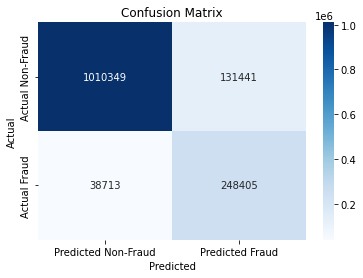

In [0]:
prediction_and_labels = test_predictions_LR.select("label", "prediction")

TP = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 1)).count()
TN = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 0)).count()
FP = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 1)).count()
FN = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 0)).count()

conf_matrix = np.array([[TN, FP], [FN, TP]])


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Non-Fraud", "Predicted Fraud"], yticklabels=["Actual Non-Fraud", "Actual Fraud"])


plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

## Decision Tree
For the Decision Trees model, it was also used “areaUnderPR”, hyperparameter tuning and cross validation with 3-fold, like in the Decision Trees model.  

In [0]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features_1", weightCol="weights")

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")

However, since this is a different model, it requires a different set of parameters. 

- The first hyperparameter was the maximum depth of trees (maxDepth). Increasing depth can capture mode complex patterns while shallower tree can be better to generalize. 

- The number of bins for splitting (maxBins) number of discrete bins used to split continuous features when the algorithm is finding the best split point. 

- The Minimum Instances per Leaf Node (minInstancesPerNode) sets the minimum number of data points required in leaf node, preventing overfitting. 

- The impurity criterion (impurity) measures the quality of the split. 

In [0]:
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [10, 15])        
             .addGrid(dt.maxBins, [16, 32])       
             .addGrid(dt.minInstancesPerNode, [1, 2])  
             .addGrid(dt.impurity, ["entropy"]) 
             .build())

crossval = CrossValidator(estimator=dt,                 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator,          
                          numFolds=3,                 
                          parallelism=2)

### Train the Decision Tree model
After setting all of the previous configurations, the model was fitted to the train data.

In [0]:
if are_models_saved == False:
    cv_DT_model = crossval.fit(train_data_DT_RF_GB)

Lets now compare on how the different hyperparametres combination performed based on the "areaUnderPR".

In [0]:
if are_models_saved == False:
    paramMaps = crossval.getEstimatorParamMaps()  
    avgMetrics = cv_DT_model.avgMetrics           

    results = []

    for params, auc in zip(paramMaps, avgMetrics):
        results.append({
            "maxDepth": params[dt.maxDepth],              
            "maxBins": params[dt.maxBins],                  
            "minInstancesPerNode": params[dt.minInstancesPerNode],
            "impurity": params[dt.impurity],                  
            "AUC": auc                                       
        })

    results_df = pd.DataFrame(results)


    results_df = results_df.sort_values(by="AUC", ascending=False)

    print(results_df)

Get the best model based on the performance on the metric "areaUnderPR"

In [0]:
if are_models_saved == False:
    best_dt_model = cv_DT_model.bestModel
    best_model_params = best_dt_model.extractParamMap()
    for param, value in best_model_params.items():
        print(f"{param.name}: {value}")

In [0]:
#Save best decision tree model 
if are_models_saved == False: 
    best_dt_model.write().overwrite().save(path=path_best_DT_model)

In [0]:
#Load best decision tree model 
if are_models_saved == True:
    best_dt_model = DecisionTreeClassificationModel.load(path_best_DT_model)

**Decision Trees Test data**

Now lets evaluate the performance of the trained decision tress model. This step evaluates how well the model make predictions on unseen data.

In [0]:
test_predictions_DT = best_dt_model.transform(test_data_DT_RF_GB)
test_predictions_DT.show(1)
test_predictions_DT.head(1)

+-----+--------------------+-------+-------------+-----------+----------+
|label|          features_1|weights|rawPrediction|probability|prediction|
+-----+--------------------+-------+-------------+-----------+----------+
|  0.0|(262144,[121517,1...|      1|  [125.0,0.0]|  [1.0,0.0]|       0.0|
+-----+--------------------+-------+-------------+-----------+----------+
only showing top 1 row

Out[86]: [Row(label=0.0, features_1=SparseVector(262144, {121517: 3128499.0, 139551: 0.0, 144481: 1.0, 159283: 1.0, 161488: 2.0, 206239: 5.0, 231569: 1874420.6904}), weights=1, rawPrediction=DenseVector([125.0, 0.0]), probability=DenseVector([1.0, 0.0]), prediction=0.0)]

### Evaluating Decision Tree Model Performance

Now we want the obtain the overall and class-specific evaluation metrics for the model's predictions. The metrics will assess how well the model performs. 

**Metrics:**
1. **Overall Metrics**:
   - **F1 Score**: Balances precision and recall, providing an overall accuracy.
   - **Weighted Precision**: The average precision across all classes.
   - **Weighted Recall**: The average recall for both classes.

2. **Class-Specific Metrics**:
   - **Precision by Class**: How many predicted positives are true positives, for each class.
   - **Recall by Class**: How many actual positives are correctly identified, for each class.
   - **F1 Score by Class**: A balanced measure of precision and recall, for each class.

In [0]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_score = evaluator_f1.evaluate(test_predictions_DT)
precision_overall = evaluator_precision_overall.evaluate(test_predictions_DT)
recall_overall = evaluator_recall_overall.evaluate(test_predictions_DT)
print(f"Overall F1 Score: {f1_score}")
print(f"Overall Precision (Weighted): {precision_overall}")
print(f"Overall Recall (Weighted): {recall_overall}")
num_classes = 2  
precision_by_class = {}
recall_by_class = {}
f1_by_class = {}
for label in range(num_classes):
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
    evaluator_f1_class = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    evaluator_precision.setMetricLabel(label)
    evaluator_recall.setMetricLabel(label)
    evaluator_f1_class.setMetricLabel(label)
    precision_by_class[label] = evaluator_precision.evaluate(test_predictions_DT)
    recall_by_class[label] = evaluator_recall.evaluate(test_predictions_DT)
    f1_by_class[label] = evaluator_f1_class.evaluate(test_predictions_DT)
for label in range(num_classes):
    print(f"Class {label}:")
    print(f"  Precision: {precision_by_class[label]}")
    print(f"  Recall: {recall_by_class[label]}")
    print(f"  F1 Score: {f1_by_class[label]}")

Overall F1 Score: 0.8939521372244694
Overall Precision (Weighted): 0.9179273071185695
Overall Recall (Weighted): 0.8868
Class 0:
  Precision: 0.9853024307518372
  Recall: 0.8715
  F1 Score: 0.8939521372244694
Class 1:
  Precision: 0.6484268125854993
  Recall: 0.948
  F1 Score: 0.8939521372244694


### Confusion Matrix of Decision Tree Model
The confusion matrix assess the performance of the model in the test dataset.

   - **True Positive (TP)**: The model correctly predicted 474 fraud cases.
   - **True Negative (TN)**: The model correctly predicted 1743 non-fraud cases.
   - **False Positive (FP)**: The model incorrectly predicted 257 frauds for non-fraud transactions.
   - **False Negative (FN)**: The model incorrectly predicted 26 non-fraud for fraud transactions.

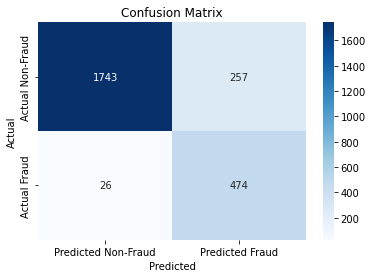

In [0]:
prediction_and_labels = test_predictions_DT.select("label", "prediction")

# Calculate the confusion matrix elements (True Positive, False Positive, False Negative, True Negative)
TP = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 1)).count()
TN = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 0)).count()
FP = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 1)).count()
FN = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 0)).count()

conf_matrix = np.array([[TN, FP], [FN, TP]])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Non-Fraud", "Predicted Fraud"], yticklabels=["Actual Non-Fraud", "Actual Fraud"])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

#plt.savefig('/dbfs/Projeto_Fraud/DT_confusion_matrix.png')  
plt.show()

## Random Forest
To define the Random Forest model, it was necessary to specify the name of the label, features and weight variables. 

In [0]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features_1", weightCol="weights")

For the Random Forest model, it was also used “areaUnderPR”, hyperparameter tuning and cross validation with 3-fold, like in the Random Forest model.

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")

Adding to the previously discussed hyperparameters, the Random Forest adds a new parameter called "numTrees".

The number of trees (numTrees) specifies how many trees the Random Forest will build. Increasing the number of trees improves the model´s stability, however too many can be computational costly. 

In [0]:
paramGrid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [100, 200])  
    .addGrid(rf.maxDepth, [5, 10])    
    .addGrid(rf.maxBins, [32, 64])   
    .addGrid(rf.minInstancesPerNode, [1, 2])  
    .addGrid(rf.impurity, ["entropy"])  
    .build())

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

### Train the Random Forest model
After setting all of the previous configurations, the model was fitted to the train data.

In [0]:
if are_models_saved == False:
    cv_RF_model = crossval.fit(train_data_DT_RF_GB)

Lets now compare on how the different hyperparametres combination performed based on the "areaUnderPR".

In [0]:
if are_models_saved == False:
    paramMaps = crossval.getEstimatorParamMaps()  
    avgMetrics = cv_RF_model.avgMetrics           
    results = []
    
    for params, auc in zip(paramMaps, avgMetrics):
        results.append({
            "numTrees": params[rf.numTrees],     
            "maxDepth": params[rf.maxDepth],                
            "maxBins": params[rf.maxBins],                   
            "minInstancesPerNode": params[rf.minInstancesPerNode], 
            "impurity": params[rf.impurity],                  
            "AUC": auc                                         
        })
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AUC", ascending=False)
    print(results_df)

Get the best model based on the performance on the metric "areaUnderPR"

In [0]:
if are_models_saved == False:
    best_RF_model = cv_RF_model.bestModel
    best_model_params = best_RF_model.extractParamMap()
    for param, value in best_model_params.items():
        print(f"{param.name}: {value}")

In [0]:
#Save best Random Forest model
if are_models_saved == False:
    best_RF_model.write().overwrite().save(path=path_best_RF_model)

In [0]:
#Load best Random Forest model
if are_models_saved == True:
    best_RF_model = RandomForestClassificationModel.load(path_best_RF_model)

**Random Forest Test data**

Now lets evaluate the performance of the trained Random Forest model. This step evaluates how well the model make predictions on unseen data.

In [0]:
test_predictions_RF = best_RF_model.transform(test_data_DT_RF_GB)
test_predictions_RF.show(1)
test_predictions_RF.head(1)

+-----+--------------------+-------+--------------------+--------------------+----------+
|label|          features_1|weights|       rawPrediction|         probability|prediction|
+-----+--------------------+-------+--------------------+--------------------+----------+
|  0.0|(262144,[121517,1...|      1|[45.0260308699366...|[0.22513015434968...|       1.0|
+-----+--------------------+-------+--------------------+--------------------+----------+
only showing top 1 row

Out[34]: [Row(label=0.0, features_1=SparseVector(262144, {121517: 3128499.0, 139551: 0.0, 144481: 1.0, 159283: 1.0, 161488: 2.0, 206239: 5.0, 231569: 1874420.6904}), weights=1, rawPrediction=DenseVector([45.026, 154.974]), probability=DenseVector([0.2251, 0.7749]), prediction=1.0)]

### Evaluating Random Forest Model Performance

Now we want the obtain the overall and class-specific evaluation metrics for the model's predictions. The metrics will assess how well the model performs. 

**Metrics:**
1. **Overall Metrics**:
   - **F1 Score**: Balances precision and recall, providing an overall accuracy.
   - **Weighted Precision**: The average precision across all classes.
   - **Weighted Recall**: The average recall for both classes.

2. **Class-Specific Metrics**:
   - **Precision by Class**: How many predicted positives are true positives, for each class.
   - **Recall by Class**: How many actual positives are correctly identified, for each class.
   - **F1 Score by Class**: A balanced measure of precision and recall, for each class.

In [0]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

f1_score = evaluator_f1.evaluate(test_predictions_RF)
precision_overall = evaluator_precision_overall.evaluate(test_predictions_RF)
recall_overall = evaluator_recall_overall.evaluate(test_predictions_RF)

print(f"Overall F1 Score: {f1_score}")
print(f"Overall Precision (Weighted): {precision_overall}")
print(f"Overall Recall (Weighted): {recall_overall}")
num_classes = 2 
precision_by_class = {}
recall_by_class = {}
f1_by_class = {}

for label in range(num_classes):
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
    evaluator_f1_class = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    evaluator_precision.setMetricLabel(label)
    evaluator_recall.setMetricLabel(label)
    evaluator_f1_class.setMetricLabel(label)

    precision_by_class[label] = evaluator_precision.evaluate(test_predictions_RF)
    recall_by_class[label] = evaluator_recall.evaluate(test_predictions_RF)
    f1_by_class[label] = evaluator_f1_class.evaluate(test_predictions_RF)

for label in range(num_classes):
    print(f"Class {label}:")
    print(f"  Precision: {precision_by_class[label]}")
    print(f"  Recall: {recall_by_class[label]}")
    print(f"  F1 Score: {f1_by_class[label]}")

Overall F1 Score: 0.06666666666666668
Overall Precision (Weighted): 0.04
Overall Recall (Weighted): 0.2
Class 0:
  Precision: 0.0
  Recall: 0.0
  F1 Score: 0.06666666666666668
Class 1:
  Precision: 0.2
  Recall: 1.0
  F1 Score: 0.06666666666666668


### Confusion Matrix of Random Forest Model
The confusion matrix assess the performance of the model in the test dataset.

   - **True Positive (TP)**: The model correctly predicted 500 fraud cases.
   - **True Negative (TN)**: The model correctly predicted 0 non-fraud cases.
   - **False Positive (FP)**: The model incorrectly predicted 2000 frauds for non-fraud transactions.
   - **False Negative (FN)**: The model incorrectly predicted 0 non-fraud for fraud transactions.

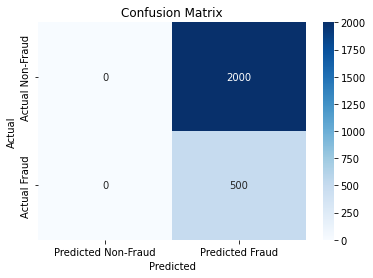

In [0]:
prediction_and_labels = test_predictions_RF.select("label", "prediction")
TP = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 1)).count()
TN = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 0)).count()
FP = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 1)).count()
FN = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 0)).count()

conf_matrix = np.array([[TN, FP], [FN, TP]])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Non-Fraud", "Predicted Fraud"], yticklabels=["Actual Non-Fraud", "Actual Fraud"])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Save the plot
#plt.savefig(path_RF_confusion_matrix) 

plt.show()

## Gradient-Boosted Trees Classifier Model (GBT Classifier)

For the GBTClassifier model, it was also used the “areaUnderPR” metric, hyperparameter tuning and cross validation with 3-fold, like in the Random Forest model.

In [0]:
gbt = GBTClassifier(labelCol="label", featuresCol="features_1", weightCol="weights")
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")

A new hyperparamenter used in the GBT Classifier model is the stepSize. 
- This hyperparameter controls the learning rate of the model. The stepSize choosed helped to optimize the model by making small adjustments to the weights. 

In [0]:
paramGrid = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [3, 5])          
    .addGrid(gbt.maxIter, [10, 20])        
    .addGrid(gbt.stepSize, [0.05])   
    .addGrid(gbt.minInstancesPerNode, [1,2])   
    .build())


crossval = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=4
)

### Train the GBTClassifier model
After setting all of the previous configurations, the model was fitted to the train data.

In [0]:
if are_models_saved == False:
    cv_GB_model = crossval.fit(train_data_DT_RF_GB)

Lets now compare on how the different hyperparametres combination performed based on the "areaUnderPR".

In [0]:
if are_models_saved == False:
    paramMaps = crossval.getEstimatorParamMaps()  
    avgMetrics = cv_GB_model.avgMetrics           

    results = []

    for params, auc in zip(paramMaps, avgMetrics):
        results.append({
            "maxDepth": params[gbt.maxDepth],        
            "maxIter": params[gbt.maxIter],          
            "stepSize": params[gbt.stepSize],        
            "minInstancesPerNode": params[gbt.minInstancesPerNode],  
            "AUC": auc                               
        })

    results_df = pd.DataFrame(results)

    results_df = results_df.sort_values(by="AUC", ascending=False)

    print(results_df)

Get the best model based on the performance on the metric "areaUnderPR"

In [0]:
if are_models_saved == False:

    best_GB_model = cv_GB_model.bestModel

    best_model_params = best_GB_model.extractParamMap()

    for param, value in best_model_params.items():
        print(f"{param.name}: {value}")

In [0]:
#Save best GBTClassifier  model
if are_models_saved == False:
    best_GB_model.write().overwrite().save(path=path_best_GB_model)

In [0]:
#Load best GBTClassifier  model
if are_models_saved == True:
    best_GB_model = GBTClassificationModel.load(path_best_GB_model)

**GBTClassifier Test data**

Now lets evaluate the performance of the trained GBTClassifier model. This step evaluates how well the model make predictions on unseen data.

In [0]:
test_predictions_GB = best_GB_model.transform(test_data_DT_RF_GB)
test_predictions_GB.show(1)
test_predictions_GB.head(1)

+-----+--------------------+-------+--------------------+--------------------+----------+
|label|          features_1|weights|       rawPrediction|         probability|prediction|
+-----+--------------------+-------+--------------------+--------------------+----------+
|  0.0|(262144,[121517,1...|      1|[0.69659268991506...|[0.80110028401629...|       0.0|
+-----+--------------------+-------+--------------------+--------------------+----------+
only showing top 1 row

Out[77]: [Row(label=0.0, features_1=SparseVector(262144, {121517: 3128499.0, 139551: 0.0, 144481: 1.0, 159283: 1.0, 161488: 2.0, 206239: 5.0, 231569: 1874420.6904}), weights=1, rawPrediction=DenseVector([0.6966, -0.6966]), probability=DenseVector([0.8011, 0.1989]), prediction=0.0)]

### Evaluating GBTClassifier Model Performance

Now we want the obtain the overall and class-specific evaluation metrics for the model's predictions. The metrics will assess how well the model performs. 

**Metrics:**
1. **Overall Metrics**:
   - **F1 Score**: Balances precision and recall, providing an overall accuracy.
   - **Weighted Precision**: The average precision across all classes.
   - **Weighted Recall**: The average recall for both classes.

2. **Class-Specific Metrics**:
   - **Precision by Class**: How many predicted positives are true positives, for each class.
   - **Recall by Class**: How many actual positives are correctly identified, for each class.
   - **F1 Score by Class**: A balanced measure of precision and recall, for each class.

In [0]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

f1_score = evaluator_f1.evaluate(test_predictions_GB)
precision_overall = evaluator_precision_overall.evaluate(test_predictions_GB)
recall_overall = evaluator_recall_overall.evaluate(test_predictions_GB)

print(f"Overall F1 Score: {f1_score}")
print(f"Overall Precision (Weighted): {precision_overall}")
print(f"Overall Recall (Weighted): {recall_overall}")

num_classes = 2 
precision_by_class = {}
recall_by_class = {}
f1_by_class = {}

for label in range(num_classes):
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
    evaluator_f1_class = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    evaluator_precision.setMetricLabel(label)
    evaluator_recall.setMetricLabel(label)
    evaluator_f1_class.setMetricLabel(label)

    precision_by_class[label] = evaluator_precision.evaluate(test_predictions_GB)
    recall_by_class[label] = evaluator_recall.evaluate(test_predictions_GB)
    f1_by_class[label] = evaluator_f1_class.evaluate(test_predictions_GB)

for label in range(num_classes):
    print(f"Class {label}:")
    print(f"  Precision: {precision_by_class[label]}")
    print(f"  Recall: {recall_by_class[label]}")
    print(f"  F1 Score: {f1_by_class[label]}")


Overall F1 Score: 0.8557374758932774
Overall Precision (Weighted): 0.9032744983024938
Overall Recall (Weighted): 0.8428
Class 0:
  Precision: 0.9884498480243161
  Recall: 0.813
  F1 Score: 0.8557374758932774
Class 1:
  Precision: 0.5625730994152047
  Recall: 0.962
  F1 Score: 0.8557374758932774


### Confusion Matrix of GBTClassifier Model
The confusion matrix assess the performance of the model in the test dataset.

   - **True Positive (TP)**: The model correctly predicted 481 fraud cases.
   - **True Negative (TN)**: The model correctly predicted 1626 non-fraud cases.
   - **False Positive (FP)**: The model incorrectly predicted 374 frauds for non-fraud transactions.
   - **False Negative (FN)**: The model incorrectly predicted 19 non-fraud for fraud transactions.

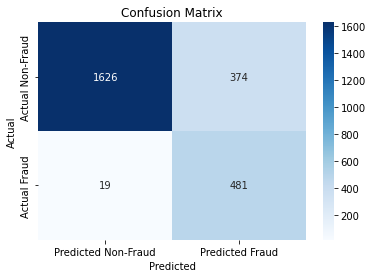

In [0]:
prediction_and_labels = test_predictions_GB.select("label", "prediction")

TP = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 1)).count()
TN = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 0)).count()
FP = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 1)).count()
FN = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 0)).count()

conf_matrix = np.array([[TN, FP], [FN, TP]])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Non-Fraud", "Predicted Fraud"], yticklabels=["Actual Non-Fraud", "Actual Fraud"])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

#plt.savefig(path_GB_confusion_matrix)  # Correct path for saving in DBFS

plt.show()

## Linear Support Vector Classifier Model
To define the Linear Support Vector Classifier model, it was necessary to specify the name of the label, features and weight variables. 

In [0]:
svc = LinearSVC(featuresCol="features_2", labelCol="label", weightCol="weights")

For the Linear Support Vector Classifier model, it was also used “areaUnderPR”, hyperparameter tuning and cross validation with 3-fold.

In [0]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR")

The Linear Support Vector uses two parameters called "maxIter" and "regParam".

The Maximum Iterations (maxIter) specifies the maximum number of iterations the algorithm will run during training to converge to an optimal solution.
The Regularization Parameter (regParam) controls the strength of regularization, which penalizes large model weights to prevent overfitting.

In [0]:
paramGrid = (ParamGridBuilder()
             .addGrid(svc.maxIter, [10, 50, 100])
             .addGrid(svc.regParam, [0.01, 0.1, 1.0])
             .build())

crossval = CrossValidator(
    estimator=svc,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3, 
    parallelism=2 
)

### Train the Linear Support Vector Classifier model
After setting all of the previous configurations, the model was fitted to the train data.

In [0]:
if are_models_saved == False:
    cv_SVC_model = crossval.fit(train_data_LR)

Lets now compare on how the different hyperparametres combination performed based on the "areaUnderROC".

In [0]:
if are_models_saved == False:
    paramMaps = crossval.getEstimatorParamMaps()  
    avgMetrics = cv_SVC_model.avgMetrics           
    results = []
    
    for params, auc in zip(paramMaps, avgMetrics):
        results.append({
            "maxIter": params[svc.maxIter],     
            "regParam": params[svc.regParam],                 
            "AUC": auc                                       
        })
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AUC", ascending=False)
    print(results_df)

Get the best model based on the performance on the metric "areaUnderROC"

In [0]:
if are_models_saved == False:
    best_SVC_model = cv_SVC_model.bestModel
    best_model_params = best_SVC_model.extractParamMap()
    for param, value in best_model_params.items():
        print(f"{param.name}: {value}")

In [0]:
if are_models_saved == False:
    best_SVC_model.write().overwrite().save(path=path_best_SVC_model)

In [0]:
if are_models_saved == True:
    best_SVC_model = LinearSVCModel.load(path_best_SVC_model)

**Linear Support Vector Classifier Test data**

Now lets evaluate the performance of the trained Linear Support Vector Classifier model. This step evaluates how well the model make predictions on unseen data.

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import math

sigmoid_udf = udf(sigmoid, DoubleType())

In [0]:
test_predictions_SVC = best_SVC_model.transform(test_data_LR)
test_predictions_SVC.show(1)
test_predictions_SVC.head(1)

+-----+--------------------+-------+--------------------+----------+
|label|          features_1|weights|       rawPrediction|prediction|
+-----+--------------------+-------+--------------------+----------+
|  0.0|(262144,[121517,1...|      1|[1.00000009205979...|       0.0|
+-----+--------------------+-------+--------------------+----------+
only showing top 1 row

Out[179]: [Row(label=0.0, features_1=SparseVector(262144, {121517: 305323.0, 139551: 0.0, 144481: 1.0, 159283: 1.0, 161488: 0.0, 206239: 8.0, 231569: 2611208.7023}), weights=1, rawPrediction=DenseVector([1.0, -1.0]), prediction=0.0)]

By definition, the SVC model does not include a "probability" column, which is needed to calculate our metric. This forced us to create it ourselves. The approach is simple: we apply the sigmoid function to the "rawPrediction" column.

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

In [0]:
sigmoid_udf = udf(sigmoid_vector, ArrayType(DoubleType()))
test_predictions_SVC = test_predictions_SVC.withColumn("probability",sigmoid_udf(col("rawPrediction")))
test_predictions_SVC.show(5)

+-----+--------------------+-------+--------------------+----------+--------------------+
|label|          features_1|weights|       rawPrediction|prediction|         probability|
+-----+--------------------+-------+--------------------+----------+--------------------+
|  0.0|(262144,[121517,1...|      1|[1.00000009205979...|       0.0|[0.73105859673005...|
|  0.0|(262144,[121517,1...|      1|[1.00000009948643...|       0.0|[0.73105859819022...|
|  0.0|(262144,[121517,1...|      1|[1.00000010905166...|       0.0|[0.73105860007086...|
|  0.0|(262144,[121517,1...|      1|[1.00000011834135...|       0.0|[0.73105860189732...|
|  0.0|(262144,[121517,1...|      1|[1.00000008759035...|       0.0|[0.73105859585131...|
+-----+--------------------+-------+--------------------+----------+--------------------+
only showing top 5 rows



### Evaluating Linear Support Vector Classifier Model Performance

Now we want the obtain the overall and class-specific evaluation metrics for the model's predictions. The metrics will assess how well the model performs. 

**Metrics:**
1. **Overall Metrics**:
   - **F1 Score**: Balances precision and recall, providing an overall accuracy.
   - **Weighted Precision**: The average precision across all classes.
   - **Weighted Recall**: The average recall for both classes.

2. **Class-Specific Metrics**:
   - **Precision by Class**: How many predicted positives are true positives, for each class.
   - **Recall by Class**: How many actual positives are correctly identified, for each class.
   - **F1 Score by Class**: A balanced measure of precision and recall, for each class.

In [0]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_score = evaluator_f1.evaluate(test_predictions_SVC)
precision_overall = evaluator_precision_overall.evaluate(test_predictions_SVC)
recall_overall = evaluator_recall_overall.evaluate(test_predictions_SVC)
print(f"Overall F1 Score: {f1_score}")
print(f"Overall Precision (Weighted): {precision_overall}")
print(f"Overall Recall (Weighted): {recall_overall}")
num_classes = 2  
precision_by_class = {}
recall_by_class = {}
f1_by_class = {}
for label in range(num_classes):
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
    evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
    evaluator_f1_class = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    evaluator_precision.setMetricLabel(label)
    evaluator_recall.setMetricLabel(label)
    evaluator_f1_class.setMetricLabel(label)
    precision_by_class[label] = evaluator_precision.evaluate(test_predictions_SVC)
    recall_by_class[label] = evaluator_recall.evaluate(test_predictions_SVC)
    f1_by_class[label] = evaluator_f1_class.evaluate(test_predictions_SVC)
for label in range(num_classes):
    print(f"Class {label}:")
    print(f"  Precision: {precision_by_class[label]}")
    print(f"  Recall: {recall_by_class[label]}")
    print(f"  F1 Score: {f1_by_class[label]}")

Overall F1 Score: 0.9083191418024653
Overall Precision (Weighted): 0.9083236896257557
Overall Recall (Weighted): 0.9083146010799856
Class 0:
  Precision: 0.9426590196844393
  Recall: 0.9425962742711006
  F1 Score: 0.9083191418024653
Class 1:
  Precision: 0.7717814439020314
  Recall: 0.7719857340884235
  F1 Score: 0.9083191418024653


### Confusion Matrix of Linear Support Vector Classifier Model
The confusion matrix assess the performance of the model in the test dataset.

   - **True Positive (TP)**: The model correctly predicted 221651 fraud cases.
   - **True Negative (TN)**: The model correctly predicted 1076247 non-fraud cases.
   - **False Positive (FP)**: The model incorrectly predicted 65543 frauds for non-fraud transactions.
   - **False Negative (FN)**: The model incorrectly predicted 65467 non-fraud for fraud transactions.

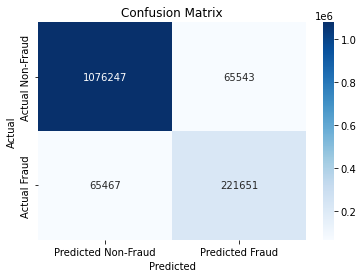

In [0]:
prediction_and_labels = test_predictions_SVC.select("label", "prediction")
TP = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 1)).count()
TN = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 0)).count()
FP = prediction_and_labels.filter((col("label") == 0) & (col("prediction") == 1)).count()
FN = prediction_and_labels.filter((col("label") == 1) & (col("prediction") == 0)).count()
conf_matrix = np.array([[TN, FP], [FN, TP]])
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Non-Fraud", "Predicted Fraud"], yticklabels=["Actual Non-Fraud", "Actual Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## CNN

We also created a simple neural network to address our classification problem.



```python

y_train = to_categorical(y_train, num_classes=2)

X = np.array(X)
X = X.reshape(X.shape[0], X.shape[1], 1)
X = X.reshape(X.shape[0], X.shape[1], 1)
model = models.Sequential()
model.add(layers.Conv1D(64, 2, activation='relu', padding='same', input_shape=(X.shape[1], 1)))  
model.add(MaxPooling1D(pool_size=1))
model.add(layers.Conv1D(128, 2, activation='relu', padding='same')) 
model.add(MaxPooling1D(pool_size=1))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

```



After loading and assigning the data to our predictor variables and target variable, we move on to the construction of the CNN, starting with the one-hot encoding of our target variable.

We had to convert our predictor variables into a NumPy array because the file used to load the data was in CSV format.

Our network is sequential, with two convolutional layers interspersed with 1D pooling layers, without reducing the input size.

Our convolutional layers use the ReLU activation function, without altering the input size. The first layer has 64 filters, and the second has 128 filters.

Our flatten() layer allows us to transition to our dense layers, with the first having a ReLU activation function and the second using the softmax activation function with two output units (in our case, True or False / is fraud or is not fraud).

As for the parameters used to compile the model, we did not search for the best ones, but used the commonly used Adam optimizer and the categorical crossentropy loss function.

This code creates and compiles a convolutional neural network (CNN) to solve a binary classification problem. The network uses 1D convolutional layers to extract features from input sequences and dense layers to make the final classification.

Due to the inherent complexity in converting the file into a model that can be read in Spark, and since it was not possible to use the Databricks ML library, we decided not to submit this model for evaluation. However, since we built it, we will attach it to the report.

## Models Comparision 
**Evaluation Metrics**

The following code will calculate the Overall Performance and the Class-Specific Metrics of the four models. Them it will join them in a single table for better comparison. 

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$



$$ 
\text{Recall} = \frac {\text{True Positives}}{\text{True Positives} + \text{False Negatives}} 
$$



$$
\text{F1 Score} = \frac {2 \times (\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}} 
$$

In [0]:
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall_overall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
def calculate_metrics(test_predictions, model_name, num_classes=2):
    f1_score = evaluator_f1.evaluate(test_predictions)
    precision_overall = evaluator_precision_overall.evaluate(test_predictions)
    recall_overall = evaluator_recall_overall.evaluate(test_predictions)
    precision_by_class = {}
    recall_by_class = {}
    f1_by_class = {}
    for label in range(num_classes):
        evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
        evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
        evaluator_f1_class = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        evaluator_precision.setMetricLabel(label)
        evaluator_recall.setMetricLabel(label)
        evaluator_f1_class.setMetricLabel(label)
        precision_by_class[label] = evaluator_precision.evaluate(test_predictions)
        recall_by_class[label] = evaluator_recall.evaluate(test_predictions)
        f1_by_class[label] = evaluator_f1_class.evaluate(test_predictions)
    metrics = {
        "Model": model_name,
        "Overall F1": f1_score,
        "Overall Precision (Weighted)": precision_overall,
        "Overall Recall (Weighted)": recall_overall
    }
    for label in range(num_classes):
        metrics[f"Class {label} Precision"] = precision_by_class[label]
        metrics[f"Class {label} Recall"] = recall_by_class[label]
        metrics[f"Class {label} F1"] = f1_by_class[label]
    return metrics
metrics_LR = calculate_metrics(test_predictions_LR, "Logistic Regression")
metrics_DT = calculate_metrics(test_predictions_DT, "Decision Trees")
metrics_RF = calculate_metrics(test_predictions_RF, "Random Forest")
metrics_GB = calculate_metrics(test_predictions_GB, "Gradient Boosting")
metrics_SVC = calculate_metrics(test_predictions_SVC, "Linear Support Vector Classifier")
metrics_df = pd.DataFrame([metrics_LR, metrics_DT, metrics_SVC, metrics_RF, metrics_GB])
print(metrics_df)

#metrics_df.to_csv(path_model_metrics_comparison, index=True)

                              Model  Overall F1  Overall Precision (Weighted)  \
0               Logistic Regression    0.886678                      0.900981   
1                    Decision Trees    0.893952                      0.917927   
2  Linear Support Vector Classifier    0.908319                      0.908324   
3                     Random Forest    0.066667                      0.040000   
4                 Gradient Boosting    0.855737                      0.903274   

   Overall Recall (Weighted)  Class 0 Precision  Class 0 Recall  Class 0 F1  \
0                   0.880920           0.963098        0.884882    0.886678   
1                   0.886800           0.985302        0.871500    0.893952   
2                   0.908315           0.942659        0.942596    0.908319   
3                   0.200000           0.000000        0.000000    0.066667   
4                   0.842800           0.988450        0.813000    0.855737   

   Class 1 Precision  Class 1 Recall  

**Precision-Recall Curve Comparison**

We also performed the calculation of the Precision Recall curves (PR curves) of the four models and plot them together. 

These curve shows the trade-off between precision and recall for the different models tested, in other words, it helps to evaluate the performance of the models in balancing false positives and false negatives.

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUD

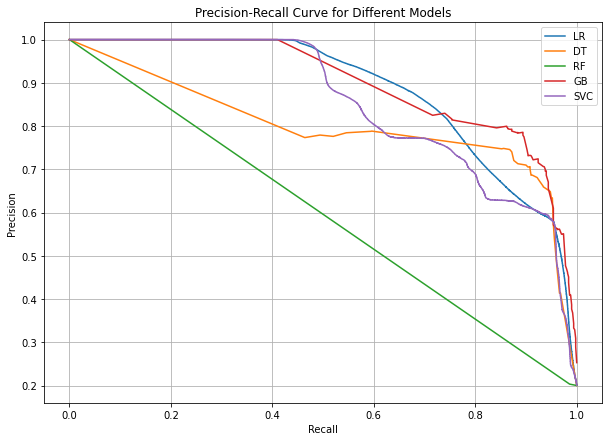

In [0]:
models = [test_predictions_LR, test_predictions_DT, test_predictions_RF, test_predictions_GB, test_predictions_SVC]
labels = ["LR", "DT", "RF", "GB","SVC"]
plt.figure(figsize=(10, 7))
for model_predictions, label in zip(models, labels):
    precision, recall = calculate_pr_curve(model_predictions)
    plt.plot(recall, precision, label=label)
plt.title("Precision-Recall Curve for Different Models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.grid()
plt.show()

**Reasoning on the fraud transaction problems and how to acess the best model** 

- In an imbalanced dataset, we want a model that best performes on the identification of frauds, that is why we will focused on the Class 1 metrics. 

- In the fraud detection missing frauds can be very harmful both for the bank reputation and also for the person scammed. That is why a good model is the one that minimizes the cases where it predicts a non-fraud, but in reality is fraud (false negatives). To minimize these situations, we use the Recall metric.

- It is also important that the model minimizes the cases where it blocks legitimate transactions (false positives). That is why that beside recall, we also want to minimize the cases where the model detects a fraud where it is in reality a non-fraud. To minimize these situations, we use the Precision metric.

Based on what was said before the best model will be the one that optimizes both recall and precision for fraud (label = Class 1). For that we will use the “Class 1 F1 score” which is the harmonic mean of the precision and recall. 

**Choosing the best model** 

- The model that performs the best at “Class 1 F1 score" (90,8%) is the Linear Support Vector Classifier. The “Overall and Class 1 F1 score” of 90,8%, means that this model is the best at optimizing both recall and precision. With the “Class 1 Recall” at 77,1% and “Class 1 Precision” at 77,1% it is clearly the model that can balance both false positives and false negatives.

 
